# Цель и задачи проекта
Цель проекта: исследовать возможность прогнозирования цены акции на основе финансовых показателей деятельности компании

Задачи:
- сбор данных
- анализ, подготовка и разделение данных на обучающую и тестовую выборки
- выбор базовой модели и построение первичного прогноза
- улучшение прогноза: нормализация данных, кластеризация, изменение периода прогноза, добавление признаков с помощью регрессии, использование других алгоритмов

# Описание данных
Датасет собран из разных источников:
- Investing.com
- Московская биржа
- Центр раскрытия корпоративной информации
- Центробанк РФ

Датасет включает исторические ежеквартальные данные за 10 лет:
- отчетность компаний входящих в текущий индекс Мосбиржи
- цены на акции
- индекс Мосбиржи
- индекс RGBI (обилигаций)
- ставку Центробанка России
- курс доллара

# Сбор данных
Информация с квартальной финансовой отчетностью российских компаний собрана с сайта Investing.com, дополнена данными о дате публикации по некоторым компаниям с Центра раскрытия корпоративной информации. По каждой компании собиралась информация по трем видам отчетности: отчет о доходах, баланс и отчет о движении денежных средств, далее три вида отчета объединялись и так по каждой компании. В собранных данных имеются ошибки, некоторые исправлены вручную, некоторые предстоить исправить при анализе данных.

Российские компании публикуют следующие виды отчетности: РСБУ, МСФО и отчетом эмитента, также некоторые компании публикуют операционные результаты. Поскольку участники рынка узнают о результатах деятельности компании не в день завершения квартала, а только после публикации отчетности, то для прогнозирования цены акции важна информация о дате ее публикации, чтобы выбрать значение цены на соответствующую дату.

Отчет по РСБУ как правильно публикуется раньше отчета по МСФО, но по МСФО содержит более ценную информацию для инвестора и включают консолидированные данные о всей группе компаний. Операционные результаты могут публиковаться раньше других. При этом по текущему законодательству в зависимости от того входит ли компания компания в группу, зарегистрирован ли проспект эмиссии, включены ли ценные бумаги в котировальный список, она обязана опубликовать отчет в срок до 120 - 150 дней для годовой отчетности и до 60 - 90 дней для квартальной. В связи с тем, что даты публикации могут иметь отличия, для прогнозирования выбран рабочий день спустя 60 дней после окончания квартала (исключая четвертый) и 90 дней после окончания года.

Цены акций, объем торгов получены путем парсинга данных Мосбиржи.

Значения индекса Мосбиржи, RGBI (обилигаций) и курс доллара взяты с сайта Investing.com, ключевая ставка ЦБ РФ - с сайта Центробанка России

Собираем информацию о ценах акций

In [ ]:
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
ticker_date = pd.read_excel('/content/price-date.xlsx')
tickers = ticker_date.iloc[:, 0].to_list()
need_date = ticker_date.iloc[:, 1].dt.strftime('%Y-%m-%d').to_list()
data =[]

for t in range(len(tickers)):
    j = requests.get('http://iss.moex.com/iss/engines/stock/markets/shares/securities/'+ tickers[t] + '/candles.json?from='+ need_date[t] + '&till='+ need_date[t] + '&interval=24').json()
    if j['candles']['data'] !=[]:
      for r in j['candles']['data']:
         s = {k : r[i] for i, k in enumerate(j['candles']['columns'])}
         s['ticker'] = tickers[t]
      data= data + [s]
frame = pd.DataFrame(data)
frame

open    close    high      low         value   volume  \
0     2033.70  2029.10  2052.7  1997.70  5.940436e+09  2933248   
1     1949.80  1977.70  1977.9  1943.10  2.189705e+09  1115359   
2     2074.10  2055.00  2094.2  2054.90  2.089009e+09  1009544   
3     1926.10  1990.00  1998.3  1926.10  2.521258e+09  1275039   
4     3015.40  3009.50  3099.5  2988.00  3.524974e+09  1156669   
...       ...      ...     ...      ...           ...      ...   
1304   328.45   341.60   346.8   323.45  8.051190e+07   237060   
1305   282.50   284.40   288.5   280.20  2.810209e+07    98805   
1306   430.70   422.15   431.0   420.20  1.152417e+08   271134   
1307   465.00   462.15   479.0   458.00  2.813924e+08   599017   
1308   713.50   707.10   715.0   702.55  3.268630e+08   461944   

                    begin                  end ticker  
0     2014-02-19 00:00:00  2014-02-19 23:59:59   LKOH  
1     2014-05-29 00:00:00  2014-05-29 23:59:59   LKOH  
2     2014-08-29 00:00:00  2014-08-29 23:59:59   LKOH  
3     2014-10-21 00:00:00  2014-10-21 23:59:59   LKOH  
4     2015-03-03 00:00:00  2015-03-03 23:59:59   LKOH  
...                   ...                  ...    ...  
1304  2022-08-31 00:00:00  2022-08-31 23:59:59   GLTR  
1305  2022-12-01 00:00:00  2022-12-01 23:59:59   GLTR  
1306  2023-04-04 00:00:00  2023-04-04 23:59:59   GLTR  
1307  2023-06-01 00:00:00  2023-06-01 23:59:59   GLTR  
1308  2023-08-31 00:00:00  2023-08-31 23:59:59   GLTR  

[1309 rows x 9 columns]

In [ ]:
frame['tradedate'] = pd.to_datetime(frame['begin']).dt.strftime('%Y-%m-%d')
frame

open    close    high      low         value   volume  \
0     2033.70  2029.10  2052.7  1997.70  5.940436e+09  2933248   
1     1949.80  1977.70  1977.9  1943.10  2.189705e+09  1115359   
2     2074.10  2055.00  2094.2  2054.90  2.089009e+09  1009544   
3     1926.10  1990.00  1998.3  1926.10  2.521258e+09  1275039   
4     3015.40  3009.50  3099.5  2988.00  3.524974e+09  1156669   
...       ...      ...     ...      ...           ...      ...   
1304   328.45   341.60   346.8   323.45  8.051190e+07   237060   
1305   282.50   284.40   288.5   280.20  2.810209e+07    98805   
1306   430.70   422.15   431.0   420.20  1.152417e+08   271134   
1307   465.00   462.15   479.0   458.00  2.813924e+08   599017   
1308   713.50   707.10   715.0   702.55  3.268630e+08   461944   

                    begin                  end ticker   tradedate  
0     2014-02-19 00:00:00  2014-02-19 23:59:59   LKOH  2014-02-19  
1     2014-05-29 00:00:00  2014-05-29 23:59:59   LKOH  2014-05-29  
2     2014-08-29 00:00:00  2014-08-29 23:59:59   LKOH  2014-08-29  
3     2014-10-21 00:00:00  2014-10-21 23:59:59   LKOH  2014-10-21  
4     2015-03-03 00:00:00  2015-03-03 23:59:59   LKOH  2015-03-03  
...                   ...                  ...    ...         ...  
1304  2022-08-31 00:00:00  2022-08-31 23:59:59   GLTR  2022-08-31  
1305  2022-12-01 00:00:00  2022-12-01 23:59:59   GLTR  2022-12-01  
1306  2023-04-04 00:00:00  2023-04-04 23:59:59   GLTR  2023-04-04  
1307  2023-06-01 00:00:00  2023-06-01 23:59:59   GLTR  2023-06-01  
1308  2023-08-31 00:00:00  2023-08-31 23:59:59   GLTR  2023-08-31  

[1309 rows x 10 columns]

In [ ]:
ticker_date['tradedate'] = ticker_date['tradedate'].dt.strftime('%Y-%m-%d')

In [ ]:
ticker_date.rename(columns={'secid':'ticker'}, inplace=True)

In [ ]:
ticker_date

ticker   tradedate
0      LKOH  2014-02-19
1      LKOH  2014-05-29
2      LKOH  2014-08-29
3      LKOH  2014-10-21
4      LKOH  2015-03-03
...     ...         ...
1481   GLTR  2022-08-31
1482   GLTR  2022-12-01
1483   GLTR  2023-04-04
1484   GLTR  2023-06-01
1485   GLTR  2023-08-31

[1486 rows x 2 columns]

In [ ]:
output = pd.merge(ticker_date, frame, on=['ticker', 'tradedate'], how='outer')

In [ ]:
output

ticker   tradedate     open    close    high      low         value  \
0      LKOH  2019-03-07  5690.00  5677.00  5719.5  5642.50  3.531650e+09   
1      LKOH  2022-03-24  5302.50  5525.00  5993.0  5300.00  6.814309e+09   
2      SBER  2022-03-24   131.00   136.24   156.2   130.15  2.269207e+10   
3      TATN  2022-03-24   390.00   424.00   442.8   362.50  1.334153e+09   
4      LKOH  2015-03-03  3015.40  3009.50  3099.5  2988.00  3.524974e+09   
...     ...         ...      ...      ...     ...      ...           ...   
1481   GLTR  2022-08-31   328.45   341.60   346.8   323.45  8.051190e+07   
1482   GLTR  2022-12-01   282.50   284.40   288.5   280.20  2.810209e+07   
1483   GLTR  2023-04-04   430.70   422.15   431.0   420.20  1.152417e+08   
1484   GLTR  2023-06-01   465.00   462.15   479.0   458.00  2.813924e+08   
1485   GLTR  2023-08-31   713.50   707.10   715.0   702.55  3.268630e+08   

           volume                begin                  end  
0        621335.0  2019-03-07 00:00:00  2019-03-07 23:59:59  
1       1203273.0  2022-03-24 00:00:00  2022-03-24 23:59:59  
2     159464350.0  2022-03-24 00:00:00  2022-03-24 23:59:59  
3       3129553.0  2022-03-24 00:00:00  2022-03-24 23:59:59  
4       1156669.0  2015-03-03 00:00:00  2015-03-03 23:59:59  
...           ...                  ...                  ...  
1481     237060.0  2022-08-31 00:00:00  2022-08-31 23:59:59  
1482      98805.0  2022-12-01 00:00:00  2022-12-01 23:59:59  
1483     271134.0  2023-04-04 00:00:00  2023-04-04 23:59:59  
1484     599017.0  2023-06-01 00:00:00  2023-06-01 23:59:59  
1485     461944.0  2023-08-31 00:00:00  2023-08-31 23:59:59  

[1486 rows x 10 columns]

In [ ]:
output[output['close'].isnull()][['ticker', 'tradedate']]

ticker   tradedate
20     LKOH  2019-03-03
32     LKOH  2022-03-02
100    SBER  2022-03-01
174    TATN  2022-03-16
355    RUAL  2013-12-03
...     ...         ...
1469   GLTR  2019-09-02
1470   GLTR  2019-12-03
1471   GLTR  2020-04-01
1472   GLTR  2020-06-02
1473   GLTR  2020-09-01

[177 rows x 2 columns]

Имеются пустые пропуски в ценах для некоторых акций, возможно попадание на праздник (заранее даты выбирались исключая попадание на субботу и воскресенье) или в период закрытия торгово весной 2022 года

In [ ]:
prepare = output[output['close'].isnull()][['ticker', 'tradedate']]

In [ ]:
# прибавим для всех дат 1 день на случай попадания на выходной (ранее в Excel уже добавляли 2 дня)
prepare['tradedate'] = prepare['tradedate'].astype("datetime64[ns]")+pd.DateOffset(days=1)
# если даты попадают на промежуток закрытия торгов в феврале-марте 2022 года, то установим дату открытия торгов: 2022-03-24
masks = (prepare['tradedate'] < pd.Timestamp(2022,3,23)) & (prepare['tradedate'] > pd.Timestamp(2022,2,28))
prepare['tradedate'][(masks)] = pd.Timestamp(2022,3,24)
prepare

<ipython-input-80-718e2c6f6526>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prepare['tradedate'][(masks)] = pd.Timestamp(2022,3,24)


ticker  tradedate
20     LKOH 2019-03-07
32     LKOH 2022-03-24
100    SBER 2022-03-24
174    TATN 2022-03-24
355    RUAL 2013-12-07
...     ...        ...
1469   GLTR 2019-09-06
1470   GLTR 2019-12-07
1471   GLTR 2020-04-05
1472   GLTR 2020-06-06
1473   GLTR 2020-09-05

[177 rows x 2 columns]

In [ ]:
# парсим данные Московской биржи
s={}
data =[]
for index, row in prepare.iterrows():
    j = requests.get('http://iss.moex.com/iss/engines/stock/markets/shares/securities/'+ str(row['ticker']) + '/candles.json?from='+ str(row['tradedate']) + '&till='+ str(row['tradedate']) + '&interval=24').json()
    if j['candles']['data'] !=[]:
      for r in j['candles']['data']:
         s = {k : r[i] for i, k in enumerate(j['candles']['columns'])}
         s['ticker'] = row['ticker']
      data= data + [s]

frame = pd.DataFrame(data)
frame

open    close    high      low         value     volume  \
0  5690.0  5677.00  5719.5  5642.50  3.531650e+09     621335   
1  5302.5  5525.00  5993.0  5300.00  6.814309e+09    1203273   
2   131.0   136.24   156.2   130.15  2.269207e+10  159464350   
3   390.0   424.00   442.8   362.50  1.334153e+09    3129553   

                 begin                  end ticker  
0  2019-03-07 00:00:00  2019-03-07 23:59:59   LKOH  
1  2022-03-24 00:00:00  2022-03-24 23:59:59   LKOH  
2  2022-03-24 00:00:00  2022-03-24 23:59:59   SBER  
3  2022-03-24 00:00:00  2022-03-24 23:59:59   TATN

In [ ]:
frame['tradedate'] = pd.to_datetime(frame['begin']).dt.strftime('%Y-%m-%d')
frame

open    close    high      low         value     volume  \
0  5690.0  5677.00  5719.5  5642.50  3.531650e+09     621335   
1  5302.5  5525.00  5993.0  5300.00  6.814309e+09    1203273   
2   131.0   136.24   156.2   130.15  2.269207e+10  159464350   
3   390.0   424.00   442.8   362.50  1.334153e+09    3129553   

                 begin                  end ticker   tradedate  
0  2019-03-07 00:00:00  2019-03-07 23:59:59   LKOH  2019-03-07  
1  2022-03-24 00:00:00  2022-03-24 23:59:59   LKOH  2022-03-24  
2  2022-03-24 00:00:00  2022-03-24 23:59:59   SBER  2022-03-24  
3  2022-03-24 00:00:00  2022-03-24 23:59:59   TATN  2022-03-24

In [ ]:
# сохраняем данные в Excel
frame.to_excel('frame.xlsx')
output.to_excel('output.xlsx')

# Анализ данных

Загрузим собранный датасет. Из-за небольшого количества данных пропуски обрабатывались вручную:
- осуществлялся дополнительный сбор данных по наиболее важным признакам
- для остальных данных считалось среднее между соседними известными наблюдениями

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Classroom/DS ИИ RN ПМ/Финальный проект/Отчетность_компаний_MOEX_зап_пропуски.xlsx',
              sheet_name='Готовый')

In [ ]:
df

Тикер       Компания Квартал Дата оконч периода         Доход  \
0     LKOH  НК Лукойл ПАО    Q-39         2013-12-31  1.179285e+12   
1     LKOH  НК Лукойл ПАО    Q-38         2014-03-31  1.255015e+12   
2     LKOH  НК Лукойл ПАО    Q-37         2014-06-30  1.297675e+12   
3     LKOH  НК Лукойл ПАО    Q-36         2014-09-30  1.542087e+12   
4     LKOH  НК Лукойл ПАО    Q-35         2014-12-31  1.424800e+12   
...    ...            ...     ...                ...           ...   
1481  GLTR    ГлобалТранс     Q-4         2022-06-30  2.420745e+10   
1482  GLTR    ГлобалТранс     Q-3         2022-09-30  2.302956e+10   
1483  GLTR    ГлобалТранс     Q-2         2022-12-31  2.302956e+10   
1484  GLTR    ГлобалТранс     Q-1         2023-03-31  2.598602e+10   
1485  GLTR    ГлобалТранс       Q         2023-06-30  2.598602e+10   

     Рост выручки (год к году)  Себестоимость  Валовая прибыль  \
0                       -0.004  -8.787799e+11     3.005055e+11   
1                        0.057  -9.353257e+11     3.196892e+11   
2                         0.09  -9.620898e+11     3.355851e+11   
3                        0.062  -1.129623e+12     4.124640e+11   
4                     0.208189  -9.519055e+11     4.728943e+11   
...                        ...            ...              ...   
1481                     0.509  -1.372587e+10     1.048158e+10   
1482                     0.121  -1.323887e+10     9.790690e+09   
1483                     0.121  -1.323887e+10     9.790690e+09   
1484                     0.073  -1.478167e+10     1.120435e+10   
1485                     0.073  -1.478167e+10     1.120435e+10   

      Маржа валовой прибыли  Расходы на НИОКР  ...  \
0                     0.255      0.000000e+00  ...   
1                     0.255      0.000000e+00  ...   
2                     0.259      0.000000e+00  ...   
3                     0.267      0.000000e+00  ...   
4                     0.332     -1.314000e+09  ...   
...                     ...               ...  ...   
1481                  0.433      0.000000e+00  ...   
1482                  0.425      0.000000e+00  ...   
1483                  0.425      0.000000e+00  ...   
1484                  0.431      0.000000e+00  ...   
1485                  0.431      0.000000e+00  ...   

      СДП с учетом заемных средств  Выплаченные проценты в денежной форме  \
0                    -3.298793e+10                           6.965578e+09   
1                     9.180205e+09                           8.441568e+08   
2                     5.706305e+09                           9.374644e+09   
3                     2.880964e+10                           1.106543e+09   
4                     4.362866e+09                           2.749033e+09   
...                            ...                                    ...   
1481                  8.954889e+09                           7.767865e+08   
1482                  5.422213e+09                           5.856750e+08   
1483                  5.422213e+09                           5.856750e+08   
1484                  8.116624e+09                           6.916635e+08   
1485                  8.116624e+09                           6.916635e+08   

      Дата цены акции     ММВБ    RGBI  Курс доллара  Ставка ЦБ  Объем торгов  \
0          2014-02-19  1485.60  130.20       35.7780        5.5     2933248.0   
1          2014-05-29  1447.39  127.38       34.6650        7.5     1115359.0   
2          2014-08-29  1400.71  121.67       37.0749        8.0     1009544.0   
3          2014-10-21  1383.35  122.35       40.9400        8.0     1275039.0   
4          2015-03-03  1807.70  108.08       61.9255       15.0     1156669.0   
...               ...      ...     ...           ...        ...           ...   
1481       2022-08-31  2400.08  134.96       60.2300        8.0      237060.0   
1482       2022-12-01  2187.29  130.53       61.4900        7.5       98805.0   
1483       2023-04-04  2480.45  128.91       79.5200        7.5     

Всего 106 признаков и 1486 наблюдений.

In [ ]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486 entries, 0 to 1485
Data columns (total 106 columns):
 #    Column                                                         Non-Null Count  Dtype         
---   ------                                                         --------------  -----         
 0    Тикер                                                          1486 non-null   object        
 1    Компания                                                       1486 non-null   object        
 2    Квартал                                                        1486 non-null   object        
 3    Дата оконч периода                                             1486 non-null   object        
 4    Доход                                                          1486 non-null   float64       
 5    Рост выручки (год к году)                                      1486 non-null   object        
 6    Себестоимость                                                  1349 non-null   float64

Преобразуем тип данных в float для числовых признаков

In [ ]:
ignore = ['Тикер', 'Компания', 'Квартал', 'Дата оконч периода', 'Дата цены акции']

df = (df.set_index(ignore, append=True)
        .replace(',','.', regex=True) # замена в числах запятой на точку
        .astype(float)
        .reset_index(ignore)
       )

In [ ]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1486 entries, 0 to 1485
Data columns (total 106 columns):
 #    Column                                                         Non-Null Count  Dtype         
---   ------                                                         --------------  -----         
 0    Тикер                                                          1486 non-null   object        
 1    Компания                                                       1486 non-null   object        
 2    Квартал                                                        1486 non-null   object        
 3    Дата оконч периода                                             1486 non-null   object        
 4    Дата цены акции                                                1486 non-null   datetime64[ns]
 5    Доход                                                          1486 non-null   float64       
 6    Рост выручки (год к году)                                      1459 non-null   float64

In [ ]:
df

Тикер       Компания Квартал Дата оконч периода Дата цены акции  \
0     LKOH  НК Лукойл ПАО    Q-39         2013-12-31      2014-02-19   
1     LKOH  НК Лукойл ПАО    Q-38         2014-03-31      2014-05-29   
2     LKOH  НК Лукойл ПАО    Q-37         2014-06-30      2014-08-29   
3     LKOH  НК Лукойл ПАО    Q-36         2014-09-30      2014-10-21   
4     LKOH  НК Лукойл ПАО    Q-35         2014-12-31      2015-03-03   
...    ...            ...     ...                ...             ...   
1481  GLTR    ГлобалТранс     Q-4         2022-06-30      2022-08-31   
1482  GLTR    ГлобалТранс     Q-3         2022-09-30      2022-12-01   
1483  GLTR    ГлобалТранс     Q-2         2022-12-31      2023-04-04   
1484  GLTR    ГлобалТранс     Q-1         2023-03-31      2023-06-01   
1485  GLTR    ГлобалТранс       Q         2023-06-30      2023-08-31   

             Доход  Рост выручки (год к году)  Себестоимость  Валовая прибыль  \
0     1.179285e+12                  -0.004000  -8.787799e+11     3.005055e+11   
1     1.255015e+12                   0.057000  -9.353257e+11     3.196892e+11   
2     1.297675e+12                   0.090000  -9.620898e+11     3.355851e+11   
3     1.542087e+12                   0.062000  -1.129623e+12     4.124640e+11   
4     1.424800e+12                   0.208189  -9.519055e+11     4.728943e+11   
...            ...                        ...            ...              ...   
1481  2.420745e+10                   0.509000  -1.372587e+10     1.048158e+10   
1482  2.302956e+10                   0.121000  -1.323887e+10     9.790690e+09   
1483  2.302956e+10                   0.121000  -1.323887e+10     9.790690e+09   
1484  2.598602e+10                   0.073000  -1.478167e+10     1.120435e+10   
1485  2.598602e+10                   0.073000  -1.478167e+10     1.120435e+10   

      Маржа валовой прибыли  ...  Остаток наличных средств (денежный поток)  \
0                     0.255  ...                               5.625033e+10   
1                     0.255  ...                               8.181286e+10   
2                     0.259  ...                               7.808806e+10   
3                     0.267  ...                               1.132626e+11   
4                     0.332  ...                               1.690230e+11   
...                     ...  ...                                        ...   
1481                  0.433  ...                               1.194317e+10   
1482                  0.425  ...                                        NaN   
1483                  0.425  ...                                        NaN   
1484                  0.431  ...                                        NaN   
1485                  0.431  ...                                        NaN   

      СДП с учетом заемных средств  Выплаченные проценты в денежной форме  \
0                    -3.298793e+10                           6.965578e+09   
1                     9.180205e+09                           8.441568e+08   
2                     5.706305e+09                           9.374644e+09   
3                     2.880964e+10                           1.106543e+09   
4                     4.362866e+09                           2.749033e+09   
...                            ...                                    ...   
1481                  8.954889e+09                           7.767865e+08   
1482                  5.422213e+09                           5.856750e+08   
1483                  5.422213e+09                           5.856750e+08   
1484                  8.116624e+09                           6.916635e+08   
1485                  8.116624e+09                           6.916635e+08   

         ММВБ    RGBI  Курс доллара  Ставка ЦБ  Объем торгов     open    close  
0     1485.60  130.20       35.7780        5.5     2933248.0  2033.70  2029.10  
1     1447.39  127.38       34.6650        7.5     1115359.0  1949.80  1977.70  
2     1400.71  121.67       37.0749        8.0    

Посмотрим статистику по данным


In [ ]:
df.describe()

Доход  Рост выручки (год к году)  Себестоимость  \
count  1.486000e+03                1459.000000   1.349000e+03   
mean   2.274377e+11                   0.946769  -1.192109e+11   
std    4.262600e+11                   6.732481   2.238359e+11   
min    6.459000e+06                  -0.980000  -1.825532e+12   
25%    2.303224e+10                  -0.018000  -1.086190e+11   
50%    9.929433e+10                   0.103000  -4.872100e+10   
75%    2.015836e+11                   0.279000  -1.369852e+10   
max    3.516221e+12                  91.229000   0.000000e+00   

       Валовая прибыль  Маржа валовой прибыли  Расходы на НИОКР  \
count     1.349000e+03            1349.000000      1.483000e+03   
mean      1.178331e+11               0.475950     -4.024863e+08   
std       2.603756e+11               0.218773      1.973382e+09   
min      -4.492500e+10              -0.476865     -2.623700e+10   
25%       1.079800e+10               0.291000      0.000000e+00   
50%       4.094000e+10               0.474000      0.000000e+00   
75%       8.367000e+10               0.625000      0.000000e+00   
max       2.280537e+12               1.000000      0.000000e+00   

       Расходы на реализацию, общие и управленческие расходы  \
count                                       1.486000e+03       
mean                                       -1.887227e+10       
std                                         3.768949e+10       
min                                        -2.526850e+11       
25%                                        -1.720471e+10       
50%                                        -5.382500e+09       
75%                                        -8.854782e+08       
max                                         0.000000e+00       

       Общие и административные расходы  Проч доходы/(расходы)  \
count                      6.070000e+02           1.360000e+03   
mean                      -6.973864e+09          -5.924254e+10   
std                        1.512402e+10           1.841559e+11   
min                       -2.168619e+11          -1.332000e+12   
25%                       -8.424186e+09          -3.064683e+10   
50%                       -2.499000e+09          -4.804693e+09   
75%                       -7.728780e+08          -3.142500e+08   
max                        0.000000e+00           3.625550e+11   

       Операционные расходы  ...  Остаток наличных средств (денежный поток)  \
count          1.486000e+03  ...                               1.153000e+03   
mean          -7.861158e+10  ...                               2.127723e+11   
std            1.965317e+11  ...                               4.422460e+11   
min           -1.437629e+12  ...                               4.779000e+06   
25%           -5.693659e+10  ...                               2.087900e+10   
50%           -1.975040e+10  ...                               5.164457e+10   
75%           -4.167000e+09  ...                               1.228490e+11   
max            3.559330e+11  ...                               3.013883e+12   

       СДП с учетом заемных средств  Выплаченные проценты в денежной форме  \
count                  1.447000e+03                           1.387000e+03   
mean                   3.420075e+09                           1.425623e+10   
std                    1.464057e+11                           4.058704e+10   
min                   -1.295700e+12                          -3.674000e+09   
25%                   -1.148981e+09                           6.916635e+08   
50%                    5.706305e+09                           2.595107e+09   
75%                    2.185100e+10                           8.814000e+09   
max                    2.748279e+12                           3.193000e+11   

              ММВБ         RGBI  Курс доллара    Ставка ЦБ  Объем торгов  \
count  1484.000000  1484.000000   1484.000000  1484.000000  1.313000e+03   
mean   2396.339602   135.164137     64.275423     8.451482  1.271408e+09   
std     6

Проверим есть ли дубликаты

In [ ]:
df[(df.duplicated())].sort_values(by='Тикер')

Empty DataFrame
Columns: [Тикер, Компания, Квартал, Дата оконч периода, Дата цены акции, Доход, Рост выручки (год к году), Себестоимость, Валовая прибыль, Маржа валовой прибыли, Расходы на НИОКР, Расходы на реализацию, общие и управленческие расходы, Общие и административные расходы, Проч доходы/(расходы), Операционные расходы, Операционные доходы, Чистые расходы на выплату процентов, EBT, вкл необычные статьи, Доходы от прекращенной деятельности, Расходы по налогу на прибыль, Чистый доход акционеров, Миноритарная доля в прибыли, Чистая прибыль акционеров, Дивиденды по привил акциям и пр корр-ки, ЧП по обыкновенным акциям без учета доп статей, Базовая прибыль на акцию (продолж деятельность), Разводненная прибыль на акцию (продолж деятельность), Средневзвешенное количество распределенных базовых акций, Средневзвешенное количество распределенных разводненных акций, EBITDA, EBIT, Доход (отчетный), Операционные доходы (отчетные), Операционные доходы (скорректир), Наличные средства и их эквиваленты, Краткосрочные инвестиции, Чист дебиторская задолженность, Товарно-материальные запасы, Расходы будущих периодов, Прочие оборотные активы, Совокупные оборотные активы, Чистые основные средства, Недвижимость в собственности, Капитализированное/приобретенное программное обеспечение, Долгосрочные инвестиции, Гудвилл, Прочие нематериальные активы, Прочие долгосрочные активы, Итого активов, Кредиторская задолженность, Начисленные расходы, Краткосрочные заимствования, Текущая часть долгосрочной дебиторской задолженности, Текущая часть обязательств по финансовому лизингу, Прочие текущие обязательства, Совокупные текущие обязательства, Долгосрочная задолженность, Капитальная аренда, Прочие долгосрочные обязательства, Итого обязательства, Обыкновенные акции, Добавочный капитал, Нераспределенная прибыль, Казначейские акции, Прочие корр-ки базового кап-ла, Общий капитал, Совокупный привилегированный капитал, Миноритарный пакет акций, итого, Пр собст кап-л, Итого акционерный капитал, Совокупные обязательства и собственный капитал, Денежные средства и краткосрочные инвестиции, Совокупная задолженность, Чистая прибыль акционеров (дублир), Износ и амортизация (денежный поток), Амортизация расходов будущих периодов (денежный поток), Компенсация в виде акций, Изменение дебиторской задолженности, Изменение объема товарно-материальных запасов, Изменение прочих чистых операционных активов, Прочая операционная деятельность, Наличные средства от операционной деятельности, Капитальные затраты, Приобретения за наличные средства, Прочая инвестиционная деятельность, Наличные средства от инвестиционной деятельности, Выплаченные дивиденды (без специальных), Выплаченные специальные дивиденды, Выпущенные долгосрочные долговые обязательства, Погашенные долгосрочные долговые обязательства, Обратный выкуп обыкновенных акций, Прочая финансовая деятельность, Наличные средства от финансовой деятельности, Остаток средств на начало отчетного периода (денежный поток), Корректировки курса обмена валют, Дополнения/сокращения, Остаток наличных средств (денежный поток), СДП с учетом заемных средств, Выплаченные проценты в денежной форме, ММВБ, ...]
Index: []

[0 rows x 106 columns]

Дубликаты отсуствуют.
Посчитаем кол-во оставшихся пропусков.

In [ ]:
df.isnull().sum(axis=0).sort_values(ascending=False).head(50)

Недвижимость в собственности                                    1486
Выплаченные специальные дивиденды                               1454
Совокупный привилегированный капитал                            1448
Доходы от прекращенной деятельности                             1348
Капитализированное/приобретенное программное обеспечение        1194
Амортизация расходов будущих периодов (денежный поток)          1169
Обратный выкуп обыкновенных акций                               1106
Краткосрочные заимствования                                      916
Компенсация в виде акций                                         902
Приобретения за наличные средства                                882
Общие и административные расходы                                 879
Расходы будущих периодов                                         832
Текущая часть обязательств по финансовому лизингу                744
Гудвилл                                                          720
Капитальная аренда                

Совершенно точно можно удалить признак "Недвижимость в собственности", т.к. он пустой. Можно удалить строки, где пуст целевой признак "close" ("open"), некоторые компании вышли на биржу меньше 10 лет назад. Также можно удалить признак "Квартал", т.к. имеется дата квартального отчета.

По большей части в данных не пропуски, а нулевые значения признаков, их нужно обработать, чтобы была возможность использовать модели, не имеющие работать с пропусками.

In [ ]:
# удалим пустые признаки
df.dropna(how='all', axis=1, inplace=True)

In [ ]:
# удалим строки с пустыми значениями цен акции
df.dropna(subset = ['close'], inplace=True)

In [ ]:
# удалим признак "Квартал"
df.drop(['Квартал', 'open'], axis=1, inplace=True)

In [ ]:
# заменим пустые значения нулями
df = df.fillna(0)

Посмотрим на целевой признак

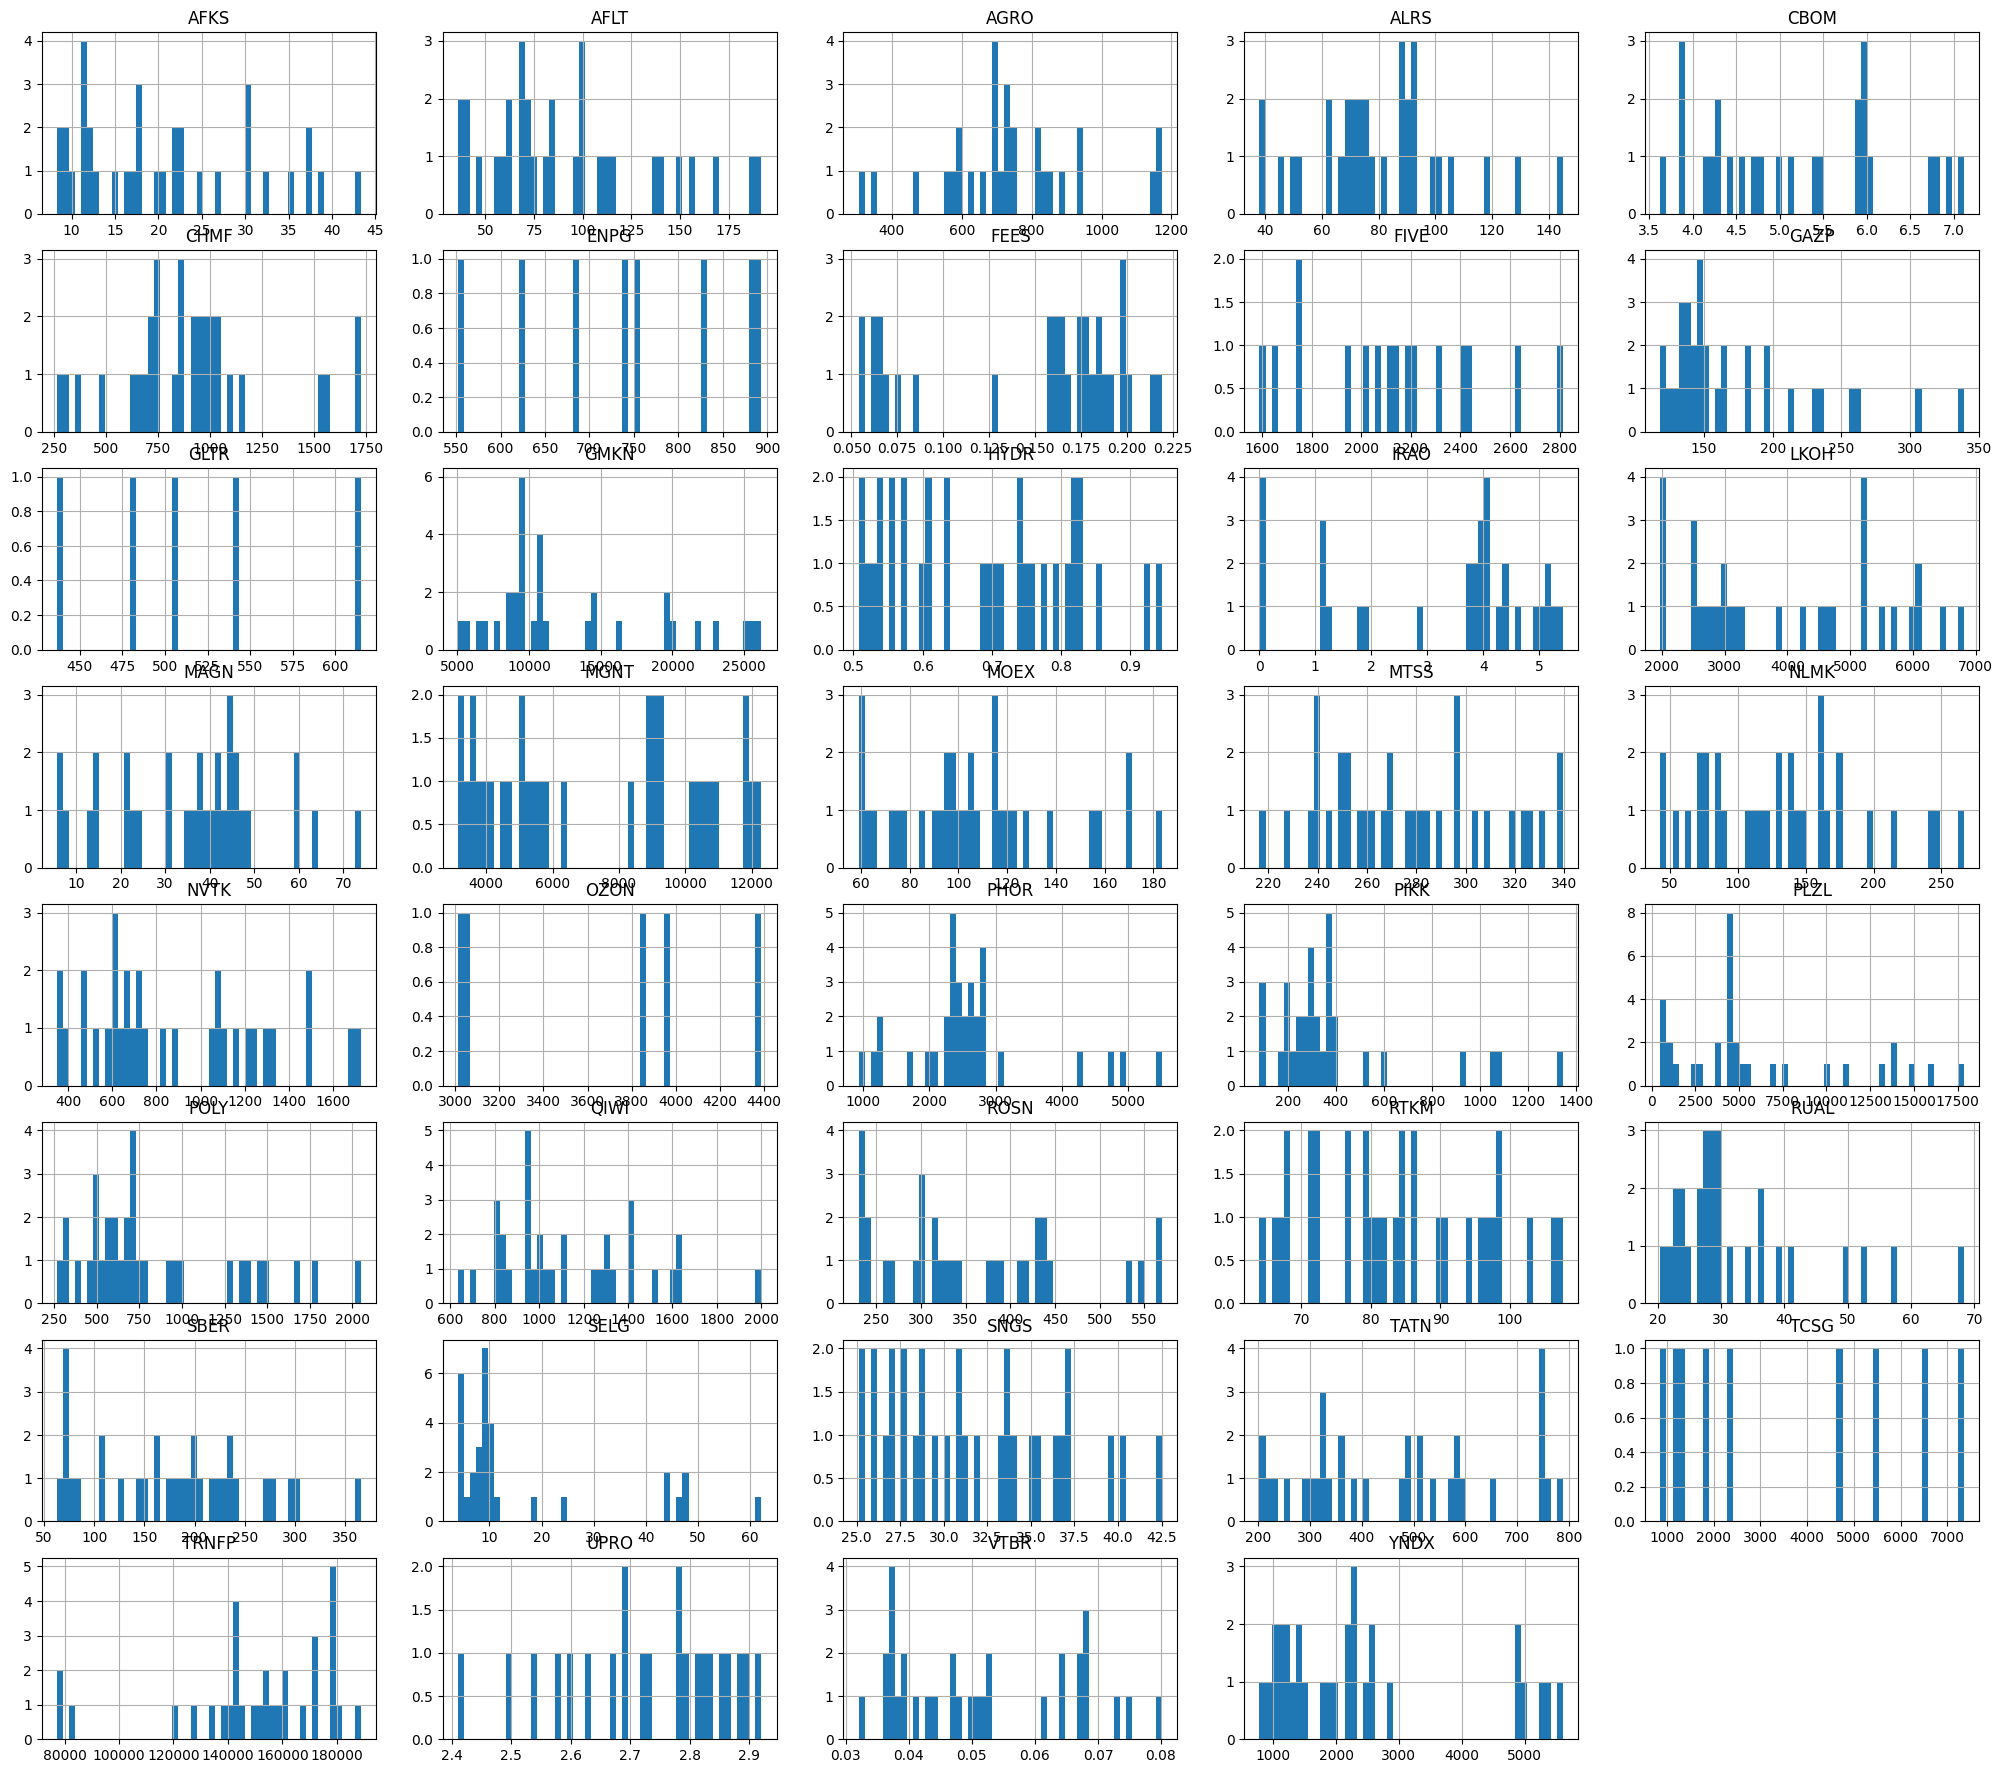

In [ ]:
df_group = df.groupby('Тикер')
idx=0
fig = plt.figure(figsize=(25, 25))
for key,gr in df_group:
  plt.subplot(9, 5, idx+1)
  #plt.tight_layout()
  plt.title(key)
  gr['close'].hist(bins=50)
  idx+=1

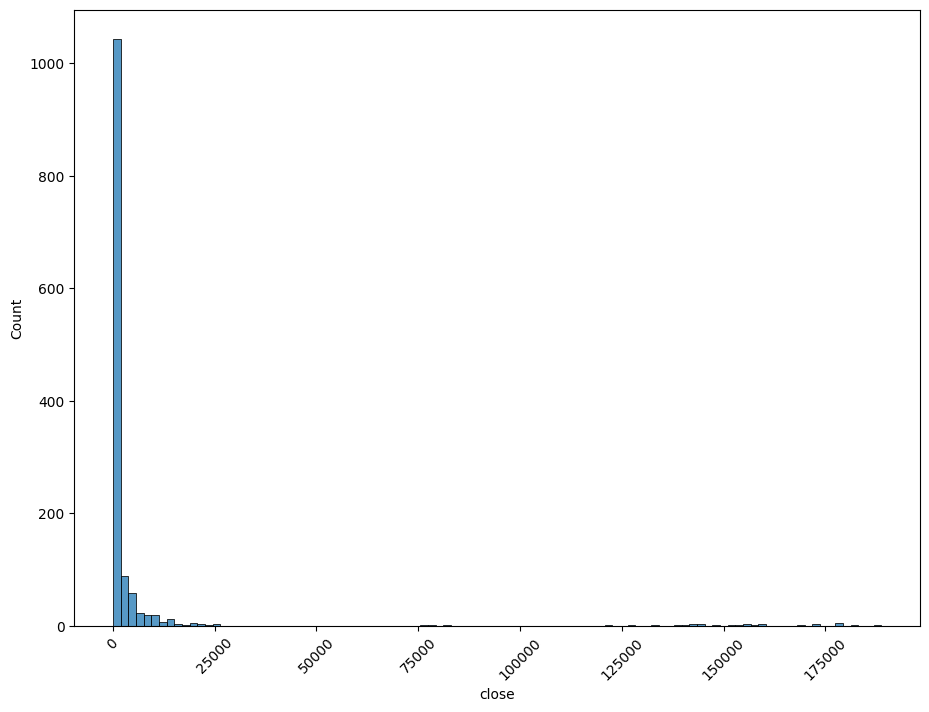

In [ ]:
plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.xticks(rotation=45)
sns.histplot(df['close'], bins=100);

In [ ]:
df[df['close']>125000]

Тикер           Компания Дата оконч периода Дата цены акции  \
1071  TRNFP  Транснефть (прив)         2014-12-31      2015-04-02   
1072  TRNFP  Транснефть (прив)         2015-03-31      2015-06-02   
1073  TRNFP  Транснефть (прив)         2015-06-30      2015-09-01   
1074  TRNFP  Транснефть (прив)         2015-09-30      2015-12-01   
1075  TRNFP  Транснефть (прив)         2015-12-31      2016-04-01   
1076  TRNFP  Транснефть (прив)         2016-03-31      2016-06-01   
1077  TRNFP  Транснефть (прив)         2016-06-30      2016-08-31   
1078  TRNFP  Транснефть (прив)         2016-09-30      2016-12-01   
1079  TRNFP  Транснефть (прив)         2016-12-31      2017-04-04   
1080  TRNFP  Транснефть (прив)         2017-03-31      2017-06-01   
1081  TRNFP  Транснефть (прив)         2017-06-30      2017-08-31   
1082  TRNFP  Транснефть (прив)         2017-09-30      2017-12-01   
1083  TRNFP  Транснефть (прив)         2017-12-31      2018-04-03   
1084  TRNFP  Транснефть (прив)         2018-03-31      2018-06-01   
1085  TRNFP  Транснефть (прив)         2018-06-30      2018-08-31   
1086  TRNFP  Транснефть (прив)         2018-09-30      2018-12-03   
1087  TRNFP  Транснефть (прив)         2018-12-31      2019-04-02   
1088  TRNFP  Транснефть (прив)         2019-03-31      2019-06-03   
1089  TRNFP  Транснефть (прив)         2019-06-30      2019-09-02   
1090  TRNFP  Транснефть (прив)         2019-09-30      2019-12-03   
1091  TRNFP  Транснефть (прив)         2019-12-31      2020-04-01   
1092  TRNFP  Транснефть (прив)         2020-03-31      2020-06-02   
1093  TRNFP  Транснефть (прив)         2020-06-30      2020-09-01   
1094  TRNFP  Транснефть (прив)         2020-09-30      2020-12-01   
1095  TRNFP  Транснефть (прив)         2020-12-31      2021-04-02   
1096  TRNFP  Транснефть (прив)         2021-03-31      2021-06-01   
1097  TRNFP  Транснефть (прив)         2021-06-30      2021-08-31   
1098  TRNFP  Транснефть (прив)         2021-09-30      2021-12-01   

             Доход  Рост выручки (год к году)  Себестоимость  Валовая прибыль  \
1071  2.004450e+11                      0.066  -5.188000e+10     1.485650e+11   
1072  2.014770e+11                      0.071  -4.432300e+10     1.571540e+11   
1073  2.055670e+11                      0.083  -4.925000e+10     1.563170e+11   
1074  2.029720e+11                      0.035  -9.188600e+10     1.110860e+11   
1075  2.056360e+11                      0.026  -1.086190e+11     9.701700e+10   
1076  2.040050e+11                      0.013  -8.539100e+10     1.186140e+11   
1077  2.134010e+11                      0.038  -9.915800e+10     1.142430e+11   
1078  2.116420e+11                      0.043  -9.876900e+10     1.128730e+11   
1079  2.190860e+11                      0.065  -1.052160e+11     1.138700e+11   
1080  2.190710e+11                      0.074  -9.394200e+10     1.251290e+11   
1081  2.191790e+11                      0.027  -9.982900e+10     1.193500e+11   
1082  2.195520e+11                      0.037  -1.034550e+11     1.160970e+11   
1083  2.265350e+11                      0.034  -1.193850e+11     1.071500e+11   
1084  2.252390e+11                      0.028  -9.928000e+10     1.259590e+11   
1085  2.380670e+11                      0.086  -1.177120e+11     1.203550e+11   
1086  2.527060e+11                      0.151  -1.231930e+11     1.295130e+11   
1087  2.639460e+11                      0.165  -1.202520e+11     1.436940e+11   
1088  2.600980e+11                      0.155  -1.125390e+11     1.475590e+11   
1089  2.601860e+11                      0.093  -1.227570e+11     1.374290e+11   
1090  2.724510e+11                      0.078  -1.251000e+11     1.473510e+11   
1091  2.710940e+11                      0.027  -1.426200e+11     1.284740e+11   
1092  2.633430e+11                      0.012  -1.121420e+11     1.512010e+11   
1093  2.283350e+11                     -0.122  -1.007420e+11     1.275930e+11   
1094  2.246970e+11                     -0.175  -1.173700e+11

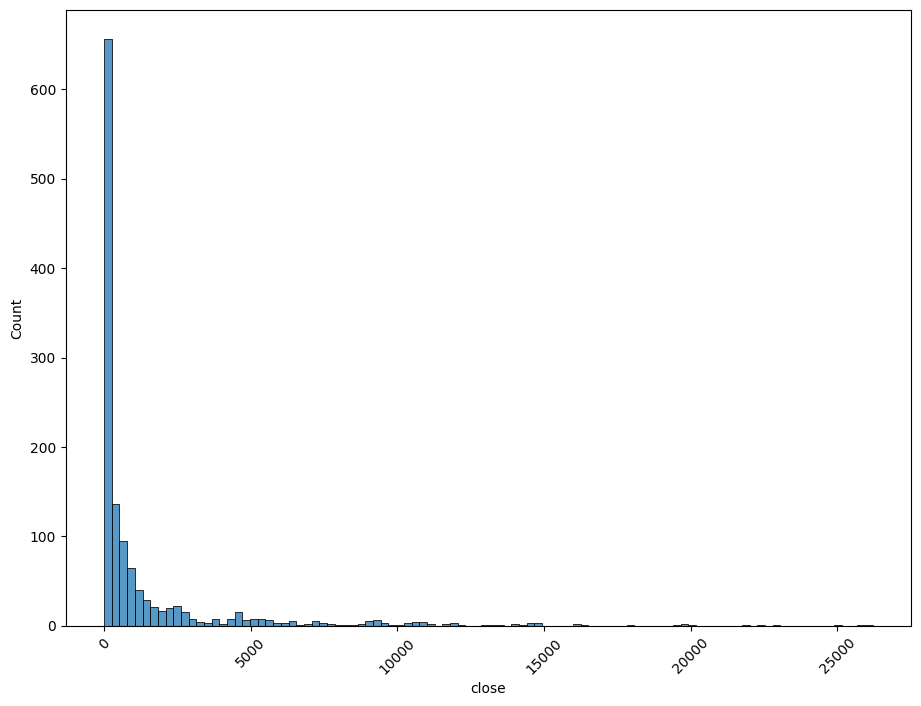

In [ ]:
plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.xticks(rotation=45)
sns.histplot(df[df['close']<50000]['close'], bins=100);

Изучим по каким компаниям имеется отчетность, поскольку некоторые компании вышли на Мосбиржу менее 10 лет, необходимо учитывать при разделениим данных на обучающую и тестовую выборки

In [ ]:
df['Дата оконч периода'] = pd.to_datetime(df['Дата оконч периода'])

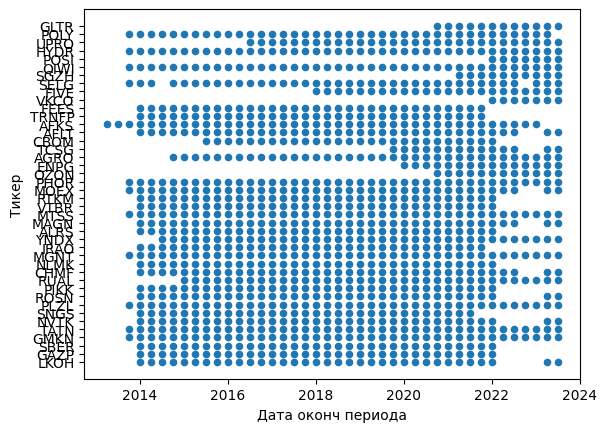

In [ ]:
df.plot(kind='scatter', x='Дата оконч периода', y ='Тикер')

plt.show()

Вычислим корреляцию признаков


<ipython-input-22-afdff6f2bb60>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.corr(), fignum=f.number)


Text(0.5, 1.0, 'Корреляционная матрица')

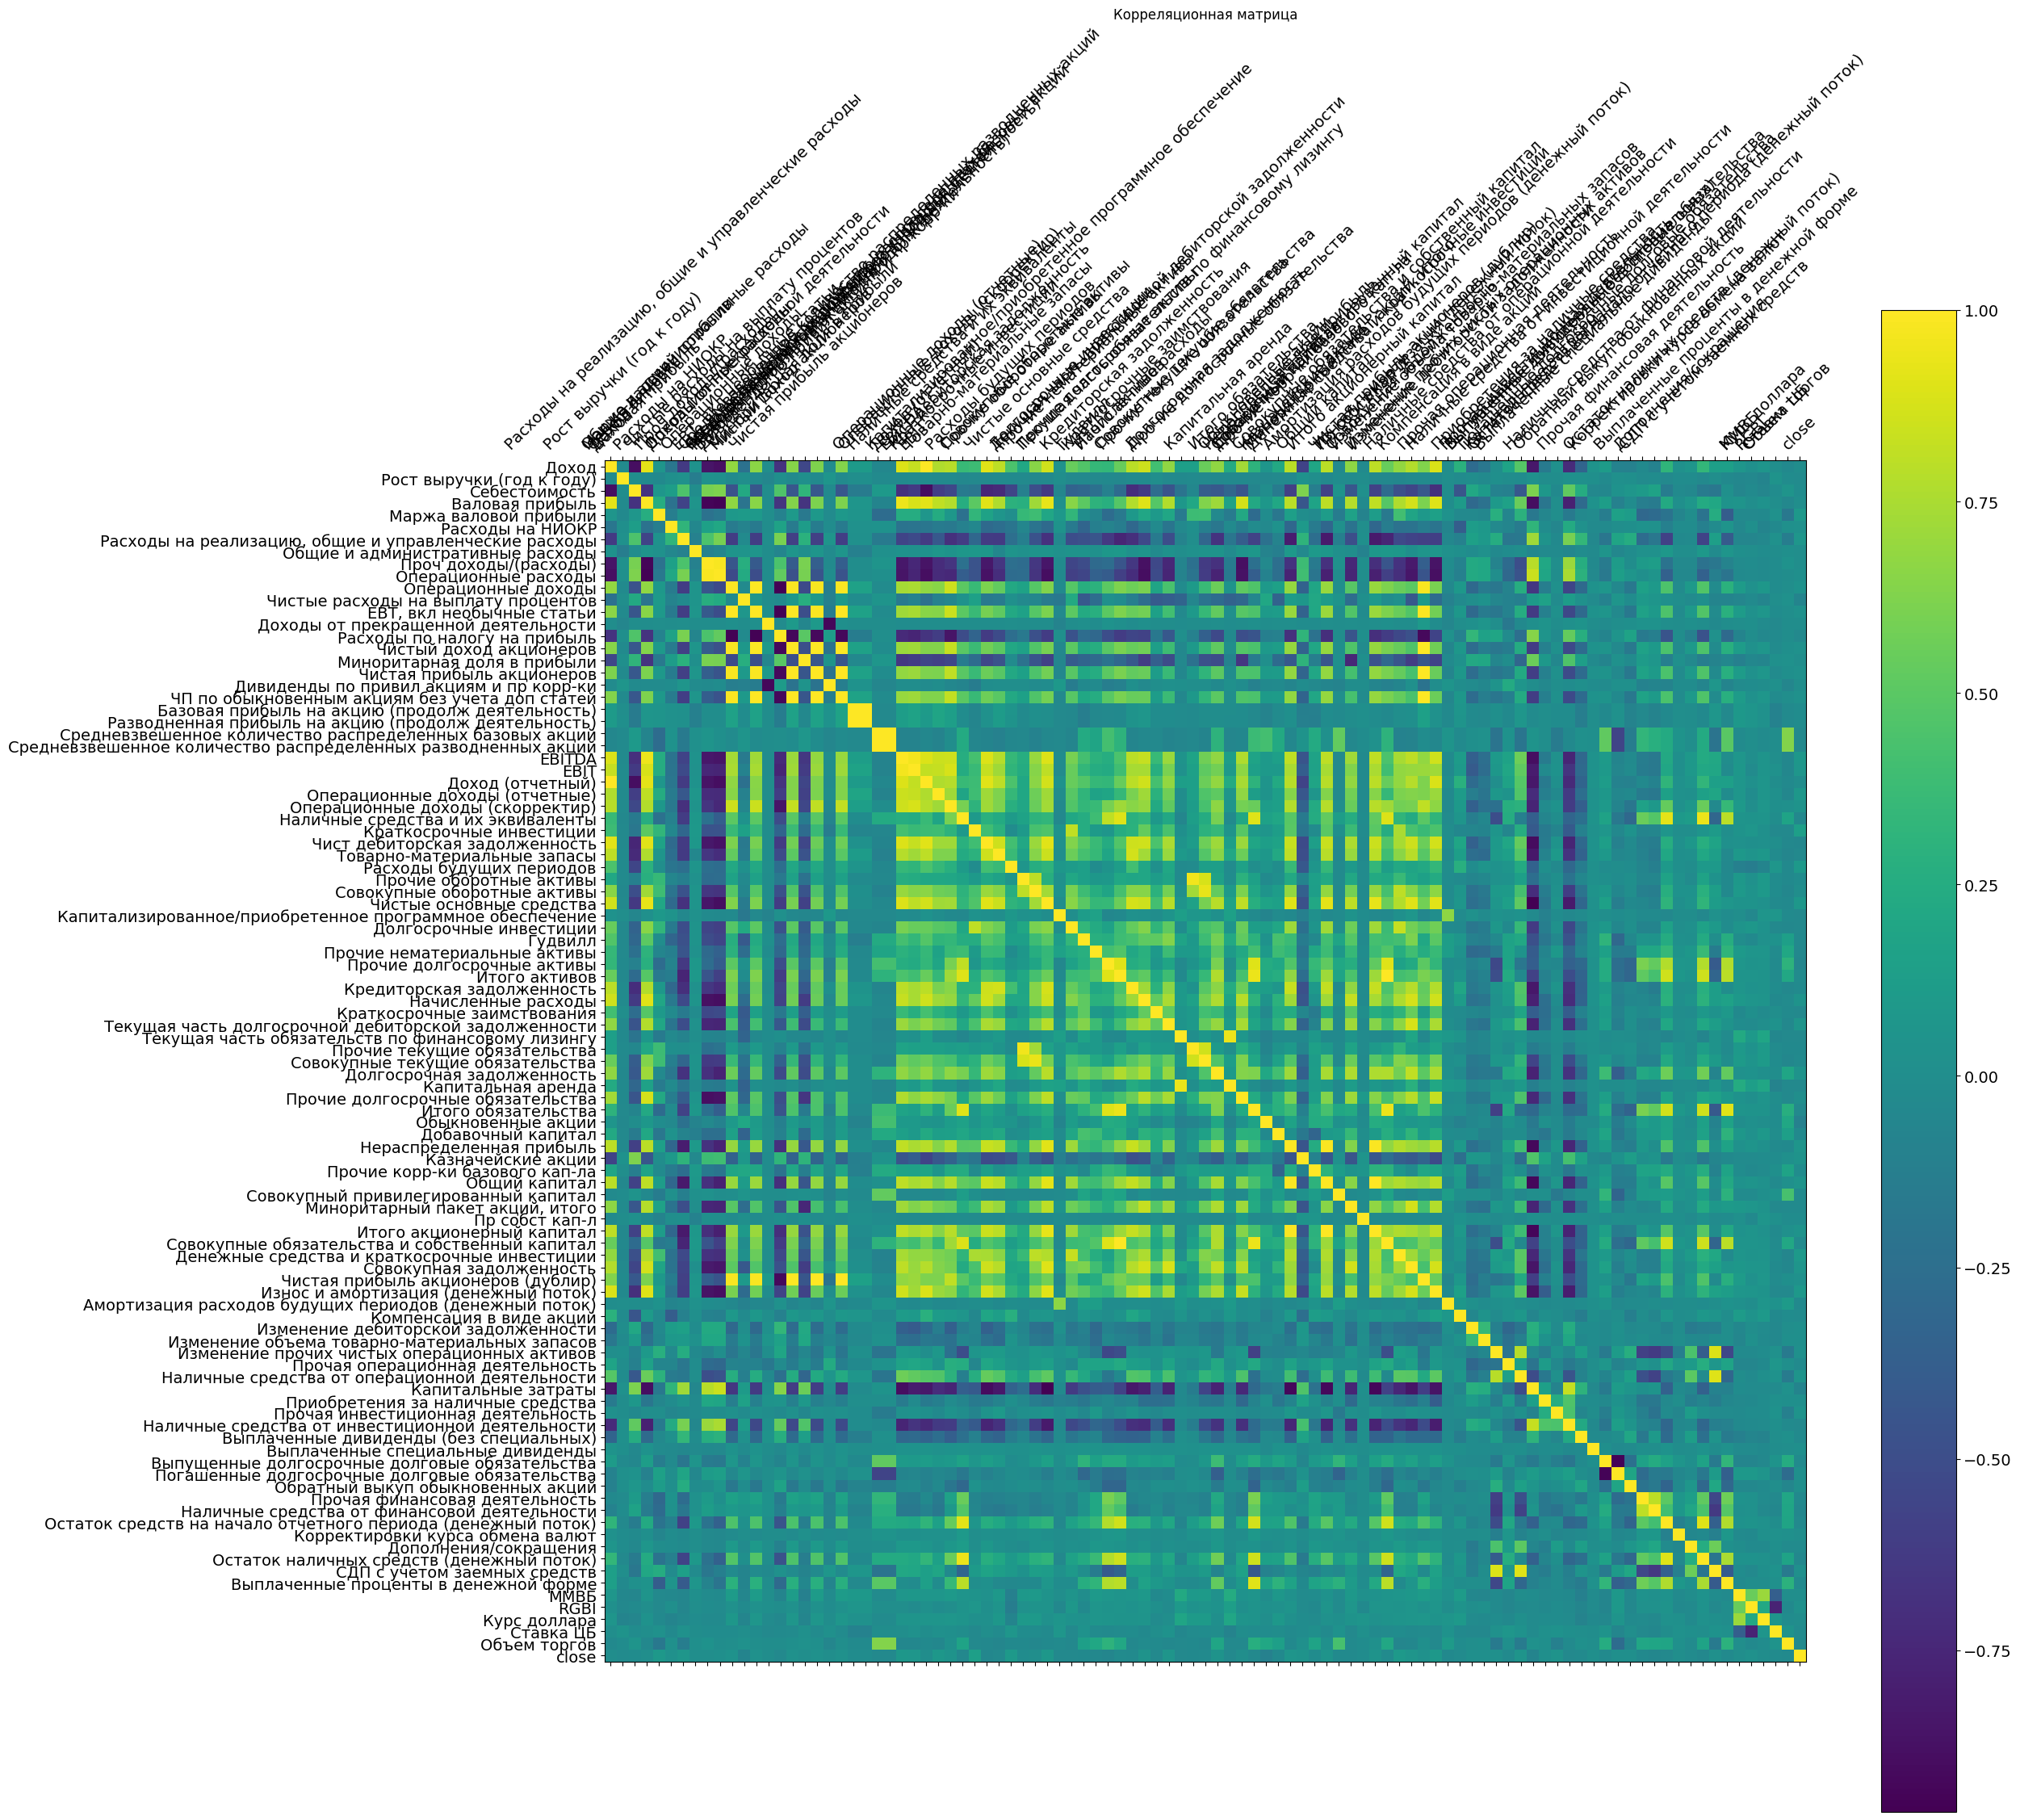

In [ ]:
# построим матрицу корреляции для числовых признаков
f = plt.figure(figsize=(24,24))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Корреляционная матрица')

<ipython-input-24-db516c9e77da>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()[abs(df.corr()['close'])>0.5]['close'].plot(kind='bar')


<Axes: >

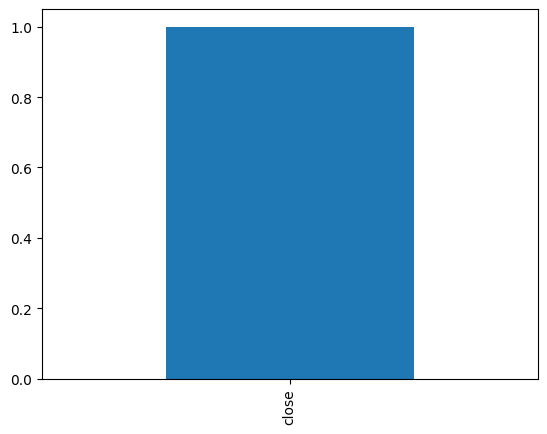

In [ ]:
# смотрим есть ли признаки, которые хорошо коррелируют с таргетом
df.corr()[abs(df.corr()['close'])>0.5]['close'].plot(kind='bar')

Признаков коррелирующих с ценой акции не наблюдается. При этом имеются признаки сильно коррелирующие между собой.

Отчетность составляется таким образом, что имеются признаки суммирующие другие, поэтому исключим такие признаки.

In [ ]:
features = ['Тикер', 'Компания', 'Дата оконч периода', 'Доход', 'Рост выручки (год к году)', 'Себестоимость', 'Маржа валовой прибыли', 'Расходы на НИОКР', 'Расходы на реализацию, общие и управленческие расходы', 'Общие и административные расходы', 'Проч доходы/(расходы)', 'Чистые расходы на выплату процентов', 'Доходы от прекращенной деятельности', 'Расходы по налогу на прибыль', 'Миноритарная доля в прибыли', 'Дивиденды по привил акциям и пр корр-ки', 'Разводненная прибыль на акцию (продолж деятельность)', 'EBITDA', 'Наличные средства и их эквиваленты', 'Краткосрочные инвестиции', 'Чист дебиторская задолженность', 'Товарно-материальные запасы', 'Расходы будущих периодов', 'Прочие оборотные активы', 'Чистые основные средства', 'Капитализированное/приобретенное программное обеспечение', 'Долгосрочные инвестиции', 'Гудвилл', 'Прочие нематериальные активы', 'Прочие долгосрочные активы', 'Кредиторская задолженность', 'Начисленные расходы', 'Краткосрочные заимствования', 'Текущая часть долгосрочной дебиторской задолженности', 'Текущая часть обязательств по финансовому лизингу', 'Прочие текущие обязательства', 'Долгосрочная задолженность', 'Капитальная аренда', 'Прочие долгосрочные обязательства', 'Обыкновенные акции', 'Добавочный капитал', 'Нераспределенная прибыль', 'Казначейские акции', 'Прочие корр-ки базового кап-ла', 'Совокупный привилегированный капитал', 'Миноритарный пакет акций, итого', 'Пр собст кап-л', 'Совокупная задолженность', 'Износ и амортизация (денежный поток)', 'Амортизация расходов будущих периодов (денежный поток)', 'Компенсация в виде акций', 'Изменение дебиторской задолженности', 'Изменение объема товарно-материальных запасов', 'Изменение прочих чистых операционных активов', 'Прочая операционная деятельность', 'Капитальные затраты', 'Приобретения за наличные средства', 'Прочая инвестиционная деятельность', 'Выплаченные дивиденды (без специальных)', 'Выплаченные специальные дивиденды', 'Выпущенные долгосрочные долговые обязательства', 'Погашенные долгосрочные долговые обязательства', 'Обратный выкуп обыкновенных акций', 'Прочая финансовая деятельность', 'Остаток средств на начало отчетного периода (денежный поток)', 'Корректировки курса обмена валют', 'Дополнения/сокращения', 'СДП с учетом заемных средств', 'Выплаченные проценты в денежной форме', 'Дата цены акции', 'ММВБ', 'RGBI', 'Курс доллара', 'Ставка ЦБ', 'Объем торгов', 'close']
df_select = df[features]
df_select

Тикер       Компания Дата оконч периода         Доход  \
0     LKOH  НК Лукойл ПАО         2013-12-31  1.179285e+12   
1     LKOH  НК Лукойл ПАО         2014-03-31  1.255015e+12   
2     LKOH  НК Лукойл ПАО         2014-06-30  1.297675e+12   
3     LKOH  НК Лукойл ПАО         2014-09-30  1.542087e+12   
4     LKOH  НК Лукойл ПАО         2014-12-31  1.424800e+12   
...    ...            ...                ...           ...   
1481  GLTR    ГлобалТранс         2022-06-30  2.420745e+10   
1482  GLTR    ГлобалТранс         2022-09-30  2.302956e+10   
1483  GLTR    ГлобалТранс         2022-12-31  2.302956e+10   
1484  GLTR    ГлобалТранс         2023-03-31  2.598602e+10   
1485  GLTR    ГлобалТранс         2023-06-30  2.598602e+10   

      Рост выручки (год к году)  Себестоимость  Маржа валовой прибыли  \
0                     -0.004000  -8.787799e+11                  0.255   
1                      0.057000  -9.353257e+11                  0.255   
2                      0.090000  -9.620898e+11                  0.259   
3                      0.062000  -1.129623e+12                  0.267   
4                      0.208189  -9.519055e+11                  0.332   
...                         ...            ...                    ...   
1481                   0.509000  -1.372587e+10                  0.433   
1482                   0.121000  -1.323887e+10                  0.425   
1483                   0.121000  -1.323887e+10                  0.425   
1484                   0.073000  -1.478167e+10                  0.431   
1485                   0.073000  -1.478167e+10                  0.431   

      Расходы на НИОКР  Расходы на реализацию, общие и управленческие расходы  \
0         0.000000e+00                                      -4.701765e+10       
1         0.000000e+00                                      -3.731877e+10       
2         0.000000e+00                                      -3.664942e+10       
3         0.000000e+00                                      -4.746280e+10       
4        -1.314000e+09                                      -4.627554e+10       
...                ...                                                ...       
1481      0.000000e+00                                      -5.907950e+07       
1482      0.000000e+00                                      -8.214950e+07       
1483      0.000000e+00                                      -8.214950e+07       
1484      0.000000e+00                                      -8.248600e+07       
1485      0.000000e+00                                      -8.248600e+07       

      Общие и административные расходы  ...  Дополнения/сокращения  \
0                         0.000000e+00  ...          -5.282438e+10   
1                         0.000000e+00  ...           2.707498e+10   
2                         0.000000e+00  ...          -5.966562e+09   
3                         0.000000e+00  ...           3.746666e+10   
4                         0.000000e+00  ...           3.078628e+10   
...                                ...  ...                    ...   
1481                     -1.246604e+09  ...           0.000000e+00   
1482                     -1.066184e+09  ...           0.000000e+00   
1483                     -1.066184e+09  ...           0.000000e+00   
1484                     -1.274372e+09  ...           0.000000e+00   
1485                     -1.274372e+09  ...           0.000000e+00   

      СДП с учетом заемных средств  Выплаченные проценты в денежной форме  \
0                    -3.298793e+10                           6.965578e+09   
1                     9.180205e+09                           8.441568e+08   
2                     5.706305e+09                           9.374644e+09   
3                     2.880964e+10                           1.106543e+09   
4                     4.362866e+09                           2.749033e+09   
...                            ...                                    ...   
1481                  8.954889

<ipython-input-26-88827de43fe6>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df_select.corr(), fignum=f.number)


Text(0.5, 1.0, 'Корреляционная матрица')

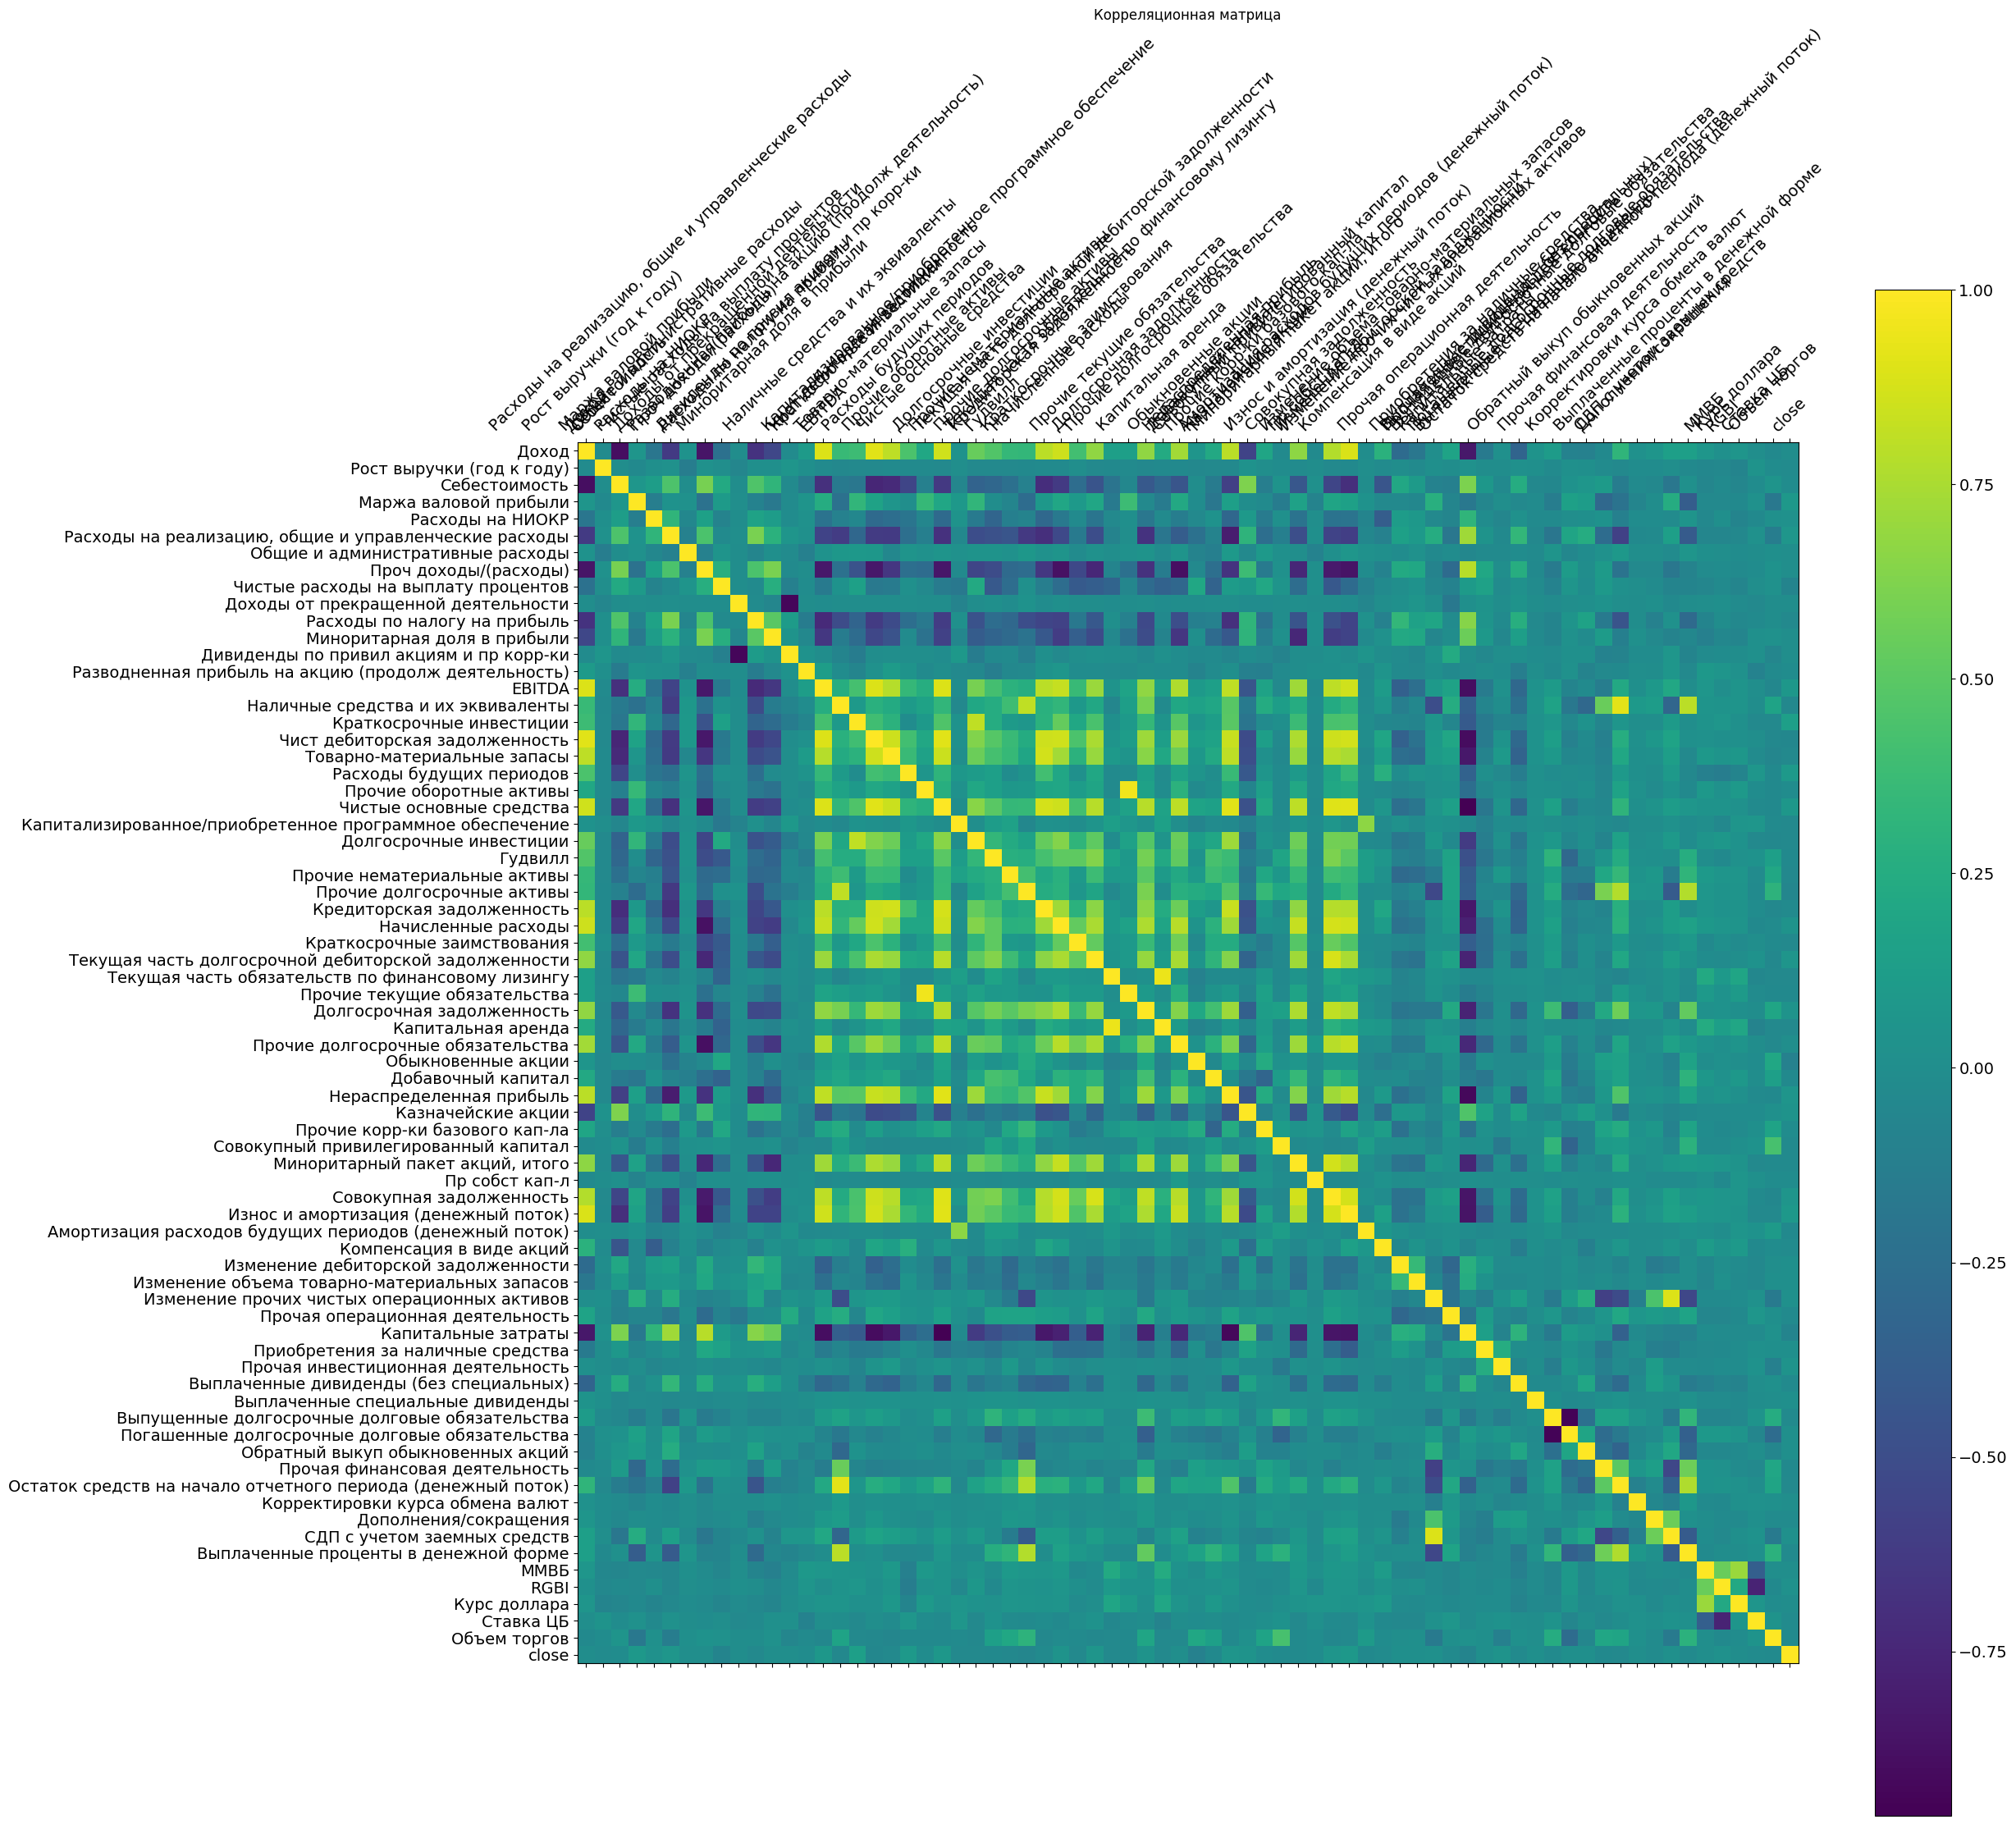

In [ ]:
# построим матрицу корреляции для числовых признаков
f = plt.figure(figsize=(24,24))
plt.matshow(df_select.corr(), fignum=f.number)
plt.xticks(range(df_select.select_dtypes(['number']).shape[1]), df_select.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_select.select_dtypes(['number']).shape[1]), df_select.select_dtypes(['number']).columns, fontsize=14)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Корреляционная матрица')

Удалим оставшиеся скоррелированные признаки автоматическим способом

In [ ]:
!pip install feature-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 6.4 MB/s eta 0:00:00


In [ ]:
from feature_engine.selection import DropCorrelatedFeatures
clear_corr = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.8)
df_not_corr = clear_corr.fit_transform(df_select.drop(columns=['close'], axis=0))

<ipython-input-29-90451e5d805d>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df_not_corr.corr(), fignum=f.number)


Text(0.5, 1.0, 'Корреляционная матрица')

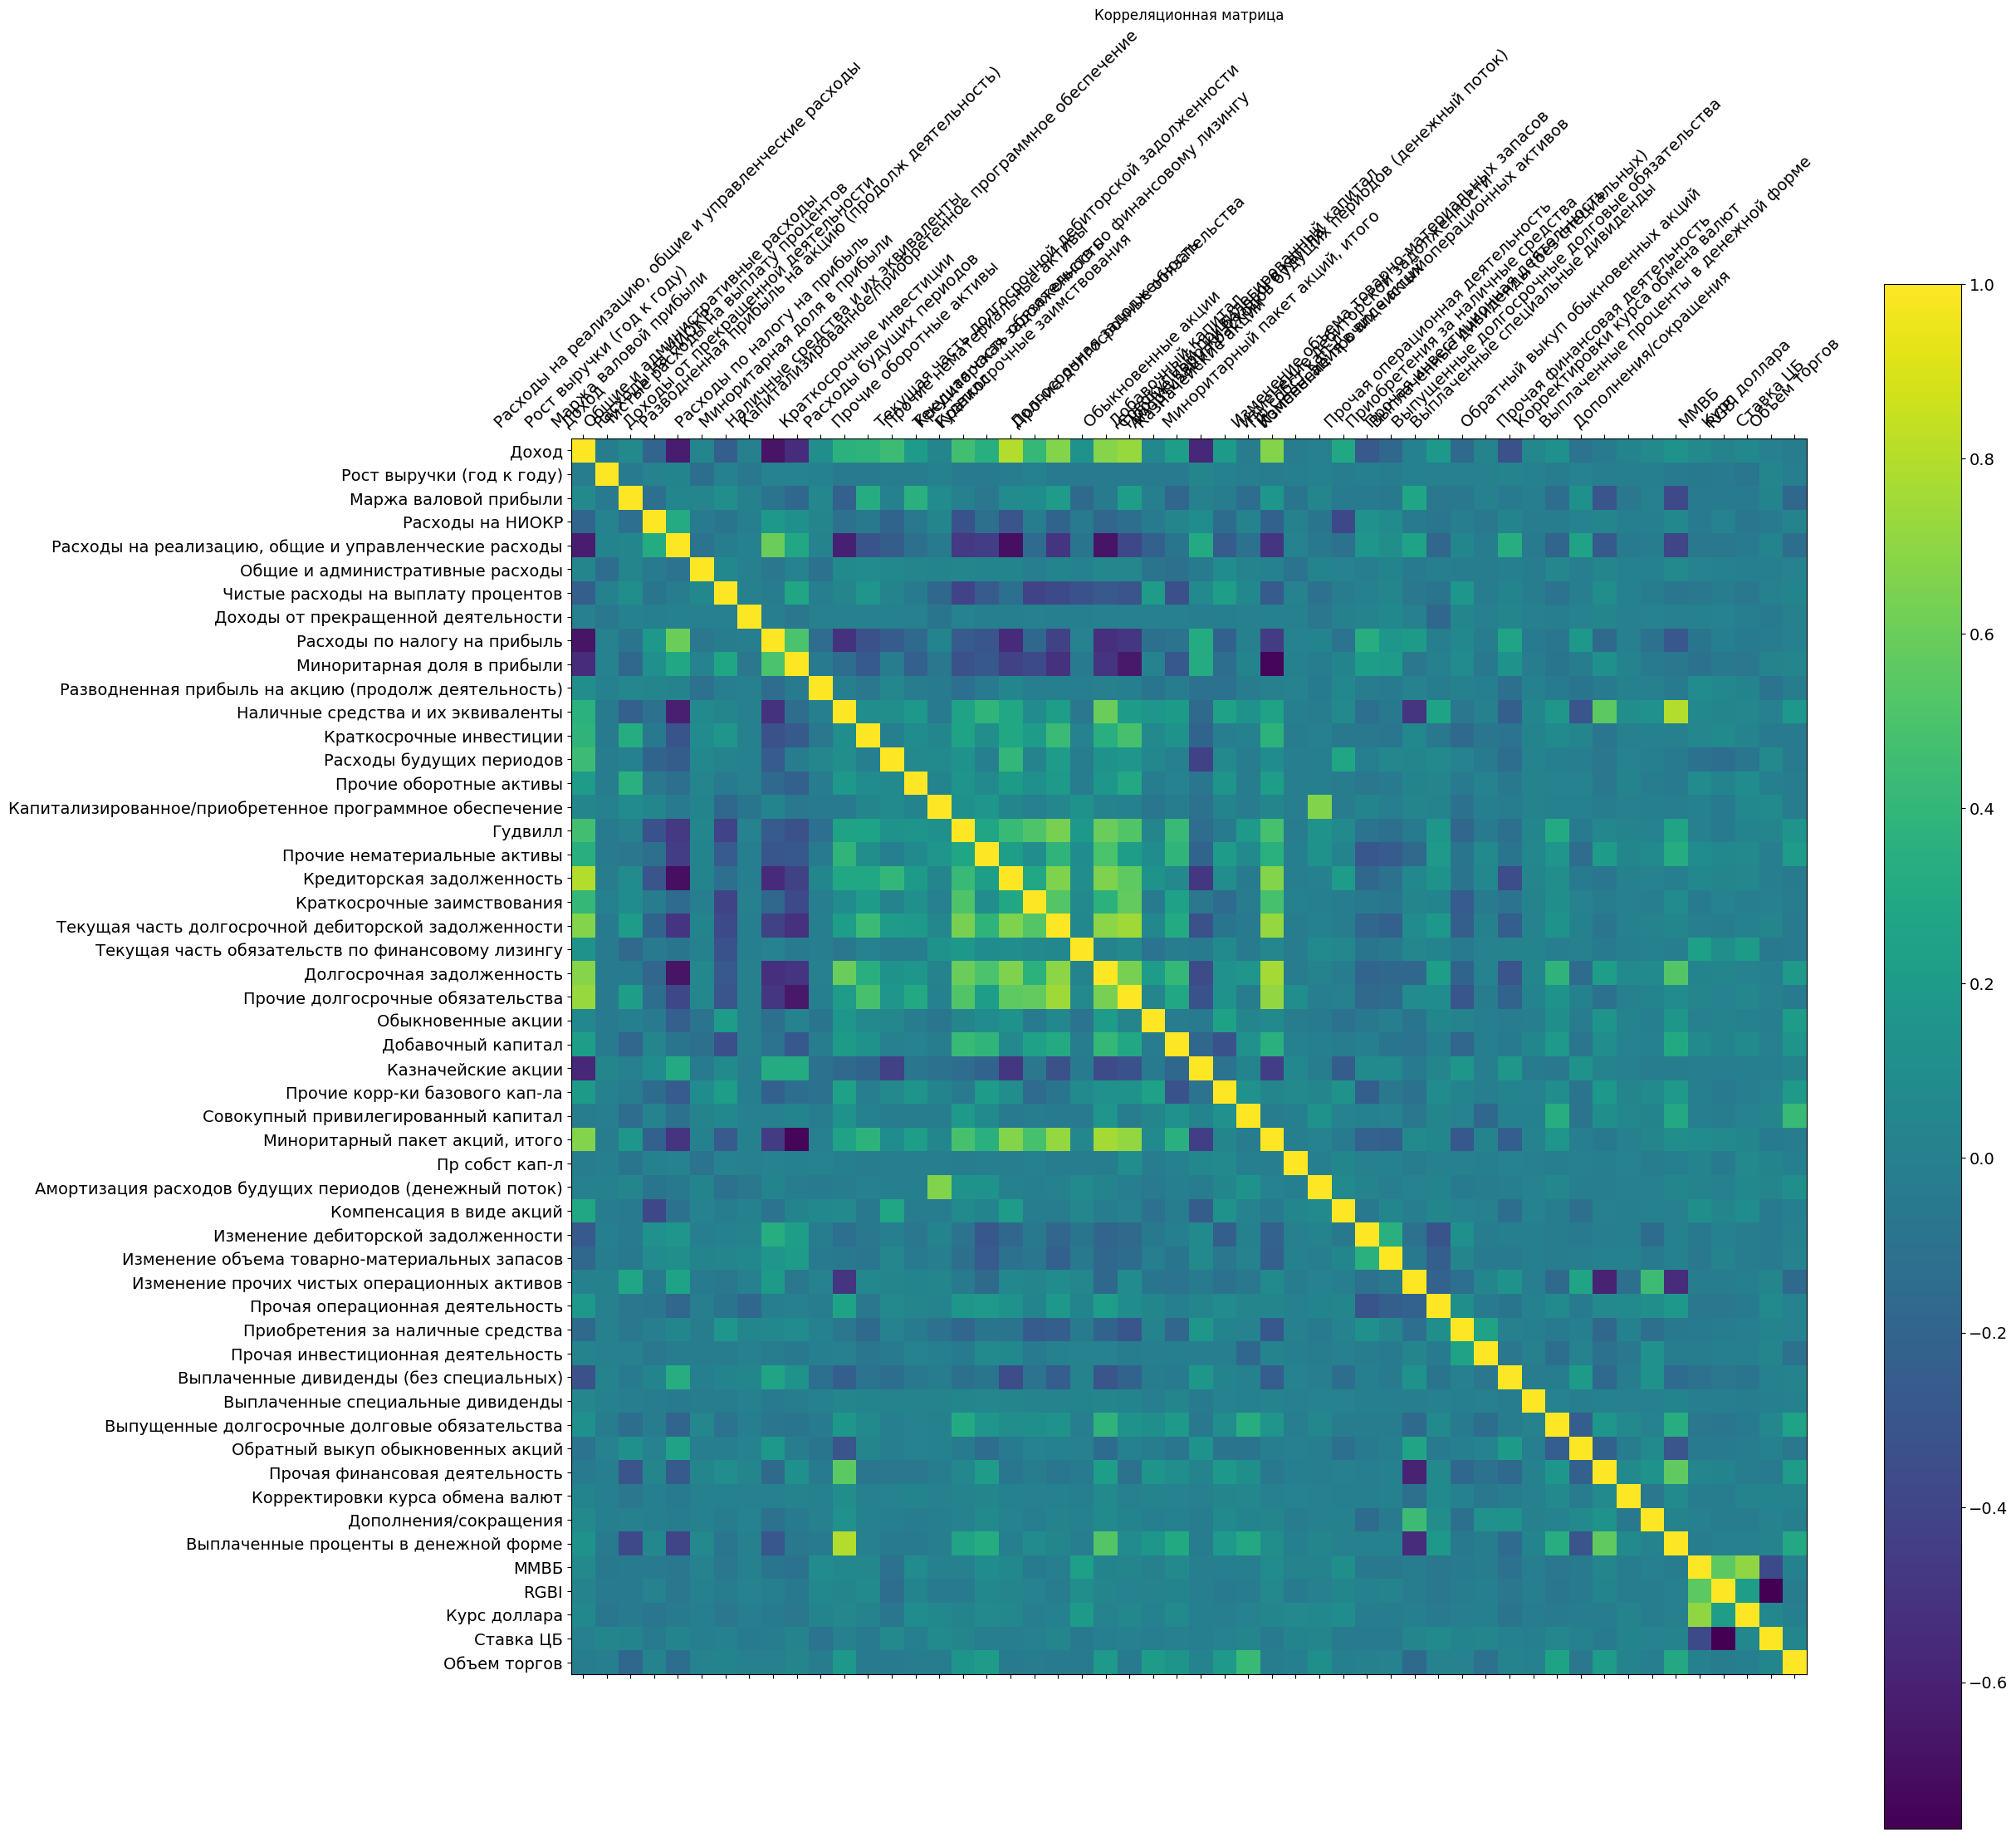

In [ ]:
# построим матрицу корреляции для числовых признаков
f = plt.figure(figsize=(24,24))
plt.matshow(df_not_corr.corr(), fignum=f.number)
plt.xticks(range(df_not_corr.select_dtypes(['number']).shape[1]), df_not_corr.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_not_corr.select_dtypes(['number']).shape[1]), df_not_corr.select_dtypes(['number']).columns, fontsize=14)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Корреляционная матрица')

In [ ]:
list(df_not_corr.columns)

['Тикер',
 'Компания',
 'Дата оконч периода',
 'Доход',
 'Рост выручки (год к году)',
 'Маржа валовой прибыли',
 'Расходы на НИОКР',
 'Расходы на реализацию, общие и управленческие расходы',
 'Общие и административные расходы',
 'Чистые расходы на выплату процентов',
 'Доходы от прекращенной деятельности',
 'Расходы по налогу на прибыль',
 'Миноритарная доля в прибыли',
 'Разводненная прибыль на акцию (продолж деятельность)',
 'Наличные средства и их эквиваленты',
 'Краткосрочные инвестиции',
 'Расходы будущих периодов',
 'Прочие оборотные активы',
 'Капитализированное/приобретенное программное обеспечение',
 'Гудвилл',
 'Прочие нематериальные активы',
 'Кредиторская задолженность',
 'Краткосрочные заимствования',
 'Текущая часть долгосрочной дебиторской задолженности',
 'Текущая часть обязательств по финансовому лизингу',
 'Долгосрочная задолженность',
 'Прочие долгосрочные обязательства',
 'Обыкновенные акции',
 'Добавочный капитал',
 'Казначейские акции',
 'Прочие корр-ки базового к

In [ ]:
features_auto = list(df_not_corr.columns) + ['close']
df_ready = df[features_auto]
df_ready

Тикер       Компания Дата оконч периода         Доход  \
0     LKOH  НК Лукойл ПАО         2013-12-31  1.179285e+12   
1     LKOH  НК Лукойл ПАО         2014-03-31  1.255015e+12   
2     LKOH  НК Лукойл ПАО         2014-06-30  1.297675e+12   
3     LKOH  НК Лукойл ПАО         2014-09-30  1.542087e+12   
4     LKOH  НК Лукойл ПАО         2014-12-31  1.424800e+12   
...    ...            ...                ...           ...   
1481  GLTR    ГлобалТранс         2022-06-30  2.420745e+10   
1482  GLTR    ГлобалТранс         2022-09-30  2.302956e+10   
1483  GLTR    ГлобалТранс         2022-12-31  2.302956e+10   
1484  GLTR    ГлобалТранс         2023-03-31  2.598602e+10   
1485  GLTR    ГлобалТранс         2023-06-30  2.598602e+10   

      Рост выручки (год к году)  Маржа валовой прибыли  Расходы на НИОКР  \
0                     -0.004000                  0.255      0.000000e+00   
1                      0.057000                  0.255      0.000000e+00   
2                      0.090000                  0.259      0.000000e+00   
3                      0.062000                  0.267      0.000000e+00   
4                      0.208189                  0.332     -1.314000e+09   
...                         ...                    ...               ...   
1481                   0.509000                  0.433      0.000000e+00   
1482                   0.121000                  0.425      0.000000e+00   
1483                   0.121000                  0.425      0.000000e+00   
1484                   0.073000                  0.431      0.000000e+00   
1485                   0.073000                  0.431      0.000000e+00   

      Расходы на реализацию, общие и управленческие расходы  \
0                                         -4.701765e+10       
1                                         -3.731877e+10       
2                                         -3.664942e+10       
3                                         -4.746280e+10       
4                                         -4.627554e+10       
...                                                 ...       
1481                                      -5.907950e+07       
1482                                      -8.214950e+07       
1483                                      -8.214950e+07       
1484                                      -8.248600e+07       
1485                                      -8.248600e+07       

      Общие и административные расходы  Чистые расходы на выплату процентов  \
0                         0.000000e+00                        -2.792802e+09   
1                         0.000000e+00                        -2.919376e+09   
2                         0.000000e+00                        -3.124881e+09   
3                         0.000000e+00                        -3.833382e+09   
4                         0.000000e+00                        -1.629973e+09   
...                                ...                                  ...   
1481                     -1.246604e+09                        -5.450130e+08   
1482                     -1.066184e+09                        -3.654490e+08   
1483                     -1.066184e+09                        -3.654490e+08   
1484                     -1.274372e+09                        -3.984030e+08   
1485                     -1.274372e+09                        -3.984030e+08   

      ...  Корректировки курса обмена валют  Дополнения/сокращения  \
0     ...                     -1.642825e+08          -5.282438e+10   
1     ...                     -1.512448e+09           2.707498e+10   
2     ...                      2.241763e+09          -5.966562e+09   
3     ...                     -2.292125e+09           3.746666e+10   
4     ...                      2.497412e+10           3.078628e+10   
...   ...                               ...                    ...   
1481  ...                     -2.533940e+08           0.000000e+00   
1482  ...                      3.498735e+08           0.000000e+00   
1483  ...  

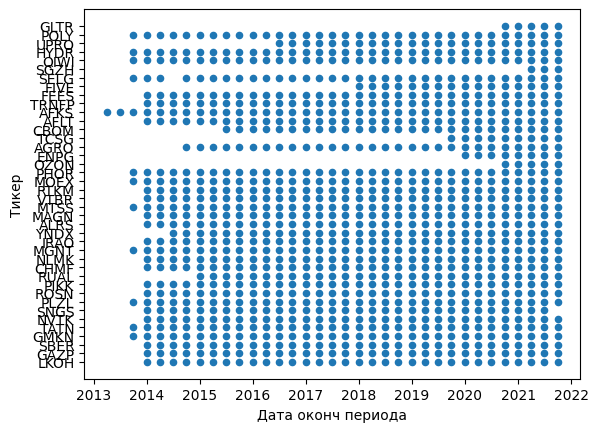

In [ ]:
df_finale = df_ready[(df_ready['Дата цены акции']<'2021-12-31')].copy()
df_finale.plot(kind='scatter', x='Дата оконч периода', y ='Тикер')
plt.show()

<Axes: xlabel='Дата оконч периода', ylabel='Тикер'>

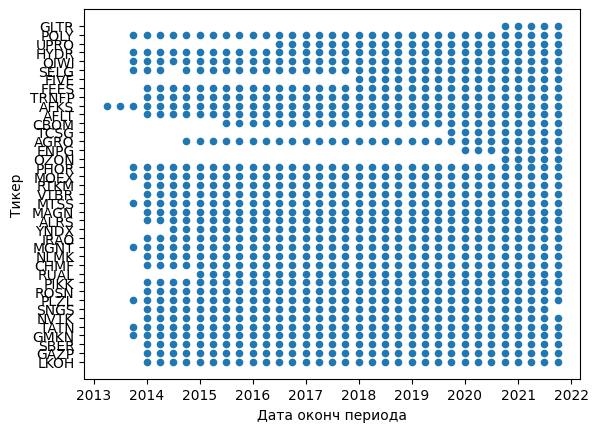

In [ ]:
df_finale = df_finale[(df_finale['Тикер']!='SGZH')]
df_finale.plot(kind='scatter', x='Дата оконч периода', y ='Тикер')

In [ ]:
# сохраним полученный датасет для дальнейшей возможности загрузки,
# чтобы не проводить все операции выше при отключении от colab
df_finale.to_excel('dataset_MOEX_finale.xlsx')

Прежде, чем строить модель для подготовленных данных посмотрим как изменяются от квартала к кварталу, различные финансовые показатели.

<Axes: xlabel='Дата оконч периода'>

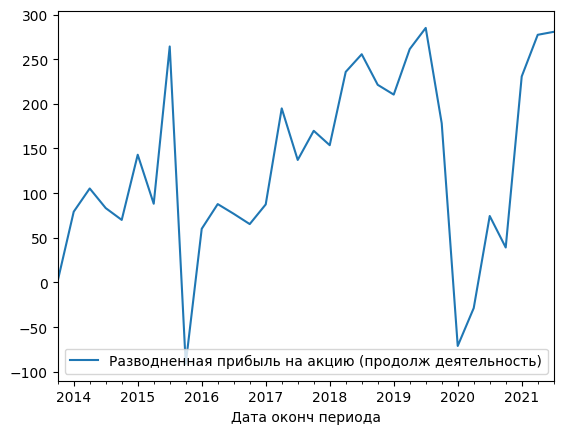

In [ ]:
df_finale[df_finale['Тикер']=='LKOH'][['Дата оконч периода', 'Разводненная прибыль на акцию (продолж деятельность)']].set_index('Дата оконч периода').plot()

<Axes: xlabel='Дата оконч периода'>

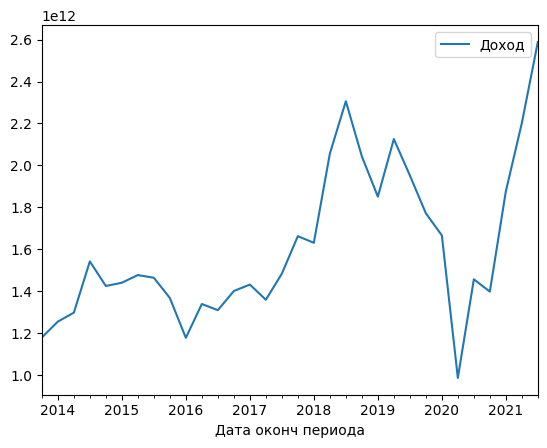

In [ ]:
df_finale[df_finale['Тикер']=='LKOH'][['Дата оконч периода', 'Доход']].set_index('Дата оконч периода').plot()

<Axes: xlabel='Дата оконч периода'>

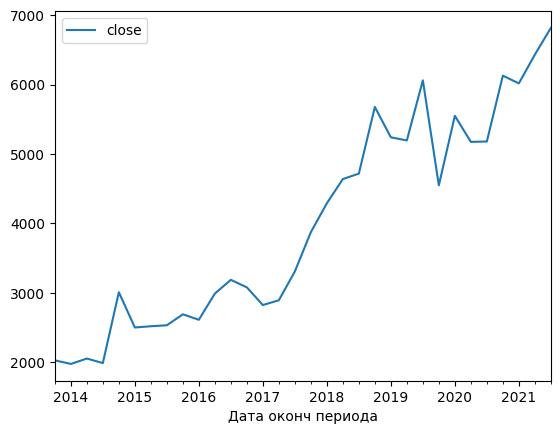

In [ ]:
df_finale[df_finale['Тикер']=='LKOH'][['Дата оконч периода', 'close']].set_index('Дата оконч периода').plot()

<Axes: xlabel='Дата оконч периода'>

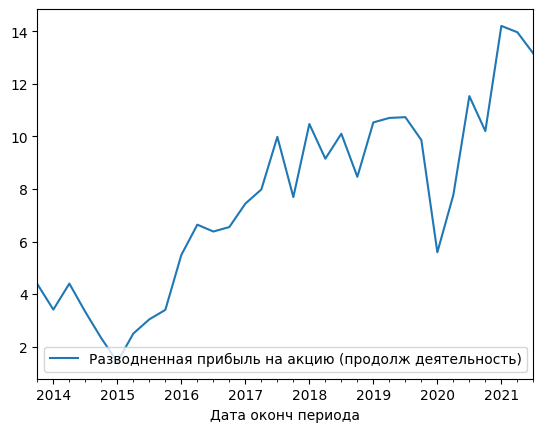

In [ ]:
df_finale[df_finale['Тикер']=='SBER'][['Дата оконч периода', 'Разводненная прибыль на акцию (продолж деятельность)']].set_index('Дата оконч периода').plot()

<Axes: xlabel='Дата оконч периода'>

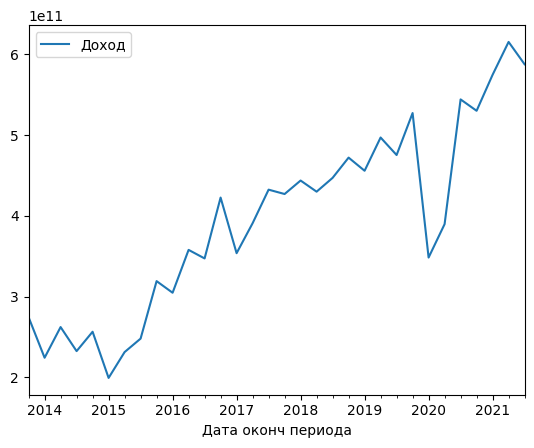

In [ ]:
df_finale[df_finale['Тикер']=='SBER'][['Дата оконч периода', 'Доход']].set_index('Дата оконч периода').plot()

<Axes: xlabel='Дата оконч периода'>

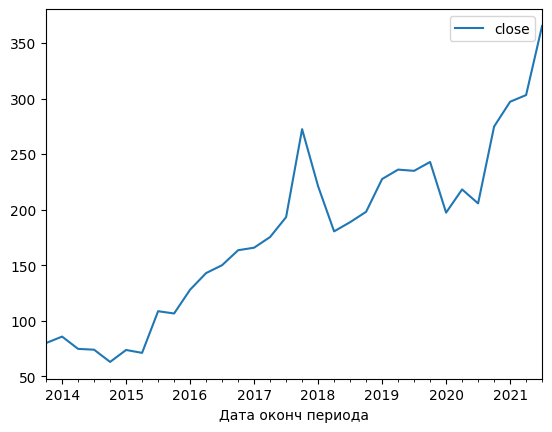

In [ ]:
df_finale[df_finale['Тикер']=='SBER'][['Дата оконч периода', 'close']].set_index('Дата оконч периода').plot()

In [ ]:
df_finale = pd.read_excel('/content/drive/MyDrive/Classroom/DS ИИ RN ПМ/Финальный проект/dataset_MOEX_finale.xlsx')

In [ ]:
df_finale = df_finale.drop(columns=['Компания'])
df_finale

Тикер Дата оконч периода         Доход  Рост выручки (год к году)  \
0     LKOH         2013-12-31  1.179285e+12                  -0.004000   
1     LKOH         2014-03-31  1.255015e+12                   0.057000   
2     LKOH         2014-06-30  1.297675e+12                   0.090000   
3     LKOH         2014-09-30  1.542087e+12                   0.062000   
4     LKOH         2014-12-31  1.424800e+12                   0.208189   
...    ...                ...           ...                        ...   
1113  GLTR         2020-09-30  1.647648e+10                  -0.310000   
1114  GLTR         2020-12-31  1.647648e+10                  -0.310000   
1115  GLTR         2021-03-31  1.603930e+10                  -0.094000   
1116  GLTR         2021-06-30  1.603930e+10                  -0.094000   
1117  GLTR         2021-09-30  2.053620e+10                   0.246000   

      Маржа валовой прибыли  Расходы на НИОКР  \
0                     0.255                 0   
1                     0.255                 0   
2                     0.259                 0   
3                     0.267                 0   
4                     0.332       -1314000000   
...                     ...               ...   
1113                  0.283                 0   
1114                  0.283                 0   
1115                  0.255                 0   
1116                  0.255                 0   
1117                  0.405                 0   

      Расходы на реализацию, общие и управленческие расходы  \
0                                         -4.701765e+10       
1                                         -3.731877e+10       
2                                         -3.664942e+10       
3                                         -4.746280e+10       
4                                         -4.627554e+10       
...                                                 ...       
1113                                      -5.971450e+07       
1114                                      -5.971450e+07       
1115                                      -5.693500e+07       
1116                                      -5.693500e+07       
1117                                      -6.776000e+07       

      Общие и административные расходы  Чистые расходы на выплату процентов  \
0                         0.000000e+00                        -2.792802e+09   
1                         0.000000e+00                        -2.919376e+09   
2                         0.000000e+00                        -3.124881e+09   
3                         0.000000e+00                        -3.833382e+09   
4                         0.000000e+00                        -1.629973e+09   
...                                ...                                  ...   
1113                     -9.889450e+08                        -5.550075e+08   
1114                     -9.889450e+08                        -5.550075e+08   
1115                     -8.602290e+08                        -5.298945e+08   
1116                     -8.602290e+08                        -5.298945e+08   
1117                     -1.162881e+09                        -5.354615e+08   

      Доходы от прекращенной деятельности  ...  \
0                                     0.0  ...   
1                                     0.0  ...   
2                                     0.0  ...   
3                                     0.0  ...   
4                                     0.0  ...   
...                                   ...  ...   
1113                                  0.0  ...   
1114                                  0.0  ...   
1115                                  0.0  ...   
1116                                  0.0  ...   
1117                                  0.0  ...   

      Корректировки курса обмена валют  Дополнения/сокращения  \
0                        -1.642825e+08          -5.282438e+10   
1                        -1.512448e+09           2.707498e+10   
2                        

Удалим символы в названиях колонок, мешающие работать моделям

In [ ]:
df_finale.columns = [c.replace(' ', '_') for c in df_finale.columns]
df_finale.columns = [c.replace('-', '_') for c in df_finale.columns]
df_finale.columns = [c.replace('(', '') for c in df_finale.columns]
df_finale.columns = [c.replace(')', '') for c in df_finale.columns]
df_finale.columns = [c.replace('/', '_') for c in df_finale.columns]
df_finale.columns = [c.replace(',', '_') for c in df_finale.columns]

Посчитаем числове и категориальные признаки

In [ ]:
print('Числовые признаки:', len(df_finale.select_dtypes(include=["float", "int64"]).columns.tolist()))
print('Категориальные признаки:', len(df_finale.select_dtypes(include=["object", "datetime64[ns]"]).columns.tolist()))
# Сохраним числовые признаки
numerical_cols = df_finale.select_dtypes(include=["float", "int64"]).columns.tolist()
# удалим целевой признак из списка числовых
numerical_cols.remove("close")

Числовые признаки: 53
Категориальные признаки: 3


# Кодируем категориальные признаки
Тикеры закодируем с помощью one-hot-encoding, а дату отчетного периода с помощью labelencoder, поскольку важен порядок

In [ ]:
df_finale = pd.get_dummies(df_finale,
                         columns = ['Тикер'])
df_finale

Дата_оконч_периода         Доход  Рост_выручки_год_к_году  \
0            2013-12-31  1.179285e+12                -0.004000   
1            2014-03-31  1.255015e+12                 0.057000   
2            2014-06-30  1.297675e+12                 0.090000   
3            2014-09-30  1.542087e+12                 0.062000   
4            2014-12-31  1.424800e+12                 0.208189   
...                 ...           ...                      ...   
1113         2020-09-30  1.647648e+10                -0.310000   
1114         2020-12-31  1.647648e+10                -0.310000   
1115         2021-03-31  1.603930e+10                -0.094000   
1116         2021-06-30  1.603930e+10                -0.094000   
1117         2021-09-30  2.053620e+10                 0.246000   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                     0.255                 0   
1                     0.255                 0   
2                     0.259                 0   
3                     0.267                 0   
4                     0.332       -1314000000   
...                     ...               ...   
1113                  0.283                 0   
1114                  0.283                 0   
1115                  0.255                 0   
1116                  0.255                 0   
1117                  0.405                 0   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                         -4.701765e+10       
1                                         -3.731877e+10       
2                                         -3.664942e+10       
3                                         -4.746280e+10       
4                                         -4.627554e+10       
...                                                 ...       
1113                                      -5.971450e+07       
1114                                      -5.971450e+07       
1115                                      -5.693500e+07       
1116                                      -5.693500e+07       
1117                                      -6.776000e+07       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                         0.000000e+00                        -2.792802e+09   
1                         0.000000e+00                        -2.919376e+09   
2                         0.000000e+00                        -3.124881e+09   
3                         0.000000e+00                        -3.833382e+09   
4                         0.000000e+00                        -1.629973e+09   
...                                ...                                  ...   
1113                     -9.889450e+08                        -5.550075e+08   
1114                     -9.889450e+08                        -5.550075e+08   
1115                     -8.602290e+08                        -5.298945e+08   
1116                     -8.602290e+08                        -5.298945e+08   
1117                     -1.162881e+09                        -5.354615e+08   

      Доходы_от_прекращенной_деятельности  Расходы_по_налогу_на_прибыль  ...  \
0                                     0.0                 -1.764394e+10  ...   
1                                     0.0                 -2.346052e+10  ...   
2                                     0.0                 -1.599803e+10  ...   
3                                     0.0                 -3.291966e+10  ...   
4                                     0.0                 -3.019093e+10  ...   
...                                   ...                           ...  ...   
1113                                  0.0                 -1.088385e+09  ...   
1114                                  0.0                 -1.088385e+09  ...   
1115                                  0.0                 -6.761000e+08  ...   
1116                                  0.0                 -6.761000e+08  ...   
1117                                 

In [ ]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(df_finale['Дата_оконч_периода'])
df_finale['label_периода'] = enc.transform(df_finale['Дата_оконч_периода'])
df_finale

Дата_оконч_периода         Доход  Рост_выручки_год_к_году  \
0            2013-12-31  1.179285e+12                -0.004000   
1            2014-03-31  1.255015e+12                 0.057000   
2            2014-06-30  1.297675e+12                 0.090000   
3            2014-09-30  1.542087e+12                 0.062000   
4            2014-12-31  1.424800e+12                 0.208189   
...                 ...           ...                      ...   
1113         2020-09-30  1.647648e+10                -0.310000   
1114         2020-12-31  1.647648e+10                -0.310000   
1115         2021-03-31  1.603930e+10                -0.094000   
1116         2021-06-30  1.603930e+10                -0.094000   
1117         2021-09-30  2.053620e+10                 0.246000   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                     0.255                 0   
1                     0.255                 0   
2                     0.259                 0   
3                     0.267                 0   
4                     0.332       -1314000000   
...                     ...               ...   
1113                  0.283                 0   
1114                  0.283                 0   
1115                  0.255                 0   
1116                  0.255                 0   
1117                  0.405                 0   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                         -4.701765e+10       
1                                         -3.731877e+10       
2                                         -3.664942e+10       
3                                         -4.746280e+10       
4                                         -4.627554e+10       
...                                                 ...       
1113                                      -5.971450e+07       
1114                                      -5.971450e+07       
1115                                      -5.693500e+07       
1116                                      -5.693500e+07       
1117                                      -6.776000e+07       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                         0.000000e+00                        -2.792802e+09   
1                         0.000000e+00                        -2.919376e+09   
2                         0.000000e+00                        -3.124881e+09   
3                         0.000000e+00                        -3.833382e+09   
4                         0.000000e+00                        -1.629973e+09   
...                                ...                                  ...   
1113                     -9.889450e+08                        -5.550075e+08   
1114                     -9.889450e+08                        -5.550075e+08   
1115                     -8.602290e+08                        -5.298945e+08   
1116                     -8.602290e+08                        -5.298945e+08   
1117                     -1.162881e+09                        -5.354615e+08   

      Доходы_от_прекращенной_деятельности  Расходы_по_налогу_на_прибыль  ...  \
0                                     0.0                 -1.764394e+10  ...   
1                                     0.0                 -2.346052e+10  ...   
2                                     0.0                 -1.599803e+10  ...   
3                                     0.0                 -3.291966e+10  ...   
4                                     0.0                 -3.019093e+10  ...   
...                                   ...                           ...  ...   
1113                                  0.0                 -1.088385e+09  ...   
1114                                  0.0                 -1.088385e+09  ...   
1115                                  0.0                 -6.761000e+08  ...   
1116                                  0.0                 -6.761000e+08  ...   
1117                                 

# Разбиение на обучающую и тестовую выборки
Разделим данные на обучающую и тестовую выборку с учетом даты квартального отчета

In [ ]:
len(df_finale)

1118

In [ ]:
train = df_finale[(df_finale['Дата_оконч_периода']<='2019-12-31')]
len(train)

850

In [ ]:
test = df_finale[(df_finale['Дата_оконч_периода']>'2019-12-31')]
len(test)

268

In [ ]:
X_train = train.drop(columns=['close', 'Дата_оконч_периода', 'Дата_цены_акции'])
y_train = train['close']

In [ ]:
X_test = test.drop(columns=['close', 'Дата_оконч_периода', 'Дата_цены_акции'])
y_test = test['close']

In [ ]:
list(X_train.columns)

['Доход',
 'Рост_выручки_год_к_году',
 'Маржа_валовой_прибыли',
 'Расходы_на_НИОКР',
 'Расходы_на_реализацию__общие_и_управленческие_расходы',
 'Общие_и_административные_расходы',
 'Чистые_расходы_на_выплату_процентов',
 'Доходы_от_прекращенной_деятельности',
 'Расходы_по_налогу_на_прибыль',
 'Миноритарная_доля_в_прибыли',
 'Разводненная_прибыль_на_акцию_продолж_деятельность',
 'Наличные_средства_и_их_эквиваленты',
 'Краткосрочные_инвестиции',
 'Расходы_будущих_периодов',
 'Прочие_оборотные_активы',
 'Капитализированное_приобретенное_программное_обеспечение',
 'Гудвилл',
 'Прочие_нематериальные_активы',
 'Кредиторская_задолженность',
 'Краткосрочные_заимствования',
 'Текущая_часть_долгосрочной_дебиторской_задолженности',
 'Текущая_часть_обязательств_по_финансовому_лизингу',
 'Долгосрочная_задолженность',
 'Прочие_долгосрочные_обязательства',
 'Обыкновенные_акции',
 'Добавочный_капитал',
 'Казначейские_акции',
 'Прочие_корр_ки_базового_кап_ла',
 'Совокупный_привилегированный_капитал',
 

In [ ]:
len(X_train.columns)

92

# Нормализация признаков

In [ ]:
# импорт библиотеки
from sklearn.preprocessing import StandardScaler

In [ ]:
# выбираю числовые признаки
X_train_num = X_train[numerical_cols]
X_test_num = X_test[numerical_cols]

In [ ]:
# Нормализация признаков
scaler = StandardScaler()
scaler.fit(X_train_num)
X_train_num_norm = pd.DataFrame(scaler.transform(X_train_num), columns=X_train_num.columns, index=X_train_num.index)
X_test_num_norm = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns, index=X_test_num.index)

In [ ]:
X_train_num_norm

Доход  Рост_выручки_год_к_году  Маржа_валовой_прибыли  \
0     2.120766                -0.127867              -0.785547   
1     2.292578                -0.118389              -0.785547   
2     2.389364                -0.113262              -0.769620   
3     2.943877                -0.117613              -0.737767   
4     2.677780                -0.094899              -0.478960   
...        ...                      ...                    ...   
1101 -0.472904                -0.011433              -0.139721   
1102 -0.484701                -0.081722               0.162086   
1103 -0.487280                -0.081722               0.162086   
1104 -0.458763                -0.100402               0.381077   
1105 -0.463576                -0.109540               0.404967   

      Расходы_на_НИОКР  Расходы_на_реализацию__общие_и_управленческие_расходы  \
0             0.231008                                          -0.714562       
1             0.231008                                          -0.458127       
2             0.231008                                          -0.440430       
3             0.231008                                          -0.726331       
4            -0.789143                                          -0.694941       
...                ...                                                ...       
1101          0.231008                                           0.453511       
1102          0.231008                                           0.441805       
1103          0.231008                                           0.444999       
1104          0.231008                                           0.449700       
1105          0.231008                                           0.454717       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                             0.241295                            -0.119556   
1                             0.241295                            -0.133823   
2                             0.241295                            -0.156988   
3                             0.241295                            -0.236851   
4                             0.241295                             0.011520   
...                                ...                                  ...   
1101                          0.241295                             0.072466   
1102                          0.241295                             0.062090   
1103                          0.241295                             0.066992   
1104                          0.241295                             0.078301   
1105                          0.241295                             0.083307   

      Доходы_от_прекращенной_деятельности  Расходы_по_налогу_на_прибыль  \
0                                0.018214                     -0.513096   
1                                0.018214                     -0.851903   
2                                0.018214                     -0.417224   
3                                0.018214                     -1.402884   
4                                0.018214                     -1.243939   
...                                   ...                           ...   
1101                             0.018214                      0.445420   
1102                             0.018214                      0.405686   
1103                             0.018214                      0.409697   
1104                             0.018214                      0.367328   
1105                             0.018214                      0.373634   

      Миноритарная_доля_в_прибыли  ...  Обратный_выкуп_обыкновенных_акций  \
0                        1.782907  ...                           0.138431   
1                        0.203106  ...                           0.138431   
2                        0.145754  ...                           0.138431   
3                        0.150174  ...                           0.138431   
4       

In [ ]:
X_train.drop(columns=numerical_cols)

Тикер_AFKS  Тикер_AFLT  Тикер_AGRO  Тикер_ALRS  Тикер_CBOM  Тикер_CHMF  \
0              0           0           0           0           0           0   
1              0           0           0           0           0           0   
2              0           0           0           0           0           0   
3              0           0           0           0           0           0   
4              0           0           0           0           0           0   
...          ...         ...         ...         ...         ...         ...   
1101           0           0           0           0           0           0   
1102           0           0           0           0           0           0   
1103           0           0           0           0           0           0   
1104           0           0           0           0           0           0   
1105           0           0           0           0           0           0   

      Тикер_ENPG  Тикер_FEES  Тикер_FIVE  Тикер_GAZP  ...  Тикер_SBER  \
0              0           0           0           0  ...           0   
1              0           0           0           0  ...           0   
2              0           0           0           0  ...           0   
3              0           0           0           0  ...           0   
4              0           0           0           0  ...           0   
...          ...         ...         ...         ...  ...         ...   
1101           0           0           0           0  ...           0   
1102           0           0           0           0  ...           0   
1103           0           0           0           0  ...           0   
1104           0           0           0           0  ...           0   
1105           0           0           0           0  ...           0   

      Тикер_SELG  Тикер_SNGS  Тикер_TATN  Тикер_TCSG  Тикер_TRNFP  Тикер_UPRO  \
0              0           0           0           0            0           0   
1              0           0           0           0            0           0   
2              0           0           0           0            0           0   
3              0           0           0           0            0           0   
4              0           0           0           0            0           0   
...          ...         ...         ...         ...          ...         ...   
1101           0           0           0           0            0           0   
1102           0           0           0           0            0           0   
1103           0           0           0           0            0           0   
1104           0           0           0           0            0           0   
1105           0           0           0           0            0           0   

      Тикер_VTBR  Тикер_YNDX  label_периода  
0              0           0              3  
1              0           0              4  
2              0           0              5  
3              0           0              6  
4              0           0              7  
...          ...         ...            ...  
1101           0           0             23  
1102           0           0             24  
1103           0           0             25  
1104           0           0             26  
1105           0           0             27  

[850 rows x 40 columns]

In [ ]:
X_train_norm = pd.concat([X_train_num_norm, X_train.drop(columns=numerical_cols)], axis=1)
X_test_norm = pd.concat([X_test_num_norm, X_test.drop(columns=numerical_cols)], axis=1)

In [ ]:
X_train_norm

Доход  Рост_выручки_год_к_году  Маржа_валовой_прибыли  \
0     2.120766                -0.127867              -0.785547   
1     2.292578                -0.118389              -0.785547   
2     2.389364                -0.113262              -0.769620   
3     2.943877                -0.117613              -0.737767   
4     2.677780                -0.094899              -0.478960   
...        ...                      ...                    ...   
1101 -0.472904                -0.011433              -0.139721   
1102 -0.484701                -0.081722               0.162086   
1103 -0.487280                -0.081722               0.162086   
1104 -0.458763                -0.100402               0.381077   
1105 -0.463576                -0.109540               0.404967   

      Расходы_на_НИОКР  Расходы_на_реализацию__общие_и_управленческие_расходы  \
0             0.231008                                          -0.714562       
1             0.231008                                          -0.458127       
2             0.231008                                          -0.440430       
3             0.231008                                          -0.726331       
4            -0.789143                                          -0.694941       
...                ...                                                ...       
1101          0.231008                                           0.453511       
1102          0.231008                                           0.441805       
1103          0.231008                                           0.444999       
1104          0.231008                                           0.449700       
1105          0.231008                                           0.454717       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                             0.241295                            -0.119556   
1                             0.241295                            -0.133823   
2                             0.241295                            -0.156988   
3                             0.241295                            -0.236851   
4                             0.241295                             0.011520   
...                                ...                                  ...   
1101                          0.241295                             0.072466   
1102                          0.241295                             0.062090   
1103                          0.241295                             0.066992   
1104                          0.241295                             0.078301   
1105                          0.241295                             0.083307   

      Доходы_от_прекращенной_деятельности  Расходы_по_налогу_на_прибыль  \
0                                0.018214                     -0.513096   
1                                0.018214                     -0.851903   
2                                0.018214                     -0.417224   
3                                0.018214                     -1.402884   
4                                0.018214                     -1.243939   
...                                   ...                           ...   
1101                             0.018214                      0.445420   
1102                             0.018214                      0.405686   
1103                             0.018214                      0.409697   
1104                             0.018214                      0.367328   
1105                             0.018214                      0.373634   

      Миноритарная_доля_в_прибыли  ...  Тикер_SBER  Тикер_SELG  Тикер_SNGS  \
0                        1.782907  ...           0           0           0   
1                        0.203106  ...           0           0           0   
2                        0.145754  ...           0           0           0   
3                        0.150174  ...           0           0           0   
4  

# Выбор базовой модели

## Строим модели без нормализации

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
# Создадим экземпляр класса KNeighborsRegressor с числом ближайших соседей (n_neighbors) равным 3
model_knn = KNeighborsRegressor(n_neighbors=4)

# Обучим модель
model_knn.fit(X_train, y_train)

# Сделаем предсказание
y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 1170.0750712313431
MAE train: 484.6736399429412
RMSE test: 3074.5190074881048
RMSE train: 2577.1322259380713
R2 test: 0.9824959924703724
R2 train: 0.9902698096491996
MAPE test: 9.157738151476925
MAPE train: 1.1527480586655163


### Линейная регрессия

In [ ]:
# Импортируем линейную регрессию
from sklearn.linear_model import LinearRegression

In [ ]:
# Создаем модель линейной регрессии
model_lr = LinearRegression()

# Обучаем ее на тренировочной части датасета
model_lr.fit(X_train, y_train)

# Получаем предсказание
y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 3420.070507389665
MAE train: 2180.909664947788
RMSE test: 4742.290501019117
RMSE train: 5217.62649743959
R2 test: 0.9583553290052216
R2 train: 0.9601164408516166
MAPE test: 1881.076685329178
MAPE train: 3199.378399662745


### LightGBM

In [ ]:
# Импортируем LightGBM и построим baseline
import lightgbm as lgb

In [ ]:
LGB = lgb.LGBMRegressor(verbose=0)
LGB.fit(X_train, y_train)
y_train_pred = LGB.predict(X_train)
y_test_pred = LGB.predict(X_test)

In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 1951.1549068880931
MAE train: 525.0596467911845
RMSE test: 4251.913093662653
RMSE train: 2174.262912033288
R2 test: 0.9665225873658695
R2 train: 0.9930741664663185
MAPE test: 114.16227913529737
MAPE train: 247.34591951125282


### DecisionTreeRegressor

In [ ]:
# Импортируем класс DecisionTreeRegressor из модуля tree библиотеки sklear
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Создадим объект класса DecisionTreeRegressor с параметрами по умолчанию
DTR = DecisionTreeRegressor()

# Обучим его на обучающей части датасета при помощи метода fit
DTR.fit(X_train, y_train)

y_train_pred = DTR.predict(X_train)
y_test_pred = DTR.predict(X_test)

In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 1672.4467614888058
MAE train: 0.0
RMSE test: 4914.901012020407
RMSE train: 0.0
R2 test: 0.9552685807655487
R2 train: 1.0
MAPE test: 4.006299993695449
MAPE train: 0.0


### RandomForestRegressor

In [ ]:
# Импортируем класс RandomForestRegressor из модуля ensemble библиотеки sklear
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Создадим объект класса RandomForestRegressor с параметрами по умолчанию
RFR = RandomForestRegressor()
# Обучим его на обучающей части датасета при помощи метода fit
RFR.fit(X_train, y_train)
# Получим предсказание нашего случайного леса при помощи метода predict на обучающем и тестовом датасете
y_train_pred = RFR.predict(X_train)
y_test_pred = RFR.predict(X_test)

In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 1377.9053909630597
MAE train: 228.16891584801186
RMSE test: 3308.3190332413997
RMSE train: 982.1483286670295
R2 test: 0.9797326067681655
R2 train: 0.9985868049843358
MAPE test: 11.085358486037178
MAPE train: 0.7593214782054343


## Строим модели с использованием нормализованных данных

### KNN

In [ ]:
# Создадим экземпляр класса KNeighborsRegressor с числом ближайших соседей (n_neighbors) равным 3
model_knn = KNeighborsRegressor(n_neighbors=4)

# Обучим модель
model_knn.fit(X_train_norm, y_train)

# Сделаем предсказание
y_train_pred = model_knn.predict(X_train_norm)
y_test_pred = model_knn.predict(X_test_norm)

In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 6461.35138116138
MAE train: 1843.27419832
RMSE test: 20195.85912405363
RMSE train: 9574.5914855207
R2 test: 0.244720334845
R2 train: 0.8656961570950968
MAPE test: 89.67519552492654
MAPE train: 13.470815946556627


### Линейная регрессия

In [ ]:
# Создаем модель линейной регрессии
model_lr = LinearRegression()

# Обучаем ее на тренировочной части датасета
model_lr.fit(X_train_norm, y_train)

# Получаем предсказание
y_train_pred = model_lr.predict(X_train_norm)
y_test_pred = model_lr.predict(X_test_norm)

In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 3242.7789672160916
MAE train: 2046.0995757979163
RMSE test: 4555.0406929930095
RMSE train: 5169.552535125
R2 test: 0.9615790898034491
R2 train: 0.9608480101461692
MAPE test: 1656.0034669371912
MAPE train: 3030.7307678679326


### LightGBM

In [ ]:
LGB = lgb.LGBMRegressor(verbose=0)
LGB.fit(X_train_norm, y_train)
y_train_pred = LGB.predict(X_train_norm)
y_test_pred = LGB.predict(X_test_norm)

In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 1949.43069472013
MAE train: 509.4087774342236
RMSE test: 4107.447653208714
RMSE train: 2303.903454398095
R2 test: 0.9687588363712312
R2 train: 0.992223637720615
MAPE test: 92.29338855804781
MAPE train: 243.70197071341744


### DecisionTreeRegressor

In [ ]:
# Создадим объект класса DecisionTreeRegressor с параметрами по умолчанию
DTR = DecisionTreeRegressor()

# Обучим его на обучающей части датасета при помощи метода fit
DTR.fit(X_train_norm, y_train)

y_train_pred = DTR.predict(X_train_norm)
y_test_pred = DTR.predict(X_test_norm)

In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 1879.333100791045
MAE train: 0.0
RMSE test: 5516.818295246344
RMSE train: 0.0
R2 test: 0.943641362282122
R2 train: 1.0
MAPE test: 1.0115963853336625
MAPE train: 0.0


### RandomForestRegressor

In [ ]:
# Создадим объект класса RandomForestRegressor с параметрами по умолчанию
RFR = RandomForestRegressor()
# Обучим его на обучающей части датасета при помощи метода fit
RFR.fit(X_train_norm, y_train)
# Получим предсказание нашего случайного леса при помощи метода predict на обучающем и тестовом датасете
y_train_pred = RFR.predict(X_train_norm)
y_test_pred = RFR.predict(X_test_norm)

In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 1360.9417227560075
MAE train: 228.76074674894116
RMSE test: 3240.157678949442
RMSE train: 971.3076199574768
R2 test: 0.9805591424844503
R2 train: 0.9986178298014661
MAPE test: 4.001489529385874
MAPE train: 0.6766690632050556


# Улучшение моделей

## Линейная регрессия с регуляризацией
Используем регуляризацию L1 и L2, но сначала определим две полезные функции

In [ ]:
def model_train_test(X_train, y_train, X_test, y_test, model):
  """Обучение и тестирование модели на обучающей и тестовой выборке соответственно.

  :param X_train: объекты обучающей выборки
  :param y_train: значения целевой переменной обучающей выборки
  :param X_test: объекты тестовой выборки
  :param y_test: значения целевой переменной тестовой выборки
  :param model: модель, которая обучается и тестируется
  """
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
  print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
  print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
  print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
  print(f'R2 test: {r2_score(y_test, y_test_pred)}')
  print(f'R2 train: {r2_score(y_train, y_train_pred)}')
  print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
  print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

  return y_test_pred

In [ ]:
from sklearn.model_selection import GridSearchCV

def gridsearch(X_train, y_train, model, params, scoring="neg_mean_squared_error", cv=5):
  """Перебор всевозможных гиперпараметров.

  :param X_train: объекты обучающей выборки
  :param y_train: значения целевой переменной обучающей выборки
  :param model: модель, для которой производится подбор гиперпараметров
  :param params: словарь с названиями гиперпараметрамов и всеми наборами значений
  :param scoring: функция, которая будет минимизироваться в ходе кросс-валидации
  :param cv: количество частей, на которые будет поделена выборка

  :return: наилучшие гиперпараметры
  """
  searcher = GridSearchCV(
      model,
      params,
      scoring=scoring,
      cv=cv
  )
  searcher.fit(X_train, y_train)
  best_params = searcher.best_params_

  print("Best hyperparameters:", best_params)
  return best_params

In [ ]:
from sklearn.linear_model import Ridge, Lasso

In [ ]:
best_params_ridge = gridsearch(
    X_train_norm, y_train,
    Ridge(),
    {
        "alpha": np.logspace(-2, 3, 21), # default = 1.0
        "tol": np.logspace(-5, 0, 21), # default=1e-3
    }
)

pred_ridge = model_train_test(
    X_train_norm,
    y_train,
    X_test_norm,
    y_test,
    Ridge(**best_params_ridge)
)

Best hyperparameters: {'alpha': 0.31622776601683794, 'tol': 1e-05}
MAE test: 3197.453214676357
MAE train: 2051.0486849615886
RMSE test: 4521.06615604159
RMSE train: 5191.032107052148
R2 test: 0.9621500900202904
R2 train: 0.9605219799553495
MAPE test: 1559.3488940143895
MAPE train: 3017.006510879362


In [ ]:
best_params_lasso = gridsearch(
    X_train_norm, y_train,
    Lasso(),
    {
        "alpha": np.logspace(-2, 3, 21), # default = 1.0
        "tol": np.logspace(-5, 0, 21), # default=1e-4

    }
)

pred_lasso = model_train_test(
    X_train_norm,
    y_train,
    X_test_norm,
    y_test,
    Lasso(**best_params_lasso)
)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.436e+09, tolerance: 5.754e+06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.208e+09, tolerance: 5.754e+06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.244e+09, tolerance: 5.746e

Best hyperparameters: {'alpha': 100.0, 'tol': 0.0017782794100389228}
MAE test: 2494.691514239014
MAE train: 1932.4172332688443
RMSE test: 3522.47565065741
RMSE train: 5560.273741582123
R2 test: 0.9770237511536469
R2 train: 0.9547060413332353
MAPE test: 610.3834714345434
MAPE train: 1405.8010416639333


## DecisionTreeRegressor

In [ ]:
best_params_dt = gridsearch(
    X_train, y_train,
    DecisionTreeRegressor(),
    {
        "max_depth": [i for i in range(2, 11)], # default = None
        "min_samples_leaf": [i for i in range(1, 41)], # default = 1
        "max_features": [7, "sqrt", "log2"] # default = None
    }
)

pred_dt = model_train_test(
    X_train,
    y_train,
    X_test,
    y_test,
    DecisionTreeRegressor(**best_params_dt)
)

Best hyperparameters: {'max_depth': 5, 'max_features': 7, 'min_samples_leaf': 3}
MAE test: 4989.2914325817665
MAE train: 1337.124452953002
RMSE test: 22241.485668234527
RMSE train: 4951.164116970552
R2 test: 0.08396785525237449
R2 train: 0.9640860992996062
MAPE test: 80.60256794457366
MAPE train: 155.3813642883109


## RandomForestRegressor

In [ ]:
best_params_rf = gridsearch(
    X_train_norm, y_train,
    RandomForestRegressor(),
    {
        "max_depth": [None, 10] + [i for i in range(50, 351, 50)], # default = None
        "n_estimators": [i for i in range(50, 351, 50)], # default = 100
    }
)

pred_rf = model_train_test(
    X_train_norm,
    y_train,
    X_test_norm,
    y_test,
    RandomForestRegressor(**best_params_rf)
)

Best hyperparameters: {'max_depth': 100, 'n_estimators': 100}
MAE test: 1366.8631807336942
MAE train: 220.72671804334112
RMSE test: 3228.8050392141704
RMSE train: 951.8961509755653
R2 test: 0.9806951348822429
R2 train: 0.9986725227878029
MAPE test: 5.933166388817119
MAPE train: 0.720149654071946


## CatBoost

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.7 MB/s eta 0:00:00


In [ ]:
import catboost as cb

In [ ]:
# Воспользуем функцией RandomizedSearchCV
# В качестве определения "лучшей" модели выберем MSE
from sklearn.model_selection import RandomizedSearchCV
random_searcher = RandomizedSearchCV(
            cb.CatBoostRegressor(verbose=0),          # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(2, 200),
                'learning_rate': np.linspace(0.001, 0.3, 100),
            },
            scoring = 'neg_mean_squared_error',
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=10,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
random_searcher.fit(X_train_norm, y_train)

# Выведем набор лучших параметров и лучшую метрику
print(f"Лучшая метрика:   {random_searcher.best_score_}")
print(f"Лучшие параметры: {random_searcher.best_params_}")
y_train_pred = random_searcher.predict(X_train_norm)
y_test_pred = random_searcher.predict(X_test_norm)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 5703, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 2303, in _fit
    train_para

Лучшая метрика:   -701145752.332561
Лучшие параметры: {'max_depth': 7, 'learning_rate': 0.08556565656565657}


In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 1622.8321096034108
MAE train: 9.20002041276699
RMSE test: 2758.6850500373384
RMSE train: 11.757260078126308
R2 test: 0.9859075218694204
R2 train: 0.999999797483607
MAPE test: 416.68422795788456
MAPE train: 8.614212109579173


## LGBM

In [ ]:
# Воспользуем функцией RandomizedSearchCV
# В качестве определения "лучшей" модели выберем MAE

from sklearn.model_selection import RandomizedSearchCV
grid_LGBM = RandomizedSearchCV(
            lgb.LGBMRegressor(verbose=0),          # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(2, 200),
                'learning_rate': np.linspace(0.001, 0.3, 100),
            },
            scoring = 'neg_mean_absolute_error',
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=10,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
grid_LGBM.fit(X_train_norm, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


RandomizedSearchCV(cv=3, estimator=LGBMRegressor(verbose=0), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.001     , 0.0040202 , 0.0070404 , 0.01006061, 0.01308081,
       0.01610101, 0.01912121, 0.02214141, 0.02516162, 0.02818182,
       0.03120202, 0.03422222, 0.03724242, 0.04026263, 0.04328283,
       0.04630303, 0.04932323, 0.05234343, 0.05536364, 0.05838384,
       0.06140404, 0.06442424, 0....
       0.22751515, 0.23053535, 0.23355556, 0.23657576, 0.23959596,
       0.24261616, 0.24563636, 0.24865657, 0.25167677, 0.25469697,
       0.25771717, 0.26073737, 0.26375758, 0.26677778, 0.26979798,
       0.27281818, 0.27583838, 0.27885859, 0.28187879, 0.28489899,
       0.28791919, 0.29093939, 0.2939596 , 0.2969798 , 0.3       ]),
                                        'max_depth': range(2, 200)},
                   return_train_score=True, scoring='neg_mean_absolute_error',
                   verbose=5)

In [ ]:
# Выведем набор лучших параметров и лучшую метрику
print(f"Лучшая метрика:   {grid_LGBM.best_score_}")
print(f"Лучшие параметры: {grid_LGBM.best_params_}")
y_test_pred=grid_LGBM.best_estimator_.predict(X_test_norm)
y_train_pred=grid_LGBM.best_estimator_.predict(X_train_norm)

Лучшая метрика:   -8137.535127511951
Лучшие параметры: {'max_depth': 84, 'learning_rate': 0.11274747474747475}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 1910.6126505917973
MAE train: 480.0737078001502
RMSE test: 4063.3601380963596
RMSE train: 2053.7253609383683
R2 test: 0.9694258945950638
R2 train: 0.9938207941194974
MAPE test: 119.44771002751071
MAPE train: 233.78387188562726


# Относительные изменения вместо нормализации (год к году)

In [ ]:
df_finale = pd.read_excel('/content/drive/MyDrive/Classroom/DS ИИ RN ПМ/Финальный проект/dataset_MOEX_finale.xlsx')
df_finale = df_finale.drop(columns=['Компания'])

In [ ]:
df_finale.columns = [c.replace(' ', '_') for c in df_finale.columns]
df_finale.columns = [c.replace('-', '_') for c in df_finale.columns]
df_finale.columns = [c.replace('(', '') for c in df_finale.columns]
df_finale.columns = [c.replace(')', '') for c in df_finale.columns]
df_finale.columns = [c.replace('/', '_') for c in df_finale.columns]
df_finale.columns = [c.replace(',', '_') for c in df_finale.columns]

In [ ]:
print('Числовые признаки:', len(df_finale.select_dtypes(include=["float", "int64"]).columns.tolist()))
print('Категориальные признаки:', len(df_finale.select_dtypes(include=["object", "datetime64[ns]"]).columns.tolist()))
# Сохраним числовые признаки
numerical_cols = df_finale.select_dtypes(include=["float", "int64"]).columns.tolist()
# добавим тикер в список численных признаков
rel_cols = ["Тикер"] + numerical_cols

Числовые признаки: 53
Категориальные признаки: 3


In [ ]:
# Сохраним категориальные признаки
cat_cols = df_finale.select_dtypes(include=["object", "datetime64[ns]"]).columns.tolist()

В акциях IRAO в начале 2015 года произошел сплит 100 к 1, поэтому умножим значения до конца 2014 года на 100

In [ ]:
df_finale.loc[(df_finale['Тикер']=='IRAO')&(df_finale['Дата_оконч_периода']<'2014-12-31'), 'close'] *=100

In [ ]:
df_finale

Тикер Дата_оконч_периода         Доход  Рост_выручки_год_к_году  \
0     LKOH         2013-12-31  1.179285e+12                -0.004000   
1     LKOH         2014-03-31  1.255015e+12                 0.057000   
2     LKOH         2014-06-30  1.297675e+12                 0.090000   
3     LKOH         2014-09-30  1.542087e+12                 0.062000   
4     LKOH         2014-12-31  1.424800e+12                 0.208189   
...    ...                ...           ...                      ...   
1113  GLTR         2020-09-30  1.647648e+10                -0.310000   
1114  GLTR         2020-12-31  1.647648e+10                -0.310000   
1115  GLTR         2021-03-31  1.603930e+10                -0.094000   
1116  GLTR         2021-06-30  1.603930e+10                -0.094000   
1117  GLTR         2021-09-30  2.053620e+10                 0.246000   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                     0.255                 0   
1                     0.255                 0   
2                     0.259                 0   
3                     0.267                 0   
4                     0.332       -1314000000   
...                     ...               ...   
1113                  0.283                 0   
1114                  0.283                 0   
1115                  0.255                 0   
1116                  0.255                 0   
1117                  0.405                 0   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                         -4.701765e+10       
1                                         -3.731877e+10       
2                                         -3.664942e+10       
3                                         -4.746280e+10       
4                                         -4.627554e+10       
...                                                 ...       
1113                                      -5.971450e+07       
1114                                      -5.971450e+07       
1115                                      -5.693500e+07       
1116                                      -5.693500e+07       
1117                                      -6.776000e+07       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                         0.000000e+00                        -2.792802e+09   
1                         0.000000e+00                        -2.919376e+09   
2                         0.000000e+00                        -3.124881e+09   
3                         0.000000e+00                        -3.833382e+09   
4                         0.000000e+00                        -1.629973e+09   
...                                ...                                  ...   
1113                     -9.889450e+08                        -5.550075e+08   
1114                     -9.889450e+08                        -5.550075e+08   
1115                     -8.602290e+08                        -5.298945e+08   
1116                     -8.602290e+08                        -5.298945e+08   
1117                     -1.162881e+09                        -5.354615e+08   

      Доходы_от_прекращенной_деятельности  ...  \
0                                     0.0  ...   
1                                     0.0  ...   
2                                     0.0  ...   
3                                     0.0  ...   
4                                     0.0  ...   
...                                   ...  ...   
1113                                  0.0  ...   
1114                                  0.0  ...   
1115                                  0.0  ...   
1116                                  0.0  ...   
1117                                  0.0  ...   

      Корректировки_курса_обмена_валют  Дополнения_сокращения  \
0                        -1.642825e+08          -5.282438e+10   
1                        -1.512448e+09           2.707498e+10   
2                         2.241763e+09          -

## Считаем относительные изменения признаков год к году

In [ ]:
# чтобы корректно посчитать относительные изменения нужно заменить нулевые значения на Nan
# предполагается, что в данных нет Nan, иначе после этой операции, невозможно будет отличить пропуски от нулевых значений для дальнейшей повторной замены на 0
df_num = df_finale[rel_cols]
df_num.replace({'0':np.nan, 0:np.nan}, inplace=True)
df_num

<ipython-input-152-d6758a74ed74>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num.replace({'0':np.nan, 0:np.nan}, inplace=True)


Тикер         Доход  Рост_выручки_год_к_году  Маржа_валовой_прибыли  \
0     LKOH  1.179285e+12                -0.004000                  0.255   
1     LKOH  1.255015e+12                 0.057000                  0.255   
2     LKOH  1.297675e+12                 0.090000                  0.259   
3     LKOH  1.542087e+12                 0.062000                  0.267   
4     LKOH  1.424800e+12                 0.208189                  0.332   
...    ...           ...                      ...                    ...   
1113  GLTR  1.647648e+10                -0.310000                  0.283   
1114  GLTR  1.647648e+10                -0.310000                  0.283   
1115  GLTR  1.603930e+10                -0.094000                  0.255   
1116  GLTR  1.603930e+10                -0.094000                  0.255   
1117  GLTR  2.053620e+10                 0.246000                  0.405   

      Расходы_на_НИОКР  Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                  NaN                                      -4.701765e+10       
1                  NaN                                      -3.731877e+10       
2                  NaN                                      -3.664942e+10       
3                  NaN                                      -4.746280e+10       
4        -1.314000e+09                                      -4.627554e+10       
...                ...                                                ...       
1113               NaN                                      -5.971450e+07       
1114               NaN                                      -5.971450e+07       
1115               NaN                                      -5.693500e+07       
1116               NaN                                      -5.693500e+07       
1117               NaN                                      -6.776000e+07       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                        -2.792802e+09   
1                                  NaN                        -2.919376e+09   
2                                  NaN                        -3.124881e+09   
3                                  NaN                        -3.833382e+09   
4                                  NaN                        -1.629973e+09   
...                                ...                                  ...   
1113                     -9.889450e+08                        -5.550075e+08   
1114                     -9.889450e+08                        -5.550075e+08   
1115                     -8.602290e+08                        -5.298945e+08   
1116                     -8.602290e+08                        -5.298945e+08   
1117                     -1.162881e+09                        -5.354615e+08   

      Доходы_от_прекращенной_деятельности  Расходы_по_налогу_на_прибыль  ...  \
0                                     NaN                 -1.764394e+10  ...   
1                                     NaN                 -2.346052e+10  ...   
2                                     NaN                 -1.599803e+10  ...   
3                                     NaN                 -3.291966e+10  ...   
4                                     NaN                 -3.019093e+10  ...   
...                                   ...                           ...  ...   
1113                                  NaN                 -1.088385e+09  ...   
1114                                  NaN                 -1.088385e+09  ...   
1115                                  NaN                 -6.761000e+08  ...   
1116                                  NaN                 -6.761000e+08  ...   
1117                                  NaN                 -1.493138e+09  ...   

      Прочая_финансовая_деятельность  Корректировки_курса_обмена_валют  \
0                      -2.037103e+10                     -1.642825e+08   
1                       7.034640e+07                     -1.5

In [ ]:
df_change = df_num.groupby('Тикер').pct_change(periods=4)
df_change

Доход  Рост_выручки_год_к_году  Маржа_валовой_прибыли  \
0          NaN                      NaN                    NaN   
1          NaN                      NaN                    NaN   
2          NaN                      NaN                    NaN   
3          NaN                      NaN                    NaN   
4     0.208189               -53.047264               0.301961   
...        ...                      ...                    ...   
1113       NaN                      NaN                    NaN   
1114       NaN                      NaN                    NaN   
1115       NaN                      NaN                    NaN   
1116       NaN                      NaN                    NaN   
1117  0.246395                -1.793548               0.431095   

      Расходы_на_НИОКР  Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                  NaN                                                NaN       
1                  NaN                                                NaN       
2                  NaN                                                NaN       
3                  NaN                                                NaN       
4                  NaN                                          -0.015784       
...                ...                                                ...       
1113               NaN                                                NaN       
1114               NaN                                                NaN       
1115               NaN                                                NaN       
1116               NaN                                                NaN       
1117               NaN                                           0.134733       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   
4                                  NaN                            -0.416367   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                               NaN                                  NaN   
1115                               NaN                                  NaN   
1116                               NaN                                  NaN   
1117                           0.17588                            -0.035218   

      Доходы_от_прекращенной_деятельности  Расходы_по_налогу_на_прибыль  \
0                                     NaN                           NaN   
1                                     NaN                           NaN   
2                                     NaN                           NaN   
3                                     NaN                           NaN   
4                                     NaN                      0.711122   
...                                   ...                           ...   
1113                                  NaN                           NaN   
1114                                  NaN                           NaN   
1115                                  NaN                           NaN   
1116                                  NaN                           NaN   
1117                                  NaN                      0.371884   

      Миноритарная_доля_в_прибыли  ...  Прочая_финансовая_деятельность  \
0                             NaN  ...                             NaN   
1                             NaN  ...                             NaN   
2                             NaN  ...                             NaN   
3                             NaN  ...                             NaN   
4                      

In [ ]:
# при подсчете относительного изменения могло произойти деление на ноль, поэтому меняем inf на Nan
df_change.replace([np.inf, -np.inf], np.nan, inplace=True)
df_change

Доход  Рост_выручки_год_к_году  Маржа_валовой_прибыли  \
0          NaN                      NaN                    NaN   
1          NaN                      NaN                    NaN   
2          NaN                      NaN                    NaN   
3          NaN                      NaN                    NaN   
4     0.208189               -53.047264               0.301961   
...        ...                      ...                    ...   
1113       NaN                      NaN                    NaN   
1114       NaN                      NaN                    NaN   
1115       NaN                      NaN                    NaN   
1116       NaN                      NaN                    NaN   
1117  0.246395                -1.793548               0.431095   

      Расходы_на_НИОКР  Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                  NaN                                                NaN       
1                  NaN                                                NaN       
2                  NaN                                                NaN       
3                  NaN                                                NaN       
4                  NaN                                          -0.015784       
...                ...                                                ...       
1113               NaN                                                NaN       
1114               NaN                                                NaN       
1115               NaN                                                NaN       
1116               NaN                                                NaN       
1117               NaN                                           0.134733       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   
4                                  NaN                            -0.416367   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                               NaN                                  NaN   
1115                               NaN                                  NaN   
1116                               NaN                                  NaN   
1117                           0.17588                            -0.035218   

      Доходы_от_прекращенной_деятельности  Расходы_по_налогу_на_прибыль  \
0                                     NaN                           NaN   
1                                     NaN                           NaN   
2                                     NaN                           NaN   
3                                     NaN                           NaN   
4                                     NaN                      0.711122   
...                                   ...                           ...   
1113                                  NaN                           NaN   
1114                                  NaN                           NaN   
1115                                  NaN                           NaN   
1116                                  NaN                           NaN   
1117                                  NaN                      0.371884   

      Миноритарная_доля_в_прибыли  ...  Прочая_финансовая_деятельность  \
0                             NaN  ...                             NaN   
1                             NaN  ...                             NaN   
2                             NaN  ...                             NaN   
3                             NaN  ...                             NaN   
4                      

In [ ]:
df_rel = pd.concat([df_finale[cat_cols], df_change], axis=1)
df_rel

Тикер Дата_оконч_периода Дата_цены_акции     Доход  \
0     LKOH         2013-12-31      2014-02-19       NaN   
1     LKOH         2014-03-31      2014-05-29       NaN   
2     LKOH         2014-06-30      2014-08-29       NaN   
3     LKOH         2014-09-30      2014-10-21       NaN   
4     LKOH         2014-12-31      2015-03-03  0.208189   
...    ...                ...             ...       ...   
1113  GLTR         2020-09-30      2020-12-01       NaN   
1114  GLTR         2020-12-31      2021-04-02       NaN   
1115  GLTR         2021-03-31      2021-06-01       NaN   
1116  GLTR         2021-06-30      2021-08-31       NaN   
1117  GLTR         2021-09-30      2021-12-01  0.246395   

      Рост_выручки_год_к_году  Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                         NaN                    NaN               NaN   
1                         NaN                    NaN               NaN   
2                         NaN                    NaN               NaN   
3                         NaN                    NaN               NaN   
4                  -53.047264               0.301961               NaN   
...                       ...                    ...               ...   
1113                      NaN                    NaN               NaN   
1114                      NaN                    NaN               NaN   
1115                      NaN                    NaN               NaN   
1116                      NaN                    NaN               NaN   
1117                -1.793548               0.431095               NaN   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                                   NaN       
1                                                   NaN       
2                                                   NaN       
3                                                   NaN       
4                                             -0.015784       
...                                                 ...       
1113                                                NaN       
1114                                                NaN       
1115                                                NaN       
1116                                                NaN       
1117                                           0.134733       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   
4                                  NaN                            -0.416367   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                               NaN                                  NaN   
1115                               NaN                                  NaN   
1116                               NaN                                  NaN   
1117                           0.17588                            -0.035218   

      ...  Прочая_финансовая_деятельность  Корректировки_курса_обмена_валют  \
0     ...                             NaN                               NaN   
1     ...                             NaN                               NaN   
2     ...                             NaN                               NaN   
3     ...                             NaN                               NaN   
4     ...                        1.135371                       -153.019366   
...   ...                             ...                               ...   
1113  ...                             NaN                               NaN   
1114  ...                             NaN                            

## Кодируем категориальные признаки

In [ ]:
# Тикеры закодируем с помощью one-hot-encoding
df_rel = pd.get_dummies(df_rel,
                         columns = ['Тикер'])
df_rel

Дата_оконч_периода Дата_цены_акции     Доход  Рост_выручки_год_к_году  \
0            2013-12-31      2014-02-19       NaN                      NaN   
1            2014-03-31      2014-05-29       NaN                      NaN   
2            2014-06-30      2014-08-29       NaN                      NaN   
3            2014-09-30      2014-10-21       NaN                      NaN   
4            2014-12-31      2015-03-03  0.208189               -53.047264   
...                 ...             ...       ...                      ...   
1113         2020-09-30      2020-12-01       NaN                      NaN   
1114         2020-12-31      2021-04-02       NaN                      NaN   
1115         2021-03-31      2021-06-01       NaN                      NaN   
1116         2021-06-30      2021-08-31       NaN                      NaN   
1117         2021-09-30      2021-12-01  0.246395                -1.793548   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                       NaN               NaN   
1                       NaN               NaN   
2                       NaN               NaN   
3                       NaN               NaN   
4                  0.301961               NaN   
...                     ...               ...   
1113                    NaN               NaN   
1114                    NaN               NaN   
1115                    NaN               NaN   
1116                    NaN               NaN   
1117               0.431095               NaN   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                                   NaN       
1                                                   NaN       
2                                                   NaN       
3                                                   NaN       
4                                             -0.015784       
...                                                 ...       
1113                                                NaN       
1114                                                NaN       
1115                                                NaN       
1116                                                NaN       
1117                                           0.134733       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   
4                                  NaN                            -0.416367   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                               NaN                                  NaN   
1115                               NaN                                  NaN   
1116                               NaN                                  NaN   
1117                           0.17588                            -0.035218   

      Доходы_от_прекращенной_деятельности  ...  Тикер_RUAL  Тикер_SBER  \
0                                     NaN  ...           0           0   
1                                     NaN  ...           0           0   
2                                     NaN  ...           0           0   
3                                     NaN  ...           0           0   
4                                     NaN  ...           0           0   
...                                   ...  ...         ...         ...   
1113                                  NaN  ...           0           0   
1114                                  NaN  ...           0           0   
1115                                  NaN  ...           0           0   
1116                             

In [ ]:
# Дату отчетного периода закодируем с помощью labelencoder, поскольку важен порядок
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(df_rel['Дата_оконч_периода'])
df_rel['label_периода'] = enc.transform(df_rel['Дата_оконч_периода'])
df_rel

Дата_оконч_периода Дата_цены_акции     Доход  Рост_выручки_год_к_году  \
0            2013-12-31      2014-02-19       NaN                      NaN   
1            2014-03-31      2014-05-29       NaN                      NaN   
2            2014-06-30      2014-08-29       NaN                      NaN   
3            2014-09-30      2014-10-21       NaN                      NaN   
4            2014-12-31      2015-03-03  0.208189               -53.047264   
...                 ...             ...       ...                      ...   
1113         2020-09-30      2020-12-01       NaN                      NaN   
1114         2020-12-31      2021-04-02       NaN                      NaN   
1115         2021-03-31      2021-06-01       NaN                      NaN   
1116         2021-06-30      2021-08-31       NaN                      NaN   
1117         2021-09-30      2021-12-01  0.246395                -1.793548   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                       NaN               NaN   
1                       NaN               NaN   
2                       NaN               NaN   
3                       NaN               NaN   
4                  0.301961               NaN   
...                     ...               ...   
1113                    NaN               NaN   
1114                    NaN               NaN   
1115                    NaN               NaN   
1116                    NaN               NaN   
1117               0.431095               NaN   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                                   NaN       
1                                                   NaN       
2                                                   NaN       
3                                                   NaN       
4                                             -0.015784       
...                                                 ...       
1113                                                NaN       
1114                                                NaN       
1115                                                NaN       
1116                                                NaN       
1117                                           0.134733       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   
4                                  NaN                            -0.416367   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                               NaN                                  NaN   
1115                               NaN                                  NaN   
1116                               NaN                                  NaN   
1117                           0.17588                            -0.035218   

      Доходы_от_прекращенной_деятельности  ...  Тикер_SBER  Тикер_SELG  \
0                                     NaN  ...           0           0   
1                                     NaN  ...           0           0   
2                                     NaN  ...           0           0   
3                                     NaN  ...           0           0   
4                                     NaN  ...           0           0   
...                                   ...  ...         ...         ...   
1113                                  NaN  ...           0           0   
1114                                  NaN  ...           0           0   
1115                                  NaN  ...           0           0   
1116                             

## Чистим данные после вычисления относительных изменений

Посмотрим на распределение целевой метрики

<Axes: >

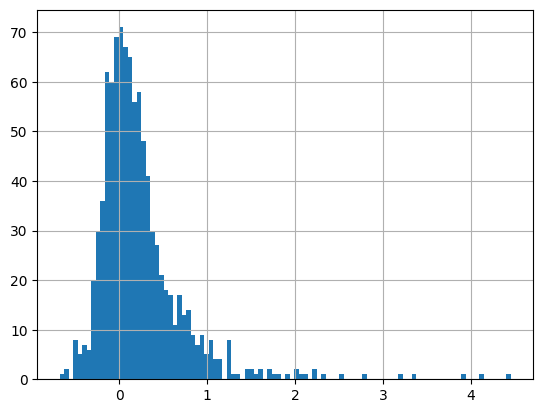

In [ ]:
df_rel.close.hist(bins=100)

<Axes: >

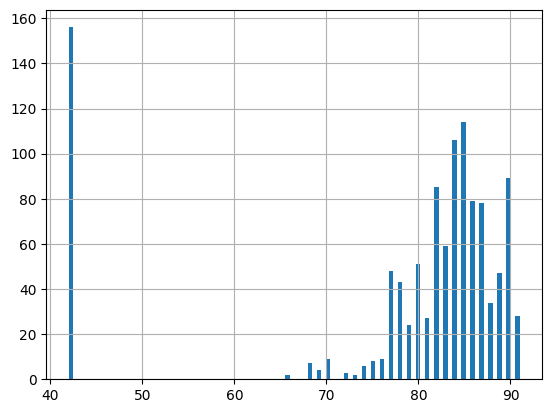

In [ ]:
df_rel.notna().sum(axis=1).hist(bins=100)

In [ ]:
# Удаляю строки которые при вычислении относительных изменений получились Nan
df_rel = df_rel.dropna(thresh=43)

In [ ]:
df_rel

Дата_оконч_периода Дата_цены_акции     Доход  Рост_выручки_год_к_году  \
4            2014-12-31      2015-03-03  0.208189               -53.047264   
5            2015-03-31      2015-05-25  0.147640                 1.590170   
6            2015-06-30      2015-08-28  0.138163                 0.535149   
7            2015-09-30      2015-11-30 -0.050603                -1.816170   
8            2015-12-31      2016-04-04 -0.040057                -1.192409   
...                 ...             ...       ...                      ...   
1109         2020-12-31      2021-04-02  0.594910                 4.220253   
1110         2021-03-31      2021-06-01  0.080404                -0.407767   
1111         2021-06-30      2021-08-31  0.153287                -0.407767   
1112         2021-09-30      2021-12-01 -0.124827                -1.112130   
1117         2021-09-30      2021-12-01  0.246395                -1.793548   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
4                  0.301961               NaN   
5                  0.043137               NaN   
6                  0.050193               NaN   
7                  0.014981               NaN   
8                 -0.216867          0.009132   
...                     ...               ...   
1109               0.227437               NaN   
1110              -0.006349               NaN   
1111              -0.006349               NaN   
1112              -0.125000               NaN   
1117               0.431095               NaN   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
4                                             -0.015784       
5                                              0.135675       
6                                              0.462888       
7                                              0.046230       
8                                              0.127874       
...                                                 ...       
1109                                           0.644898       
1110                                           0.170640       
1111                                           0.249610       
1112                                           0.231586       
1117                                           0.134733       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
4                                  NaN                            -0.416367   
5                                  NaN                             1.404281   
6                                  NaN                             0.830150   
7                                  NaN                             0.872759   
8                                  NaN                             3.775540   
...                                ...                                  ...   
1109                               NaN                             0.119260   
1110                               NaN                            -0.137045   
1111                               NaN                            -0.078832   
1112                               NaN                            -0.344162   
1117                           0.17588                            -0.035218   

      Доходы_от_прекращенной_деятельности  ...  Тикер_SBER  Тикер_SELG  \
4                                     NaN  ...           0           0   
5                                     NaN  ...           0           0   
6                                     NaN  ...           0           0   
7                                     NaN  ...           0           0   
8                                     NaN  ...           0           0   
...                                   ...  ...         ...         ...   
1109                                  0.0  ...           0           0   
1110                                  0.0  ...           0           0   
1111                                  0.0  ...           0           0   
1112                             

<Axes: >

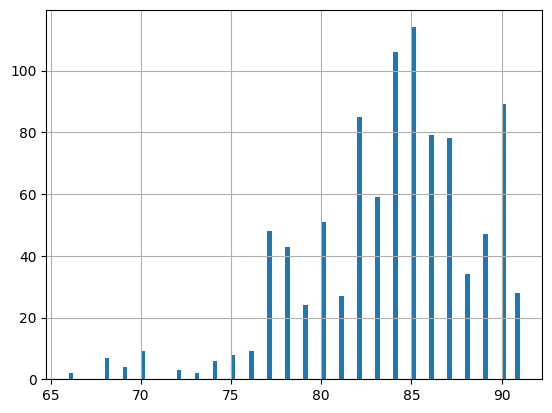

In [ ]:
df_rel.notna().sum(axis=1).hist(bins=100)

In [ ]:
df_rel.replace({np.nan: 0}, inplace=True)
df_rel

<ipython-input-164-1326221f8eef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rel.replace({np.nan: 0}, inplace=True)


Дата_оконч_периода Дата_цены_акции     Доход  Рост_выручки_год_к_году  \
4            2014-12-31      2015-03-03  0.208189               -53.047264   
5            2015-03-31      2015-05-25  0.147640                 1.590170   
6            2015-06-30      2015-08-28  0.138163                 0.535149   
7            2015-09-30      2015-11-30 -0.050603                -1.816170   
8            2015-12-31      2016-04-04 -0.040057                -1.192409   
...                 ...             ...       ...                      ...   
1109         2020-12-31      2021-04-02  0.594910                 4.220253   
1110         2021-03-31      2021-06-01  0.080404                -0.407767   
1111         2021-06-30      2021-08-31  0.153287                -0.407767   
1112         2021-09-30      2021-12-01 -0.124827                -1.112130   
1117         2021-09-30      2021-12-01  0.246395                -1.793548   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
4                  0.301961          0.000000   
5                  0.043137          0.000000   
6                  0.050193          0.000000   
7                  0.014981          0.000000   
8                 -0.216867          0.009132   
...                     ...               ...   
1109               0.227437          0.000000   
1110              -0.006349          0.000000   
1111              -0.006349          0.000000   
1112              -0.125000          0.000000   
1117               0.431095          0.000000   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
4                                             -0.015784       
5                                              0.135675       
6                                              0.462888       
7                                              0.046230       
8                                              0.127874       
...                                                 ...       
1109                                           0.644898       
1110                                           0.170640       
1111                                           0.249610       
1112                                           0.231586       
1117                                           0.134733       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
4                              0.00000                            -0.416367   
5                              0.00000                             1.404281   
6                              0.00000                             0.830150   
7                              0.00000                             0.872759   
8                              0.00000                             3.775540   
...                                ...                                  ...   
1109                           0.00000                             0.119260   
1110                           0.00000                            -0.137045   
1111                           0.00000                            -0.078832   
1112                           0.00000                            -0.344162   
1117                           0.17588                            -0.035218   

      Доходы_от_прекращенной_деятельности  ...  Тикер_SBER  Тикер_SELG  \
4                                     0.0  ...           0           0   
5                                     0.0  ...           0           0   
6                                     0.0  ...           0           0   
7                                     0.0  ...           0           0   
8                                     0.0  ...           0           0   
...                                   ...  ...         ...         ...   
1109                                  0.0  ...           0           0   
1110                                  0.0  ...           0           0   
1111                                  0.0  ...           0           0   
1112                             

In [ ]:
# сохраним полученный датасет для дальнейшей возможности загрузки,
# чтобы не проводить все операции выше при отключении от colab
df_rel.to_excel('dataset_MOEX_finale_pct_change(periods=4).xlsx')

In [ ]:
df_rel = pd.read_excel('/content/drive/MyDrive/Classroom/DS ИИ RN ПМ/Финальный проект/dataset_MOEX_finale_pct_change(periods=4).xlsx')

## Разбиение на обучающую и тестовую выборки

In [ ]:
train = df_rel[(df_rel['Дата_оконч_периода']<='2019-12-31')]
len(train)

707

In [ ]:
test = df_rel[(df_rel['Дата_оконч_периода']>'2019-12-31')]
len(test)

255

In [ ]:
len(train)/len(df_rel)

0.7349272349272349

In [ ]:
X_train = train.drop(columns=['close', 'Дата_оконч_периода', 'Дата_цены_акции'])
y_train = train['close']

In [ ]:
X_test = test.drop(columns=['close', 'Дата_оконч_периода', 'Дата_цены_акции'])
y_test = test['close']

## Линейная регрессия с регуляризацией

In [ ]:
best_params_ridge = gridsearch(
    X_train, y_train,
    Ridge(),
    {
        "alpha": np.logspace(-2, 3, 21), # default = 1.0
        "tol": np.logspace(-5, 0, 21), # default=1e-3
    }
)

pred_ridge = model_train_test(
    X_train,
    y_train,
    X_test,
    y_test,
    Ridge(**best_params_ridge)
)

Best hyperparameters: {'alpha': 1000.0, 'tol': 1e-05}
MAE test: 0.5371247282011464
MAE train: 0.26430842438978
RMSE test: 1.156282128191209
RMSE train: 0.4008368768641909
R2 test: -2.415492435202147
R2 train: 0.1585039840729987
MAPE test: 3.6316721899048194
MAPE train: 2.286436471888585


In [ ]:
best_params_lasso = gridsearch(
    X_train, y_train,
    Lasso(),
    {
        "alpha": np.logspace(-2, 3, 21), # default = 1.0
        "tol": np.logspace(-5, 0, 21), # default=1e-4

    }
)

pred_lasso = model_train_test(
    X_train,
    y_train,
    X_test,
    y_test,
    Lasso(**best_params_lasso)
)

Best hyperparameters: {'alpha': 56.23413251903491, 'tol': 0.0005623413251903491}
MAE test: 0.38028561679840794
MAE train: 0.2908776418852099
RMSE test: 0.6456637519140642
RMSE train: 0.43663632380303713
R2 test: -0.06497279173879411
R2 train: 0.001480734568430786
MAPE test: 3.6824735839918237
MAPE train: 2.845914568978971


## RandomForestRegressor

In [ ]:
best_params_rf = gridsearch(
    X_train, y_train,
    RandomForestRegressor(),
    {
        "max_depth": [None, 10] + [i for i in range(50, 351, 50)], # default = None
        "n_estimators": [i for i in range(50, 351, 50)], # default = 100
        "max_features": [i for i in range(2, 20, 1)]
    }
)

pred_rf = model_train_test(
    X_train,
    y_train,
    X_test,
    y_test,
    RandomForestRegressor(**best_params_rf)
)

Best hyperparameters: {'max_depth': 350, 'max_features': 19, 'n_estimators': 150}
MAE test: 0.3602605354419563
MAE train: 0.08245268669121679
RMSE test: 0.6253586713208373
RMSE train: 0.12517020967814496
R2 test: 0.0009572926336849363
R2 train: 0.9179424238752708
MAPE test: 2.458855532468798
MAPE train: 0.7397743622683102


## CatBoostRegressor

In [ ]:
# Воспользуем функцией RandomizedSearchCV
# В качестве определения "лучшей" модели выберем MSE
from sklearn.model_selection import RandomizedSearchCV
random_searcher = RandomizedSearchCV(
            cb.CatBoostRegressor(verbose=0),          # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(2, 7),
                'learning_rate': np.linspace(0.001, 0.3, 100),
            },
            scoring = 'neg_mean_squared_error',
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=10,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
random_searcher.fit(X_train, y_train)

# Выведем набор лучших параметров и лучшую метрику
print(f"Лучшая метрика:   {random_searcher.best_score_}")
print(f"Лучшие параметры: {random_searcher.best_params_}")
y_train_pred = random_searcher.predict(X_train)
y_test_pred = random_searcher.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшая метрика:   -0.15800115655741917
Лучшие параметры: {'max_depth': 6, 'learning_rate': 0.037242424242424244}


In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 0.37476312444272597
MAE train: 3.076548332695658e-06
RMSE test: 0.64090409923193
RMSE train: 4.2174055504113e-06
R2 test: -0.04932930136005842
R2 train: 0.9999999999068447
MAPE test: 2.6887803040436706
MAPE train: 4.522919385190498e-05


## LGBM

In [ ]:
# Воспользуем функцией RandomizedSearchCV
# В качестве определения "лучшей" модели выберем MSE

from sklearn.model_selection import RandomizedSearchCV
grid_LGBM = RandomizedSearchCV(
            lgb.LGBMRegressor(verbose=0),          # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(2, 200),
                'learning_rate': np.linspace(0.001, 0.3, 100),
            },
            scoring = 'neg_mean_squared_error',
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=10,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
grid_LGBM.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

RandomizedSearchCV(cv=3, estimator=LGBMRegressor(verbose=0), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.001     , 0.0040202 , 0.0070404 , 0.01006061, 0.01308081,
       0.01610101, 0.01912121, 0.02214141, 0.02516162, 0.02818182,
       0.03120202, 0.03422222, 0.03724242, 0.04026263, 0.04328283,
       0.04630303, 0.04932323, 0.05234343, 0.05536364, 0.05838384,
       0.06140404, 0.06442424, 0....
       0.22751515, 0.23053535, 0.23355556, 0.23657576, 0.23959596,
       0.24261616, 0.24563636, 0.24865657, 0.25167677, 0.25469697,
       0.25771717, 0.26073737, 0.26375758, 0.26677778, 0.26979798,
       0.27281818, 0.27583838, 0.27885859, 0.28187879, 0.28489899,
       0.28791919, 0.29093939, 0.2939596 , 0.2969798 , 0.3       ]),
                                        'max_depth': range(2, 200)},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=5)

In [ ]:
# Выведем набор лучших параметров и лучшую метрику
print(f"Лучшая метрика:   {grid_LGBM.best_score_}")
print(f"Лучшие параметры: {grid_LGBM.best_params_}")
y_test_pred=grid_LGBM.best_estimator_.predict(X_test)
y_train_pred=grid_LGBM.best_estimator_.predict(X_train)

Лучшая метрика:   -0.1636175217214745
Лучшие параметры: {'max_depth': 106, 'learning_rate': 0.022141414141414142}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 0.3651596368835771
MAE train: 0.1445636443086596
RMSE test: 0.6403390858106599
RMSE train: 0.24170710779638996
R2 test: -0.047479964465281244
R2 train: 0.6940182188820782
MAPE test: 2.34750406399039
MAPE train: 1.3420053697655403


По всем моделям R2 на тестовой выборке отрицательный

# Относительные изменения (квартал к кварталу)

In [ ]:
df_finale = pd.read_excel('/content/drive/MyDrive/Classroom/DS ИИ RN ПМ/Финальный проект/dataset_MOEX_finale.xlsx')
df_finale = df_finale.drop(columns=['Компания'])

In [ ]:
df_finale.columns = [c.replace(' ', '_') for c in df_finale.columns]
df_finale.columns = [c.replace('-', '_') for c in df_finale.columns]
df_finale.columns = [c.replace('(', '') for c in df_finale.columns]
df_finale.columns = [c.replace(')', '') for c in df_finale.columns]
df_finale.columns = [c.replace('/', '_') for c in df_finale.columns]
df_finale.columns = [c.replace(',', '_') for c in df_finale.columns]

In [ ]:
print('Числовые признаки:', len(df_finale.select_dtypes(include=["float", "int64"]).columns.tolist()))
print('Категориальные признаки:', len(df_finale.select_dtypes(include=["object", "datetime64[ns]"]).columns.tolist()))
# Сохраним числовые признаки
numerical_cols = df_finale.select_dtypes(include=["float", "int64"]).columns.tolist()
# добавим тикер в список численных признаков
rel_cols = ["Тикер"] + numerical_cols

Числовые признаки: 53
Категориальные признаки: 3


In [ ]:
# Сохраним категориальные признаки
cat_cols = df_finale.select_dtypes(include=["object", "datetime64[ns]"]).columns.tolist()

В акциях IRAO в начале 2015 года произошел сплит 100 к 1, поэтому умножим значения до конца 2014 года на 100

In [ ]:
df_finale.loc[(df_finale['Тикер']=='IRAO')&(df_finale['Дата_оконч_периода']<'2014-12-31'), 'close'] *=100

In [ ]:
df_finale

Тикер Дата_оконч_периода         Доход  Рост_выручки_год_к_году  \
0     LKOH         2013-12-31  1.179285e+12                -0.004000   
1     LKOH         2014-03-31  1.255015e+12                 0.057000   
2     LKOH         2014-06-30  1.297675e+12                 0.090000   
3     LKOH         2014-09-30  1.542087e+12                 0.062000   
4     LKOH         2014-12-31  1.424800e+12                 0.208189   
...    ...                ...           ...                      ...   
1113  GLTR         2020-09-30  1.647648e+10                -0.310000   
1114  GLTR         2020-12-31  1.647648e+10                -0.310000   
1115  GLTR         2021-03-31  1.603930e+10                -0.094000   
1116  GLTR         2021-06-30  1.603930e+10                -0.094000   
1117  GLTR         2021-09-30  2.053620e+10                 0.246000   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                     0.255                 0   
1                     0.255                 0   
2                     0.259                 0   
3                     0.267                 0   
4                     0.332       -1314000000   
...                     ...               ...   
1113                  0.283                 0   
1114                  0.283                 0   
1115                  0.255                 0   
1116                  0.255                 0   
1117                  0.405                 0   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                         -4.701765e+10       
1                                         -3.731877e+10       
2                                         -3.664942e+10       
3                                         -4.746280e+10       
4                                         -4.627554e+10       
...                                                 ...       
1113                                      -5.971450e+07       
1114                                      -5.971450e+07       
1115                                      -5.693500e+07       
1116                                      -5.693500e+07       
1117                                      -6.776000e+07       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                         0.000000e+00                        -2.792802e+09   
1                         0.000000e+00                        -2.919376e+09   
2                         0.000000e+00                        -3.124881e+09   
3                         0.000000e+00                        -3.833382e+09   
4                         0.000000e+00                        -1.629973e+09   
...                                ...                                  ...   
1113                     -9.889450e+08                        -5.550075e+08   
1114                     -9.889450e+08                        -5.550075e+08   
1115                     -8.602290e+08                        -5.298945e+08   
1116                     -8.602290e+08                        -5.298945e+08   
1117                     -1.162881e+09                        -5.354615e+08   

      Доходы_от_прекращенной_деятельности  ...  \
0                                     0.0  ...   
1                                     0.0  ...   
2                                     0.0  ...   
3                                     0.0  ...   
4                                     0.0  ...   
...                                   ...  ...   
1113                                  0.0  ...   
1114                                  0.0  ...   
1115                                  0.0  ...   
1116                                  0.0  ...   
1117                                  0.0  ...   

      Корректировки_курса_обмена_валют  Дополнения_сокращения  \
0                        -1.642825e+08          -5.282438e+10   
1                        -1.512448e+09           2.707498e+10   
2                         2.241763e+09          -

## Считаем относительные изменения признаков квартал к кварталу

In [ ]:
# чтобы корректно посчитать относительные изменения нужно заменить нулевые значения на Nan
# предполагается, что в данных нет Nan, иначе после этой операции, невозможно будет отличить пропуски от нулевых значений для дальнейшей повторной замены на 0
df_num = df_finale[rel_cols]
df_num.replace({'0':np.nan, 0:np.nan}, inplace=True)
df_num

<ipython-input-8-4a684348b845>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num.replace({'0':np.nan, 0:np.nan}, inplace=True)


Тикер         Доход  Рост_выручки_год_к_году  Маржа_валовой_прибыли  \
0     LKOH  1.179285e+12                -0.004000                  0.255   
1     LKOH  1.255015e+12                 0.057000                  0.255   
2     LKOH  1.297675e+12                 0.090000                  0.259   
3     LKOH  1.542087e+12                 0.062000                  0.267   
4     LKOH  1.424800e+12                 0.208189                  0.332   
...    ...           ...                      ...                    ...   
1113  GLTR  1.647648e+10                -0.310000                  0.283   
1114  GLTR  1.647648e+10                -0.310000                  0.283   
1115  GLTR  1.603930e+10                -0.094000                  0.255   
1116  GLTR  1.603930e+10                -0.094000                  0.255   
1117  GLTR  2.053620e+10                 0.246000                  0.405   

      Расходы_на_НИОКР  Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                  NaN                                      -4.701765e+10       
1                  NaN                                      -3.731877e+10       
2                  NaN                                      -3.664942e+10       
3                  NaN                                      -4.746280e+10       
4        -1.314000e+09                                      -4.627554e+10       
...                ...                                                ...       
1113               NaN                                      -5.971450e+07       
1114               NaN                                      -5.971450e+07       
1115               NaN                                      -5.693500e+07       
1116               NaN                                      -5.693500e+07       
1117               NaN                                      -6.776000e+07       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                        -2.792802e+09   
1                                  NaN                        -2.919376e+09   
2                                  NaN                        -3.124881e+09   
3                                  NaN                        -3.833382e+09   
4                                  NaN                        -1.629973e+09   
...                                ...                                  ...   
1113                     -9.889450e+08                        -5.550075e+08   
1114                     -9.889450e+08                        -5.550075e+08   
1115                     -8.602290e+08                        -5.298945e+08   
1116                     -8.602290e+08                        -5.298945e+08   
1117                     -1.162881e+09                        -5.354615e+08   

      Доходы_от_прекращенной_деятельности  Расходы_по_налогу_на_прибыль  ...  \
0                                     NaN                 -1.764394e+10  ...   
1                                     NaN                 -2.346052e+10  ...   
2                                     NaN                 -1.599803e+10  ...   
3                                     NaN                 -3.291966e+10  ...   
4                                     NaN                 -3.019093e+10  ...   
...                                   ...                           ...  ...   
1113                                  NaN                 -1.088385e+09  ...   
1114                                  NaN                 -1.088385e+09  ...   
1115                                  NaN                 -6.761000e+08  ...   
1116                                  NaN                 -6.761000e+08  ...   
1117                                  NaN                 -1.493138e+09  ...   

      Прочая_финансовая_деятельность  Корректировки_курса_обмена_валют  \
0                      -2.037103e+10                     -1.642825e+08   
1                       7.034640e+07                     -1.5

In [ ]:
df_change = df_num.groupby('Тикер').pct_change(periods=1)
df_change

Доход  Рост_выручки_год_к_году  Маржа_валовой_прибыли  \
0          NaN                      NaN                    NaN   
1     0.064216               -15.250000               0.000000   
2     0.033992                 0.578947               0.015686   
3     0.188346                -0.311111               0.030888   
4    -0.076057                 2.357888               0.243446   
...        ...                      ...                    ...   
1113       NaN                      NaN                    NaN   
1114  0.000000                 0.000000               0.000000   
1115 -0.026534                -0.696774              -0.098940   
1116  0.000000                 0.000000               0.000000   
1117  0.280367                -3.617021               0.588235   

      Расходы_на_НИОКР  Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                  NaN                                                NaN       
1                  NaN                                          -0.206282       
2                  NaN                                          -0.017936       
3                  NaN                                           0.295049       
4                  NaN                                          -0.025015       
...                ...                                                ...       
1113               NaN                                                NaN       
1114               NaN                                           0.000000       
1115               NaN                                          -0.046546       
1116               NaN                                           0.000000       
1117               NaN                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      Доходы_от_прекращенной_деятельности  Расходы_по_налогу_на_прибыль  \
0                                     NaN                           NaN   
1                                     NaN                      0.329665   
2                                     NaN                     -0.318087   
3                                     NaN                      1.057732   
4                                     NaN                     -0.082891   
...                                   ...                           ...   
1113                                  NaN                           NaN   
1114                                  NaN                      0.000000   
1115                                  NaN                     -0.378804   
1116                                  NaN                      0.000000   
1117                                  NaN                      1.208457   

      Миноритарная_доля_в_прибыли  ...  Прочая_финансовая_деятельность  \
0                             NaN  ...                             NaN   
1                       -1.022419  ...                       -1.003453   
2                        1.655623  ...                      -25.624872   
3                       -0.048049  ...                       -5.813677   
4                      

In [ ]:
# при подсчете относительного изменения могло произойти деление на ноль, поэтому меняем inf на Nan
df_change.replace([np.inf, -np.inf], np.nan, inplace=True)
df_change

Доход  Рост_выручки_год_к_году  Маржа_валовой_прибыли  \
0          NaN                      NaN                    NaN   
1     0.064216               -15.250000               0.000000   
2     0.033992                 0.578947               0.015686   
3     0.188346                -0.311111               0.030888   
4    -0.076057                 2.357888               0.243446   
...        ...                      ...                    ...   
1113       NaN                      NaN                    NaN   
1114  0.000000                 0.000000               0.000000   
1115 -0.026534                -0.696774              -0.098940   
1116  0.000000                 0.000000               0.000000   
1117  0.280367                -3.617021               0.588235   

      Расходы_на_НИОКР  Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                  NaN                                                NaN       
1                  NaN                                          -0.206282       
2                  NaN                                          -0.017936       
3                  NaN                                           0.295049       
4                  NaN                                          -0.025015       
...                ...                                                ...       
1113               NaN                                                NaN       
1114               NaN                                           0.000000       
1115               NaN                                          -0.046546       
1116               NaN                                           0.000000       
1117               NaN                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      Доходы_от_прекращенной_деятельности  Расходы_по_налогу_на_прибыль  \
0                                     NaN                           NaN   
1                                     NaN                      0.329665   
2                                     NaN                     -0.318087   
3                                     NaN                      1.057732   
4                                     NaN                     -0.082891   
...                                   ...                           ...   
1113                                  NaN                           NaN   
1114                                  NaN                      0.000000   
1115                                  NaN                     -0.378804   
1116                                  NaN                      0.000000   
1117                                  NaN                      1.208457   

      Миноритарная_доля_в_прибыли  ...  Прочая_финансовая_деятельность  \
0                             NaN  ...                             NaN   
1                       -1.022419  ...                       -1.003453   
2                        1.655623  ...                      -25.624872   
3                       -0.048049  ...                       -5.813677   
4                      

In [ ]:
df_rel = pd.concat([df_finale[cat_cols], df_change], axis=1)
df_rel

Тикер Дата_оконч_периода Дата_цены_акции     Доход  \
0     LKOH         2013-12-31      2014-02-19       NaN   
1     LKOH         2014-03-31      2014-05-29  0.064216   
2     LKOH         2014-06-30      2014-08-29  0.033992   
3     LKOH         2014-09-30      2014-10-21  0.188346   
4     LKOH         2014-12-31      2015-03-03 -0.076057   
...    ...                ...             ...       ...   
1113  GLTR         2020-09-30      2020-12-01       NaN   
1114  GLTR         2020-12-31      2021-04-02  0.000000   
1115  GLTR         2021-03-31      2021-06-01 -0.026534   
1116  GLTR         2021-06-30      2021-08-31  0.000000   
1117  GLTR         2021-09-30      2021-12-01  0.280367   

      Рост_выручки_год_к_году  Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                         NaN                    NaN               NaN   
1                  -15.250000               0.000000               NaN   
2                    0.578947               0.015686               NaN   
3                   -0.311111               0.030888               NaN   
4                    2.357888               0.243446               NaN   
...                       ...                    ...               ...   
1113                      NaN                    NaN               NaN   
1114                 0.000000               0.000000               NaN   
1115                -0.696774              -0.098940               NaN   
1116                 0.000000               0.000000               NaN   
1117                -3.617021               0.588235               NaN   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                                   NaN       
1                                             -0.206282       
2                                             -0.017936       
3                                              0.295049       
4                                             -0.025015       
...                                                 ...       
1113                                                NaN       
1114                                           0.000000       
1115                                          -0.046546       
1116                                           0.000000       
1117                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      ...  Прочая_финансовая_деятельность  Корректировки_курса_обмена_валют  \
0     ...                             NaN                               NaN   
1     ...                       -1.003453                          8.206383   
2     ...                      -25.624872                         -2.482208   
3     ...                       -5.813677                         -2.022466   
4     ...                       -6.216672                        -11.895618   
...   ...                             ...                               ...   
1113  ...                             NaN                               NaN   
1114  ...                        0.000000                          0.

## Кодируем категориальные признаки

In [ ]:
# Тикеры закодируем с помощью one-hot-encoding
df_rel = pd.get_dummies(df_rel,
                         columns = ['Тикер'])
df_rel

Дата_оконч_периода Дата_цены_акции     Доход  Рост_выручки_год_к_году  \
0            2013-12-31      2014-02-19       NaN                      NaN   
1            2014-03-31      2014-05-29  0.064216               -15.250000   
2            2014-06-30      2014-08-29  0.033992                 0.578947   
3            2014-09-30      2014-10-21  0.188346                -0.311111   
4            2014-12-31      2015-03-03 -0.076057                 2.357888   
...                 ...             ...       ...                      ...   
1113         2020-09-30      2020-12-01       NaN                      NaN   
1114         2020-12-31      2021-04-02  0.000000                 0.000000   
1115         2021-03-31      2021-06-01 -0.026534                -0.696774   
1116         2021-06-30      2021-08-31  0.000000                 0.000000   
1117         2021-09-30      2021-12-01  0.280367                -3.617021   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                       NaN               NaN   
1                  0.000000               NaN   
2                  0.015686               NaN   
3                  0.030888               NaN   
4                  0.243446               NaN   
...                     ...               ...   
1113                    NaN               NaN   
1114               0.000000               NaN   
1115              -0.098940               NaN   
1116               0.000000               NaN   
1117               0.588235               NaN   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                                   NaN       
1                                             -0.206282       
2                                             -0.017936       
3                                              0.295049       
4                                             -0.025015       
...                                                 ...       
1113                                                NaN       
1114                                           0.000000       
1115                                          -0.046546       
1116                                           0.000000       
1117                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      Доходы_от_прекращенной_деятельности  ...  Тикер_RUAL  Тикер_SBER  \
0                                     NaN  ...           0           0   
1                                     NaN  ...           0           0   
2                                     NaN  ...           0           0   
3                                     NaN  ...           0           0   
4                                     NaN  ...           0           0   
...                                   ...  ...         ...         ...   
1113                                  NaN  ...           0           0   
1114                                  NaN  ...           0           0   
1115                                  NaN  ...           0           0   
1116                             

In [ ]:
# Дату отчетного периода закодируем с помощью labelencoder, поскольку важен порядок
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(df_rel['Дата_оконч_периода'])
df_rel['label_периода'] = enc.transform(df_rel['Дата_оконч_периода'])
df_rel

Дата_оконч_периода Дата_цены_акции     Доход  Рост_выручки_год_к_году  \
0            2013-12-31      2014-02-19       NaN                      NaN   
1            2014-03-31      2014-05-29  0.064216               -15.250000   
2            2014-06-30      2014-08-29  0.033992                 0.578947   
3            2014-09-30      2014-10-21  0.188346                -0.311111   
4            2014-12-31      2015-03-03 -0.076057                 2.357888   
...                 ...             ...       ...                      ...   
1113         2020-09-30      2020-12-01       NaN                      NaN   
1114         2020-12-31      2021-04-02  0.000000                 0.000000   
1115         2021-03-31      2021-06-01 -0.026534                -0.696774   
1116         2021-06-30      2021-08-31  0.000000                 0.000000   
1117         2021-09-30      2021-12-01  0.280367                -3.617021   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                       NaN               NaN   
1                  0.000000               NaN   
2                  0.015686               NaN   
3                  0.030888               NaN   
4                  0.243446               NaN   
...                     ...               ...   
1113                    NaN               NaN   
1114               0.000000               NaN   
1115              -0.098940               NaN   
1116               0.000000               NaN   
1117               0.588235               NaN   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                                   NaN       
1                                             -0.206282       
2                                             -0.017936       
3                                              0.295049       
4                                             -0.025015       
...                                                 ...       
1113                                                NaN       
1114                                           0.000000       
1115                                          -0.046546       
1116                                           0.000000       
1117                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      Доходы_от_прекращенной_деятельности  ...  Тикер_SBER  Тикер_SELG  \
0                                     NaN  ...           0           0   
1                                     NaN  ...           0           0   
2                                     NaN  ...           0           0   
3                                     NaN  ...           0           0   
4                                     NaN  ...           0           0   
...                                   ...  ...         ...         ...   
1113                                  NaN  ...           0           0   
1114                                  NaN  ...           0           0   
1115                                  NaN  ...           0           0   
1116                             

## Чистим данные после вычисления относительных изменений

Посмотрим на распределение целевой метрики

<Axes: >

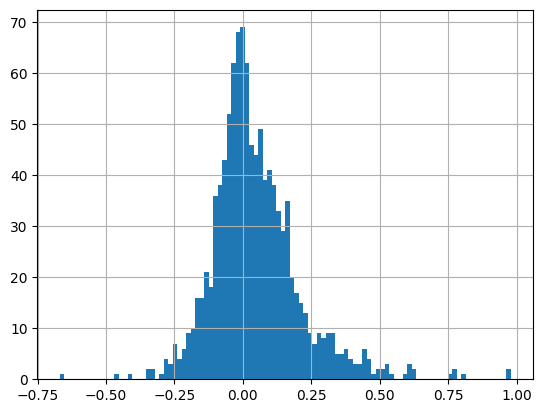

In [ ]:
df_rel.close.hist(bins=100)

In [ ]:
df_rel.notna().sum(axis=1)

0       42
1       86
2       86
3       86
4       86
        ..
1113    42
1114    85
1115    85
1116    85
1117    85
Length: 1118, dtype: int64

In [ ]:
# Удаляю строки которые при вычислении относительных изменений получились Nan
df_rel = df_rel.dropna(thresh=43)

In [ ]:
df_rel

Дата_оконч_периода Дата_цены_акции     Доход  Рост_выручки_год_к_году  \
1            2014-03-31      2014-05-29  0.064216               -15.250000   
2            2014-06-30      2014-08-29  0.033992                 0.578947   
3            2014-09-30      2014-10-21  0.188346                -0.311111   
4            2014-12-31      2015-03-03 -0.076057                 2.357888   
5            2015-03-31      2015-05-25  0.010882                -0.290838   
...                 ...             ...       ...                      ...   
1112         2021-09-30      2021-12-01  0.262890                -1.540984   
1114         2020-12-31      2021-04-02  0.000000                 0.000000   
1115         2021-03-31      2021-06-01 -0.026534                -0.696774   
1116         2021-06-30      2021-08-31  0.000000                 0.000000   
1117         2021-09-30      2021-12-01  0.280367                -3.617021   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
1                  0.000000               NaN   
2                  0.015686               NaN   
3                  0.030888               NaN   
4                  0.243446               NaN   
5                 -0.198795               0.0   
...                     ...               ...   
1112              -0.049521               NaN   
1114               0.000000               NaN   
1115              -0.098940               NaN   
1116               0.000000               NaN   
1117               0.588235               NaN   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
1                                             -0.206282       
2                                             -0.017936       
3                                              0.295049       
4                                             -0.025015       
5                                             -0.084138       
...                                                 ...       
1112                                           0.202119       
1114                                           0.000000       
1115                                          -0.046546       
1116                                           0.000000       
1117                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
5                                  NaN                             3.306207   
...                                ...                                  ...   
1112                               NaN                            -0.195846   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      Доходы_от_прекращенной_деятельности  ...  Тикер_SBER  Тикер_SELG  \
1                                     NaN  ...           0           0   
2                                     NaN  ...           0           0   
3                                     NaN  ...           0           0   
4                                     NaN  ...           0           0   
5                                     NaN  ...           0           0   
...                                   ...  ...         ...         ...   
1112                                  0.0  ...           0           0   
1114                                  NaN  ...           0           0   
1115                                  NaN  ...           0           0   
1116                             

<Axes: >

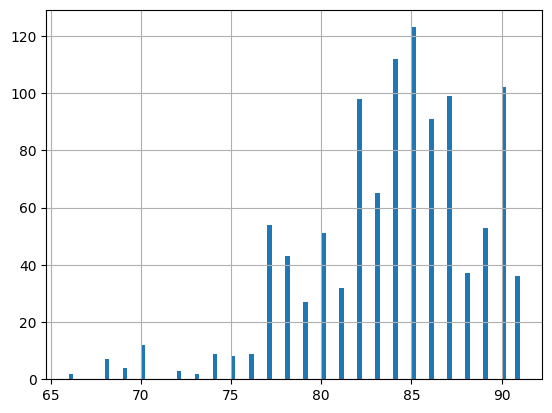

In [ ]:
df_rel.notna().sum(axis=1).hist(bins=100)

In [ ]:
df_rel.replace({np.nan: 0}, inplace=True)
df_rel

<ipython-input-43-1326221f8eef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rel.replace({np.nan: 0}, inplace=True)


Дата_оконч_периода Дата_цены_акции     Доход  Рост_выручки_год_к_году  \
1            2014-03-31      2014-05-29  0.064216               -15.250000   
2            2014-06-30      2014-08-29  0.033992                 0.578947   
3            2014-09-30      2014-10-21  0.188346                -0.311111   
4            2014-12-31      2015-03-03 -0.076057                 2.357888   
5            2015-03-31      2015-05-25  0.010882                -0.290838   
...                 ...             ...       ...                      ...   
1112         2021-09-30      2021-12-01  0.262890                -1.540984   
1114         2020-12-31      2021-04-02  0.000000                 0.000000   
1115         2021-03-31      2021-06-01 -0.026534                -0.696774   
1116         2021-06-30      2021-08-31  0.000000                 0.000000   
1117         2021-09-30      2021-12-01  0.280367                -3.617021   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
1                  0.000000               0.0   
2                  0.015686               0.0   
3                  0.030888               0.0   
4                  0.243446               0.0   
5                 -0.198795               0.0   
...                     ...               ...   
1112              -0.049521               0.0   
1114               0.000000               0.0   
1115              -0.098940               0.0   
1116               0.000000               0.0   
1117               0.588235               0.0   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
1                                             -0.206282       
2                                             -0.017936       
3                                              0.295049       
4                                             -0.025015       
5                                             -0.084138       
...                                                 ...       
1112                                           0.202119       
1114                                           0.000000       
1115                                          -0.046546       
1116                                           0.000000       
1117                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
1                             0.000000                             0.045321   
2                             0.000000                             0.070394   
3                             0.000000                             0.226729   
4                             0.000000                            -0.574795   
5                             0.000000                             3.306207   
...                                ...                                  ...   
1112                          0.000000                            -0.195846   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      Доходы_от_прекращенной_деятельности  ...  Тикер_SBER  Тикер_SELG  \
1                                     0.0  ...           0           0   
2                                     0.0  ...           0           0   
3                                     0.0  ...           0           0   
4                                     0.0  ...           0           0   
5                                     0.0  ...           0           0   
...                                   ...  ...         ...         ...   
1112                                  0.0  ...           0           0   
1114                                  0.0  ...           0           0   
1115                                  0.0  ...           0           0   
1116                             

In [ ]:
# сохраним полученный датасет для дальнейшей возможности загрузки,
# чтобы не проводить все операции выше при отключении от colab
df_rel.to_excel('dataset_MOEX_finale_pct_change(periods=1).xlsx')

In [ ]:
df_rel = pd.read_excel('/content/drive/MyDrive/Classroom/DS ИИ RN ПМ/Финальный проект/dataset_MOEX_finale_pct_change(periods=1).xlsx')

## Разбиение на обучающую и тестовую выборки

In [ ]:
train = df_rel[(df_rel['Дата_оконч_периода']<='2019-12-31')]
len(train)

813

In [ ]:
test = df_rel[(df_rel['Дата_оконч_периода']>'2019-12-31')]
len(test)

266

In [ ]:
len(train)/len(df_rel)

0.7534754402224282

In [ ]:
X_train = train.drop(columns=['close', 'Дата_оконч_периода', 'Дата_цены_акции'])
y_train = train['close']

In [ ]:
X_test = test.drop(columns=['close', 'Дата_оконч_периода', 'Дата_цены_акции'])
y_test = test['close']

## Линейная регрессия с регуляризацией

In [ ]:
best_params_ridge = gridsearch(
    X_train, y_train,
    Ridge(),
    {
        "alpha": np.logspace(-2, 3, 21), # default = 1.0
        "tol": np.logspace(-5, 0, 21), # default=1e-3
    }
)

pred_ridge = model_train_test(
    X_train,
    y_train,
    X_test,
    y_test,
    Ridge(**best_params_ridge)
)

Best hyperparameters: {'alpha': 1000.0, 'tol': 1e-05}
MAE test: 0.1875990379748293
MAE train: 0.10809854751345833
RMSE test: 0.7017598606395563
RMSE train: 0.15069387802560452
R2 test: -15.865926208918946
R2 train: 0.11344039871087108
MAPE test: 5.445470172978119
MAPE train: 2.3100738674267207


In [ ]:
best_params_lasso = gridsearch(
    X_train, y_train,
    Lasso(),
    {
        "alpha": np.logspace(-2, 3, 21), # default = 1.0
        "tol": np.logspace(-5, 0, 21), # default=1e-4

    }
)

pred_lasso = model_train_test(
    X_train,
    y_train,
    X_test,
    y_test,
    Lasso(**best_params_lasso)
)

Best hyperparameters: {'alpha': 1.7782794100389228, 'tol': 0.001}
MAE test: 0.12551871020201352
MAE train: 0.11369544338175527
RMSE test: 0.17748178935954853
RMSE train: 0.1581631718576103
R2 test: -0.07879952255107914
R2 train: 0.02337586974969419
MAPE test: 2.4763534530971185
MAPE train: 2.6964305743145904


## RandomForestRegressor

In [ ]:
# Воспользуем функцией RandomizedSearchCV
# В качестве определения "лучшей" модели выберем MSE
from sklearn.model_selection import RandomizedSearchCV
random_searcher = RandomizedSearchCV(
            RandomForestRegressor(),          # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(2, 20),
                'max_features': range(2, 11),
                'n_estimators': range(50, 200)
            },
            scoring = 'neg_mean_squared_error',
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=10,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
random_searcher.fit(X_train, y_train)

# Выведем набор лучших параметров и лучшую метрику
print(f"Лучшая метрика:   {random_searcher.best_score_}")
print(f"Лучшие параметры: {random_searcher.best_params_}")
y_train_pred = random_searcher.predict(X_train)
y_test_pred = random_searcher.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшая метрика:   -0.024403508265884766
Лучшие параметры: {'n_estimators': 186, 'max_features': 10, 'max_depth': 16}


In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 0.11436628131219123
MAE train: 0.05450941337602179
RMSE test: 0.16402015754029522
RMSE train: 0.07176981995557123
R2 test: 0.07864372546953435
R2 train: 0.7989053890486846
MAPE test: 2.553633912073195
MAPE train: 1.360266970469808


## CatBoostRegressor

In [ ]:
# Воспользуем функцией RandomizedSearchCV
# В качестве определения "лучшей" модели выберем MSE
from sklearn.model_selection import RandomizedSearchCV
random_searcher = RandomizedSearchCV(
            cb.CatBoostRegressor(verbose=0),          # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(2, 7),
                'learning_rate': np.linspace(0.001, 0.3, 100),
            },
            scoring = 'neg_mean_squared_error',
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=10,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
random_searcher.fit(X_train, y_train)

# Выведем набор лучших параметров и лучшую метрику
print(f"Лучшая метрика:   {random_searcher.best_score_}")
print(f"Лучшие параметры: {random_searcher.best_params_}")
y_train_pred = random_searcher.predict(X_train)
y_test_pred = random_searcher.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшая метрика:   -0.02466649144398451
Лучшие параметры: {'max_depth': 6, 'learning_rate': 0.058383838383838385}


In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 0.12074623549456268
MAE train: 0.013330375045298843
RMSE test: 0.17059490464209048
RMSE train: 0.01880116877707415
R2 test: 0.0032981616925534807
R2 train: 0.9861997671288507
MAPE test: 2.6569232340863493
MAPE train: 0.5857803356963931


## LGBM

In [ ]:
# Воспользуем функцией RandomizedSearchCV
# В качестве определения "лучшей" модели выберем MSE

from sklearn.model_selection import RandomizedSearchCV
grid_LGBM = RandomizedSearchCV(
            lgb.LGBMRegressor(verbose=0),          # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(2, 200),
                'learning_rate': np.linspace(0.001, 0.3, 100),
            },
            scoring = 'neg_mean_squared_error',
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=10,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 2,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
grid_LGBM.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

RandomizedSearchCV(cv=3, estimator=LGBMRegressor(verbose=0), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.001     , 0.0040202 , 0.0070404 , 0.01006061, 0.01308081,
       0.01610101, 0.01912121, 0.02214141, 0.02516162, 0.02818182,
       0.03120202, 0.03422222, 0.03724242, 0.04026263, 0.04328283,
       0.04630303, 0.04932323, 0.05234343, 0.05536364, 0.05838384,
       0.06140404, 0.06442424, 0....
       0.22751515, 0.23053535, 0.23355556, 0.23657576, 0.23959596,
       0.24261616, 0.24563636, 0.24865657, 0.25167677, 0.25469697,
       0.25771717, 0.26073737, 0.26375758, 0.26677778, 0.26979798,
       0.27281818, 0.27583838, 0.27885859, 0.28187879, 0.28489899,
       0.28791919, 0.29093939, 0.2939596 , 0.2969798 , 0.3       ]),
                                        'max_depth': range(2, 200)},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
# Выведем набор лучших параметров и лучшую метрику
print(f"Лучшая метрика:   {grid_LGBM.best_score_}")
print(f"Лучшие параметры: {grid_LGBM.best_params_}")
y_test_pred=grid_LGBM.best_estimator_.predict(X_test)
y_train_pred=grid_LGBM.best_estimator_.predict(X_train)

Лучшая метрика:   -0.025640034476645923
Лучшие параметры: {'max_depth': 26, 'learning_rate': 0.028181818181818183}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 0.12005614517002973
MAE train: 0.059849233755422795
RMSE test: 0.16822058151118122
RMSE train: 0.08998806454425191
R2 test: 0.030849089207192537
R2 train: 0.6838548373218221
MAPE test: 3.218421069524328
MAPE train: 1.675035794581986


По всем моделям R2 на тестовой выборке низкое значение, наблюдается переобучение

# Относительные изменения (квартал к кварталу), период до пандемии

В связи с тем, что в 2020 года была пандемия и цены акций упали, возможно по этой причине модели плохо предсказывают на тестовой выборке.

Выберем другое разделение данных на обучающую и тестовую выборки в рамках срока до 2020 года

In [ ]:
df_finale = pd.read_excel('/content/drive/MyDrive/Classroom/DS ИИ RN ПМ/Финальный проект/dataset_MOEX_finale.xlsx')
df_finale = df_finale.drop(columns=['Компания'])

In [ ]:
df_finale.columns = [c.replace(' ', '_') for c in df_finale.columns]
df_finale.columns = [c.replace('-', '_') for c in df_finale.columns]
df_finale.columns = [c.replace('(', '') for c in df_finale.columns]
df_finale.columns = [c.replace(')', '') for c in df_finale.columns]
df_finale.columns = [c.replace('/', '_') for c in df_finale.columns]
df_finale.columns = [c.replace(',', '_') for c in df_finale.columns]

In [ ]:
print('Числовые признаки:', len(df_finale.select_dtypes(include=["float", "int64"]).columns.tolist()))
print('Категориальные признаки:', len(df_finale.select_dtypes(include=["object", "datetime64[ns]"]).columns.tolist()))
# Сохраним числовые признаки
numerical_cols = df_finale.select_dtypes(include=["float", "int64"]).columns.tolist()
# добавим тикер в список численных признаков
rel_cols = ["Тикер"] + numerical_cols

Числовые признаки: 53
Категориальные признаки: 3


In [ ]:
# Сохраним категориальные признаки
cat_cols = df_finale.select_dtypes(include=["object", "datetime64[ns]"]).columns.tolist()

В акциях IRAO в начале 2015 года произошел сплит 100 к 1, поэтому умножим значения до конца 2014 года на 100

In [ ]:
df_finale.loc[(df_finale['Тикер']=='IRAO')&(df_finale['Дата_оконч_периода']<'2014-12-31'), 'close'] *=100

In [ ]:
df_finale

Тикер Дата_оконч_периода         Доход  Рост_выручки_год_к_году  \
0     LKOH         2013-12-31  1.179285e+12                -0.004000   
1     LKOH         2014-03-31  1.255015e+12                 0.057000   
2     LKOH         2014-06-30  1.297675e+12                 0.090000   
3     LKOH         2014-09-30  1.542087e+12                 0.062000   
4     LKOH         2014-12-31  1.424800e+12                 0.208189   
...    ...                ...           ...                      ...   
1113  GLTR         2020-09-30  1.647648e+10                -0.310000   
1114  GLTR         2020-12-31  1.647648e+10                -0.310000   
1115  GLTR         2021-03-31  1.603930e+10                -0.094000   
1116  GLTR         2021-06-30  1.603930e+10                -0.094000   
1117  GLTR         2021-09-30  2.053620e+10                 0.246000   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                     0.255                 0   
1                     0.255                 0   
2                     0.259                 0   
3                     0.267                 0   
4                     0.332       -1314000000   
...                     ...               ...   
1113                  0.283                 0   
1114                  0.283                 0   
1115                  0.255                 0   
1116                  0.255                 0   
1117                  0.405                 0   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                         -4.701765e+10       
1                                         -3.731877e+10       
2                                         -3.664942e+10       
3                                         -4.746280e+10       
4                                         -4.627554e+10       
...                                                 ...       
1113                                      -5.971450e+07       
1114                                      -5.971450e+07       
1115                                      -5.693500e+07       
1116                                      -5.693500e+07       
1117                                      -6.776000e+07       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                         0.000000e+00                        -2.792802e+09   
1                         0.000000e+00                        -2.919376e+09   
2                         0.000000e+00                        -3.124881e+09   
3                         0.000000e+00                        -3.833382e+09   
4                         0.000000e+00                        -1.629973e+09   
...                                ...                                  ...   
1113                     -9.889450e+08                        -5.550075e+08   
1114                     -9.889450e+08                        -5.550075e+08   
1115                     -8.602290e+08                        -5.298945e+08   
1116                     -8.602290e+08                        -5.298945e+08   
1117                     -1.162881e+09                        -5.354615e+08   

      Доходы_от_прекращенной_деятельности  ...  \
0                                     0.0  ...   
1                                     0.0  ...   
2                                     0.0  ...   
3                                     0.0  ...   
4                                     0.0  ...   
...                                   ...  ...   
1113                                  0.0  ...   
1114                                  0.0  ...   
1115                                  0.0  ...   
1116                                  0.0  ...   
1117                                  0.0  ...   

      Корректировки_курса_обмена_валют  Дополнения_сокращения  \
0                        -1.642825e+08          -5.282438e+10   
1                        -1.512448e+09           2.707498e+10   
2                         2.241763e+09          -

## Считаем относительные изменения признаков квартал к кварталу

In [ ]:
# чтобы корректно посчитать относительные изменения нужно заменить нулевые значения на Nan
# предполагается, что в данных нет Nan, иначе после этой операции, невозможно будет отличить пропуски от нулевых значений для дальнейшей повторной замены на 0
df_num = df_finale[rel_cols]
df_num.replace({'0':np.nan, 0:np.nan}, inplace=True)
df_num

<ipython-input-77-4a684348b845>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num.replace({'0':np.nan, 0:np.nan}, inplace=True)


Тикер         Доход  Рост_выручки_год_к_году  Маржа_валовой_прибыли  \
0     LKOH  1.179285e+12                -0.004000                  0.255   
1     LKOH  1.255015e+12                 0.057000                  0.255   
2     LKOH  1.297675e+12                 0.090000                  0.259   
3     LKOH  1.542087e+12                 0.062000                  0.267   
4     LKOH  1.424800e+12                 0.208189                  0.332   
...    ...           ...                      ...                    ...   
1113  GLTR  1.647648e+10                -0.310000                  0.283   
1114  GLTR  1.647648e+10                -0.310000                  0.283   
1115  GLTR  1.603930e+10                -0.094000                  0.255   
1116  GLTR  1.603930e+10                -0.094000                  0.255   
1117  GLTR  2.053620e+10                 0.246000                  0.405   

      Расходы_на_НИОКР  Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                  NaN                                      -4.701765e+10       
1                  NaN                                      -3.731877e+10       
2                  NaN                                      -3.664942e+10       
3                  NaN                                      -4.746280e+10       
4        -1.314000e+09                                      -4.627554e+10       
...                ...                                                ...       
1113               NaN                                      -5.971450e+07       
1114               NaN                                      -5.971450e+07       
1115               NaN                                      -5.693500e+07       
1116               NaN                                      -5.693500e+07       
1117               NaN                                      -6.776000e+07       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                        -2.792802e+09   
1                                  NaN                        -2.919376e+09   
2                                  NaN                        -3.124881e+09   
3                                  NaN                        -3.833382e+09   
4                                  NaN                        -1.629973e+09   
...                                ...                                  ...   
1113                     -9.889450e+08                        -5.550075e+08   
1114                     -9.889450e+08                        -5.550075e+08   
1115                     -8.602290e+08                        -5.298945e+08   
1116                     -8.602290e+08                        -5.298945e+08   
1117                     -1.162881e+09                        -5.354615e+08   

      Доходы_от_прекращенной_деятельности  Расходы_по_налогу_на_прибыль  ...  \
0                                     NaN                 -1.764394e+10  ...   
1                                     NaN                 -2.346052e+10  ...   
2                                     NaN                 -1.599803e+10  ...   
3                                     NaN                 -3.291966e+10  ...   
4                                     NaN                 -3.019093e+10  ...   
...                                   ...                           ...  ...   
1113                                  NaN                 -1.088385e+09  ...   
1114                                  NaN                 -1.088385e+09  ...   
1115                                  NaN                 -6.761000e+08  ...   
1116                                  NaN                 -6.761000e+08  ...   
1117                                  NaN                 -1.493138e+09  ...   

      Прочая_финансовая_деятельность  Корректировки_курса_обмена_валют  \
0                      -2.037103e+10                     -1.642825e+08   
1                       7.034640e+07                     -1.5

In [ ]:
df_change = df_num.groupby('Тикер').pct_change(periods=1)
df_change

Доход  Рост_выручки_год_к_году  Маржа_валовой_прибыли  \
0          NaN                      NaN                    NaN   
1     0.064216               -15.250000               0.000000   
2     0.033992                 0.578947               0.015686   
3     0.188346                -0.311111               0.030888   
4    -0.076057                 2.357888               0.243446   
...        ...                      ...                    ...   
1113       NaN                      NaN                    NaN   
1114  0.000000                 0.000000               0.000000   
1115 -0.026534                -0.696774              -0.098940   
1116  0.000000                 0.000000               0.000000   
1117  0.280367                -3.617021               0.588235   

      Расходы_на_НИОКР  Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                  NaN                                                NaN       
1                  NaN                                          -0.206282       
2                  NaN                                          -0.017936       
3                  NaN                                           0.295049       
4                  NaN                                          -0.025015       
...                ...                                                ...       
1113               NaN                                                NaN       
1114               NaN                                           0.000000       
1115               NaN                                          -0.046546       
1116               NaN                                           0.000000       
1117               NaN                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      Доходы_от_прекращенной_деятельности  Расходы_по_налогу_на_прибыль  \
0                                     NaN                           NaN   
1                                     NaN                      0.329665   
2                                     NaN                     -0.318087   
3                                     NaN                      1.057732   
4                                     NaN                     -0.082891   
...                                   ...                           ...   
1113                                  NaN                           NaN   
1114                                  NaN                      0.000000   
1115                                  NaN                     -0.378804   
1116                                  NaN                      0.000000   
1117                                  NaN                      1.208457   

      Миноритарная_доля_в_прибыли  ...  Прочая_финансовая_деятельность  \
0                             NaN  ...                             NaN   
1                       -1.022419  ...                       -1.003453   
2                        1.655623  ...                      -25.624872   
3                       -0.048049  ...                       -5.813677   
4                      

In [ ]:
# при подсчете относительного изменения могло произойти деление на ноль, поэтому меняем inf на Nan
df_change.replace([np.inf, -np.inf], np.nan, inplace=True)
df_change

Доход  Рост_выручки_год_к_году  Маржа_валовой_прибыли  \
0          NaN                      NaN                    NaN   
1     0.064216               -15.250000               0.000000   
2     0.033992                 0.578947               0.015686   
3     0.188346                -0.311111               0.030888   
4    -0.076057                 2.357888               0.243446   
...        ...                      ...                    ...   
1113       NaN                      NaN                    NaN   
1114  0.000000                 0.000000               0.000000   
1115 -0.026534                -0.696774              -0.098940   
1116  0.000000                 0.000000               0.000000   
1117  0.280367                -3.617021               0.588235   

      Расходы_на_НИОКР  Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                  NaN                                                NaN       
1                  NaN                                          -0.206282       
2                  NaN                                          -0.017936       
3                  NaN                                           0.295049       
4                  NaN                                          -0.025015       
...                ...                                                ...       
1113               NaN                                                NaN       
1114               NaN                                           0.000000       
1115               NaN                                          -0.046546       
1116               NaN                                           0.000000       
1117               NaN                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      Доходы_от_прекращенной_деятельности  Расходы_по_налогу_на_прибыль  \
0                                     NaN                           NaN   
1                                     NaN                      0.329665   
2                                     NaN                     -0.318087   
3                                     NaN                      1.057732   
4                                     NaN                     -0.082891   
...                                   ...                           ...   
1113                                  NaN                           NaN   
1114                                  NaN                      0.000000   
1115                                  NaN                     -0.378804   
1116                                  NaN                      0.000000   
1117                                  NaN                      1.208457   

      Миноритарная_доля_в_прибыли  ...  Прочая_финансовая_деятельность  \
0                             NaN  ...                             NaN   
1                       -1.022419  ...                       -1.003453   
2                        1.655623  ...                      -25.624872   
3                       -0.048049  ...                       -5.813677   
4                      

In [ ]:
df_rel = pd.concat([df_finale[cat_cols], df_change], axis=1)
df_rel

Тикер Дата_оконч_периода Дата_цены_акции     Доход  \
0     LKOH         2013-12-31      2014-02-19       NaN   
1     LKOH         2014-03-31      2014-05-29  0.064216   
2     LKOH         2014-06-30      2014-08-29  0.033992   
3     LKOH         2014-09-30      2014-10-21  0.188346   
4     LKOH         2014-12-31      2015-03-03 -0.076057   
...    ...                ...             ...       ...   
1113  GLTR         2020-09-30      2020-12-01       NaN   
1114  GLTR         2020-12-31      2021-04-02  0.000000   
1115  GLTR         2021-03-31      2021-06-01 -0.026534   
1116  GLTR         2021-06-30      2021-08-31  0.000000   
1117  GLTR         2021-09-30      2021-12-01  0.280367   

      Рост_выручки_год_к_году  Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                         NaN                    NaN               NaN   
1                  -15.250000               0.000000               NaN   
2                    0.578947               0.015686               NaN   
3                   -0.311111               0.030888               NaN   
4                    2.357888               0.243446               NaN   
...                       ...                    ...               ...   
1113                      NaN                    NaN               NaN   
1114                 0.000000               0.000000               NaN   
1115                -0.696774              -0.098940               NaN   
1116                 0.000000               0.000000               NaN   
1117                -3.617021               0.588235               NaN   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                                   NaN       
1                                             -0.206282       
2                                             -0.017936       
3                                              0.295049       
4                                             -0.025015       
...                                                 ...       
1113                                                NaN       
1114                                           0.000000       
1115                                          -0.046546       
1116                                           0.000000       
1117                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      ...  Прочая_финансовая_деятельность  Корректировки_курса_обмена_валют  \
0     ...                             NaN                               NaN   
1     ...                       -1.003453                          8.206383   
2     ...                      -25.624872                         -2.482208   
3     ...                       -5.813677                         -2.022466   
4     ...                       -6.216672                        -11.895618   
...   ...                             ...                               ...   
1113  ...                             NaN                               NaN   
1114  ...                        0.000000                          0.

## Кодируем категориальные признаки

In [ ]:
# Тикеры закодируем с помощью one-hot-encoding
df_rel = pd.get_dummies(df_rel,
                         columns = ['Тикер'])
df_rel

Дата_оконч_периода Дата_цены_акции     Доход  Рост_выручки_год_к_году  \
0            2013-12-31      2014-02-19       NaN                      NaN   
1            2014-03-31      2014-05-29  0.064216               -15.250000   
2            2014-06-30      2014-08-29  0.033992                 0.578947   
3            2014-09-30      2014-10-21  0.188346                -0.311111   
4            2014-12-31      2015-03-03 -0.076057                 2.357888   
...                 ...             ...       ...                      ...   
1113         2020-09-30      2020-12-01       NaN                      NaN   
1114         2020-12-31      2021-04-02  0.000000                 0.000000   
1115         2021-03-31      2021-06-01 -0.026534                -0.696774   
1116         2021-06-30      2021-08-31  0.000000                 0.000000   
1117         2021-09-30      2021-12-01  0.280367                -3.617021   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                       NaN               NaN   
1                  0.000000               NaN   
2                  0.015686               NaN   
3                  0.030888               NaN   
4                  0.243446               NaN   
...                     ...               ...   
1113                    NaN               NaN   
1114               0.000000               NaN   
1115              -0.098940               NaN   
1116               0.000000               NaN   
1117               0.588235               NaN   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                                   NaN       
1                                             -0.206282       
2                                             -0.017936       
3                                              0.295049       
4                                             -0.025015       
...                                                 ...       
1113                                                NaN       
1114                                           0.000000       
1115                                          -0.046546       
1116                                           0.000000       
1117                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      Доходы_от_прекращенной_деятельности  ...  Тикер_RUAL  Тикер_SBER  \
0                                     NaN  ...           0           0   
1                                     NaN  ...           0           0   
2                                     NaN  ...           0           0   
3                                     NaN  ...           0           0   
4                                     NaN  ...           0           0   
...                                   ...  ...         ...         ...   
1113                                  NaN  ...           0           0   
1114                                  NaN  ...           0           0   
1115                                  NaN  ...           0           0   
1116                             

In [ ]:
# Дату отчетного периода закодируем с помощью labelencoder, поскольку важен порядок
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(df_rel['Дата_оконч_периода'])
df_rel['label_периода'] = enc.transform(df_rel['Дата_оконч_периода'])
df_rel

Дата_оконч_периода Дата_цены_акции     Доход  Рост_выручки_год_к_году  \
0            2013-12-31      2014-02-19       NaN                      NaN   
1            2014-03-31      2014-05-29  0.064216               -15.250000   
2            2014-06-30      2014-08-29  0.033992                 0.578947   
3            2014-09-30      2014-10-21  0.188346                -0.311111   
4            2014-12-31      2015-03-03 -0.076057                 2.357888   
...                 ...             ...       ...                      ...   
1113         2020-09-30      2020-12-01       NaN                      NaN   
1114         2020-12-31      2021-04-02  0.000000                 0.000000   
1115         2021-03-31      2021-06-01 -0.026534                -0.696774   
1116         2021-06-30      2021-08-31  0.000000                 0.000000   
1117         2021-09-30      2021-12-01  0.280367                -3.617021   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                       NaN               NaN   
1                  0.000000               NaN   
2                  0.015686               NaN   
3                  0.030888               NaN   
4                  0.243446               NaN   
...                     ...               ...   
1113                    NaN               NaN   
1114               0.000000               NaN   
1115              -0.098940               NaN   
1116               0.000000               NaN   
1117               0.588235               NaN   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                                   NaN       
1                                             -0.206282       
2                                             -0.017936       
3                                              0.295049       
4                                             -0.025015       
...                                                 ...       
1113                                                NaN       
1114                                           0.000000       
1115                                          -0.046546       
1116                                           0.000000       
1117                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      Доходы_от_прекращенной_деятельности  ...  Тикер_SBER  Тикер_SELG  \
0                                     NaN  ...           0           0   
1                                     NaN  ...           0           0   
2                                     NaN  ...           0           0   
3                                     NaN  ...           0           0   
4                                     NaN  ...           0           0   
...                                   ...  ...         ...         ...   
1113                                  NaN  ...           0           0   
1114                                  NaN  ...           0           0   
1115                                  NaN  ...           0           0   
1116                             

## Чистим данные после вычисления относительных изменений

Посмотрим на распределение целевой метрики

<Axes: >

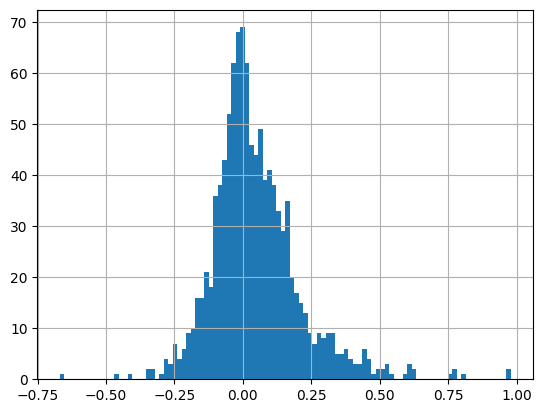

In [ ]:
df_rel.close.hist(bins=100)

In [ ]:
df_rel.notna().sum(axis=1)

0       42
1       86
2       86
3       86
4       86
        ..
1113    42
1114    85
1115    85
1116    85
1117    85
Length: 1118, dtype: int64

In [ ]:
# Удаляю строки которые при вычислении относительных изменений получились Nan
df_rel = df_rel.dropna(thresh=43)

In [ ]:
df_rel

Дата_оконч_периода Дата_цены_акции     Доход  Рост_выручки_год_к_году  \
1            2014-03-31      2014-05-29  0.064216               -15.250000   
2            2014-06-30      2014-08-29  0.033992                 0.578947   
3            2014-09-30      2014-10-21  0.188346                -0.311111   
4            2014-12-31      2015-03-03 -0.076057                 2.357888   
5            2015-03-31      2015-05-25  0.010882                -0.290838   
...                 ...             ...       ...                      ...   
1112         2021-09-30      2021-12-01  0.262890                -1.540984   
1114         2020-12-31      2021-04-02  0.000000                 0.000000   
1115         2021-03-31      2021-06-01 -0.026534                -0.696774   
1116         2021-06-30      2021-08-31  0.000000                 0.000000   
1117         2021-09-30      2021-12-01  0.280367                -3.617021   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
1                  0.000000               NaN   
2                  0.015686               NaN   
3                  0.030888               NaN   
4                  0.243446               NaN   
5                 -0.198795               0.0   
...                     ...               ...   
1112              -0.049521               NaN   
1114               0.000000               NaN   
1115              -0.098940               NaN   
1116               0.000000               NaN   
1117               0.588235               NaN   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
1                                             -0.206282       
2                                             -0.017936       
3                                              0.295049       
4                                             -0.025015       
5                                             -0.084138       
...                                                 ...       
1112                                           0.202119       
1114                                           0.000000       
1115                                          -0.046546       
1116                                           0.000000       
1117                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
5                                  NaN                             3.306207   
...                                ...                                  ...   
1112                               NaN                            -0.195846   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      Доходы_от_прекращенной_деятельности  ...  Тикер_SBER  Тикер_SELG  \
1                                     NaN  ...           0           0   
2                                     NaN  ...           0           0   
3                                     NaN  ...           0           0   
4                                     NaN  ...           0           0   
5                                     NaN  ...           0           0   
...                                   ...  ...         ...         ...   
1112                                  0.0  ...           0           0   
1114                                  NaN  ...           0           0   
1115                                  NaN  ...           0           0   
1116                             

<Axes: >

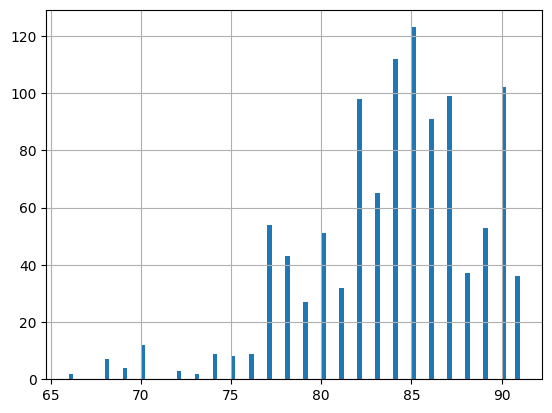

In [ ]:
df_rel.notna().sum(axis=1).hist(bins=100)

In [ ]:
df_rel.replace({np.nan: 0}, inplace=True)
df_rel

<ipython-input-88-1326221f8eef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rel.replace({np.nan: 0}, inplace=True)


Дата_оконч_периода Дата_цены_акции     Доход  Рост_выручки_год_к_году  \
1            2014-03-31      2014-05-29  0.064216               -15.250000   
2            2014-06-30      2014-08-29  0.033992                 0.578947   
3            2014-09-30      2014-10-21  0.188346                -0.311111   
4            2014-12-31      2015-03-03 -0.076057                 2.357888   
5            2015-03-31      2015-05-25  0.010882                -0.290838   
...                 ...             ...       ...                      ...   
1112         2021-09-30      2021-12-01  0.262890                -1.540984   
1114         2020-12-31      2021-04-02  0.000000                 0.000000   
1115         2021-03-31      2021-06-01 -0.026534                -0.696774   
1116         2021-06-30      2021-08-31  0.000000                 0.000000   
1117         2021-09-30      2021-12-01  0.280367                -3.617021   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
1                  0.000000               0.0   
2                  0.015686               0.0   
3                  0.030888               0.0   
4                  0.243446               0.0   
5                 -0.198795               0.0   
...                     ...               ...   
1112              -0.049521               0.0   
1114               0.000000               0.0   
1115              -0.098940               0.0   
1116               0.000000               0.0   
1117               0.588235               0.0   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
1                                             -0.206282       
2                                             -0.017936       
3                                              0.295049       
4                                             -0.025015       
5                                             -0.084138       
...                                                 ...       
1112                                           0.202119       
1114                                           0.000000       
1115                                          -0.046546       
1116                                           0.000000       
1117                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
1                             0.000000                             0.045321   
2                             0.000000                             0.070394   
3                             0.000000                             0.226729   
4                             0.000000                            -0.574795   
5                             0.000000                             3.306207   
...                                ...                                  ...   
1112                          0.000000                            -0.195846   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      Доходы_от_прекращенной_деятельности  ...  Тикер_SBER  Тикер_SELG  \
1                                     0.0  ...           0           0   
2                                     0.0  ...           0           0   
3                                     0.0  ...           0           0   
4                                     0.0  ...           0           0   
5                                     0.0  ...           0           0   
...                                   ...  ...         ...         ...   
1112                                  0.0  ...           0           0   
1114                                  0.0  ...           0           0   
1115                                  0.0  ...           0           0   
1116                             

In [ ]:
# сохраним полученный датасет для дальнейшей возможности загрузки,
# чтобы не проводить все операции выше при отключении от colab
df_rel.to_excel('dataset_MOEX_finale_pct_change(periods=1).xlsx')

In [ ]:
df_rel = pd.read_excel('/content/drive/MyDrive/Classroom/DS ИИ RN ПМ/Финальный проект/dataset_MOEX_finale_pct_change(periods=1).xlsx')

## Разбиение на обучающую и тестовую выборки

In [ ]:
train = df_rel[(df_rel['Дата_оконч_периода']<='2018-12-31')]
len(train)

672

In [ ]:
test = df_rel[(df_rel['Дата_оконч_периода']>'2018-12-31')&(df_rel['Дата_оконч_периода']<='2019-12-31')]
len(test)

141

In [ ]:
len(train)/len(df_rel)

0.6227988878591288

In [ ]:
X_train = train.drop(columns=['close', 'Дата_оконч_периода', 'Дата_цены_акции'])
y_train = train['close']

In [ ]:
X_test = test.drop(columns=['close', 'Дата_оконч_периода', 'Дата_цены_акции'])
y_test = test['close']

## Линейная регрессия с регуляризацией

In [ ]:
best_params_ridge = gridsearch(
    X_train, y_train,
    Ridge(),
    {
        "alpha": np.logspace(-2, 3, 21), # default = 1.0
        "tol": np.logspace(-5, 0, 21), # default=1e-3
    }
)

pred_ridge = model_train_test(
    X_train,
    y_train,
    X_test,
    y_test,
    Ridge(**best_params_ridge)
)

Best hyperparameters: {'alpha': 1000.0, 'tol': 1e-05}
MAE test: 0.12457818793290153
MAE train: 0.11019752226361733
RMSE test: 0.20305545198169386
RMSE train: 0.15269942569639744
R2 test: -0.7473311490788963
R2 train: 0.0998365438126626
MAPE test: 1.5443434288079076
MAPE train: 2.465689883574676


In [ ]:
best_params_lasso = gridsearch(
    X_train, y_train,
    Lasso(),
    {
        "alpha": np.logspace(-2, 3, 21), # default = 1.0
        "tol": np.logspace(-5, 0, 21), # default=1e-4

    }
)

pred_lasso = model_train_test(
    X_train,
    y_train,
    X_test,
    y_test,
    Lasso(**best_params_lasso)
)

Best hyperparameters: {'alpha': 17.78279410038923, 'tol': 1e-05}
MAE test: 0.11473617665167582
MAE train: 0.11605900106614622
RMSE test: 0.15611578913657545
RMSE train: 0.1609447129696486
R2 test: -0.03285550124424219
R2 train: 0.0
MAPE test: 4.528244143258815
MAPE train: 2.686869882353341


## RandomForestRegressor

In [ ]:
# Воспользуем функцией RandomizedSearchCV
# В качестве определения "лучшей" модели выберем MSE
from sklearn.model_selection import RandomizedSearchCV
random_searcher = RandomizedSearchCV(
            RandomForestRegressor(),          # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(2, 20),
                'max_features': range(2, 11),
                'n_estimators': range(50, 200)
            },
            scoring = 'neg_mean_squared_error',
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=10,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
random_searcher.fit(X_train, y_train)

# Выведем набор лучших параметров и лучшую метрику
print(f"Лучшая метрика:   {random_searcher.best_score_}")
print(f"Лучшие параметры: {random_searcher.best_params_}")
y_train_pred = random_searcher.predict(X_train)
y_test_pred = random_searcher.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшая метрика:   -0.02490603715015358
Лучшие параметры: {'n_estimators': 179, 'max_features': 10, 'max_depth': 8}


In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 0.10694517196660427
MAE train: 0.08428209535898341
RMSE test: 0.14999201403578144
RMSE train: 0.10973254116091066
R2 test: 0.0465845549795636
R2 train: 0.5351450671950815
MAPE test: 3.043319251993201
MAPE train: 1.9286402993839096


## CatBoostRegressor

In [ ]:
# Воспользуем функцией RandomizedSearchCV
# В качестве определения "лучшей" модели выберем MSE
from sklearn.model_selection import RandomizedSearchCV
random_searcher = RandomizedSearchCV(
            cb.CatBoostRegressor(verbose=0),          # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(2, 7),
                'learning_rate': np.linspace(0.001, 0.3, 100),
            },
            scoring = 'neg_mean_squared_error',
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=10,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
random_searcher.fit(X_train, y_train)

# Выведем набор лучших параметров и лучшую метрику
print(f"Лучшая метрика:   {random_searcher.best_score_}")
print(f"Лучшие параметры: {random_searcher.best_params_}")
y_train_pred = random_searcher.predict(X_train)
y_test_pred = random_searcher.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшая метрика:   -0.025450235319860667
Лучшие параметры: {'max_depth': 6, 'learning_rate': 0.046303030303030304}


In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 0.1112302586585927
MAE train: 0.01707756330605683
RMSE test: 0.15093419769974928
RMSE train: 0.023367358468117185
R2 test: 0.0345690646678235
R2 train: 0.9789202326957106
MAPE test: 3.903680645219359
MAPE train: 0.6028770551110051


## LGBM

In [ ]:
# Воспользуем функцией RandomizedSearchCV
# В качестве определения "лучшей" модели выберем MSE

from sklearn.model_selection import RandomizedSearchCV
grid_LGBM = RandomizedSearchCV(
            lgb.LGBMRegressor(verbose=0),          # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(2, 200),
                'learning_rate': np.linspace(0.001, 0.3, 100),
            },
            scoring = 'neg_mean_squared_error',
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=10,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 2,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
grid_LGBM.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

RandomizedSearchCV(cv=3, estimator=LGBMRegressor(verbose=0), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.001     , 0.0040202 , 0.0070404 , 0.01006061, 0.01308081,
       0.01610101, 0.01912121, 0.02214141, 0.02516162, 0.02818182,
       0.03120202, 0.03422222, 0.03724242, 0.04026263, 0.04328283,
       0.04630303, 0.04932323, 0.05234343, 0.05536364, 0.05838384,
       0.06140404, 0.06442424, 0....
       0.22751515, 0.23053535, 0.23355556, 0.23657576, 0.23959596,
       0.24261616, 0.24563636, 0.24865657, 0.25167677, 0.25469697,
       0.25771717, 0.26073737, 0.26375758, 0.26677778, 0.26979798,
       0.27281818, 0.27583838, 0.27885859, 0.28187879, 0.28489899,
       0.28791919, 0.29093939, 0.2939596 , 0.2969798 , 0.3       ]),
                                        'max_depth': range(2, 200)},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
# Выведем набор лучших параметров и лучшую метрику
print(f"Лучшая метрика:   {grid_LGBM.best_score_}")
print(f"Лучшие параметры: {grid_LGBM.best_params_}")
y_test_pred=grid_LGBM.best_estimator_.predict(X_test)
y_train_pred=grid_LGBM.best_estimator_.predict(X_train)

Лучшая метрика:   -0.02563843663711765
Лучшие параметры: {'max_depth': 141, 'learning_rate': 0.019121212121212122}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 0.1059137027905089
MAE train: 0.07216269555404188
RMSE test: 0.15281053835209424
RMSE train: 0.10625855282658393
R2 test: 0.010416327356949862
R2 train: 0.5641125508456732
MAPE test: 2.3222356831576216
MAPE train: 1.8060055636484742


По всем моделям R2 на тестовой выборке низкое значение, наблюдается переобучение

# Относительные изменения (квартал к кварталу), период до пандемии, 1 акция
Исследуем возможность улучшения предсказания только по одной акции, например, Лукойл

In [ ]:
df_rel = pd.concat([df_finale[cat_cols], df_change], axis=1)
df_rel

Тикер Дата_оконч_периода Дата_цены_акции     Доход  \
0     LKOH         2013-12-31      2014-02-19       NaN   
1     LKOH         2014-03-31      2014-05-29  0.064216   
2     LKOH         2014-06-30      2014-08-29  0.033992   
3     LKOH         2014-09-30      2014-10-21  0.188346   
4     LKOH         2014-12-31      2015-03-03 -0.076057   
...    ...                ...             ...       ...   
1113  GLTR         2020-09-30      2020-12-01       NaN   
1114  GLTR         2020-12-31      2021-04-02  0.000000   
1115  GLTR         2021-03-31      2021-06-01 -0.026534   
1116  GLTR         2021-06-30      2021-08-31  0.000000   
1117  GLTR         2021-09-30      2021-12-01  0.280367   

      Рост_выручки_год_к_году  Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                         NaN                    NaN               NaN   
1                  -15.250000               0.000000               NaN   
2                    0.578947               0.015686               NaN   
3                   -0.311111               0.030888               NaN   
4                    2.357888               0.243446               NaN   
...                       ...                    ...               ...   
1113                      NaN                    NaN               NaN   
1114                 0.000000               0.000000               NaN   
1115                -0.696774              -0.098940               NaN   
1116                 0.000000               0.000000               NaN   
1117                -3.617021               0.588235               NaN   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                                   NaN       
1                                             -0.206282       
2                                             -0.017936       
3                                              0.295049       
4                                             -0.025015       
...                                                 ...       
1113                                                NaN       
1114                                           0.000000       
1115                                          -0.046546       
1116                                           0.000000       
1117                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      ...  Прочая_финансовая_деятельность  Корректировки_курса_обмена_валют  \
0     ...                             NaN                               NaN   
1     ...                       -1.003453                          8.206383   
2     ...                      -25.624872                         -2.482208   
3     ...                       -5.813677                         -2.022466   
4     ...                       -6.216672                        -11.895618   
...   ...                             ...                               ...   
1113  ...                             NaN                               NaN   
1114  ...                        0.000000                          0.

In [ ]:
df_rel_LKOH = df_rel[df_rel['Тикер']=='LKOH']
df_rel_LKOH

Тикер Дата_оконч_периода Дата_цены_акции     Доход  \
0   LKOH         2013-12-31      2014-02-19       NaN   
1   LKOH         2014-03-31      2014-05-29  0.064216   
2   LKOH         2014-06-30      2014-08-29  0.033992   
3   LKOH         2014-09-30      2014-10-21  0.188346   
4   LKOH         2014-12-31      2015-03-03 -0.076057   
5   LKOH         2015-03-31      2015-05-25  0.010882   
6   LKOH         2015-06-30      2015-08-28  0.025454   
7   LKOH         2015-09-30      2015-11-30 -0.008743   
8   LKOH         2015-12-31      2016-04-04 -0.065795   
9   LKOH         2016-03-31      2016-06-06 -0.138955   
10  LKOH         2016-06-30      2016-08-29  0.136952   
11  LKOH         2016-09-30      2016-11-30 -0.022010   
12  LKOH         2016-12-31      2017-03-14  0.069826   
13  LKOH         2017-03-31      2017-05-30  0.021896   
14  LKOH         2017-06-30      2017-08-29 -0.050593   
15  LKOH         2017-09-30      2017-11-29  0.091463   
16  LKOH         2017-12-31      2018-03-21  0.120640   
17  LKOH         2018-03-31      2018-05-28 -0.019083   
18  LKOH         2018-06-30      2018-08-29  0.260822   
19  LKOH         2018-09-30      2018-11-28  0.121508   
20  LKOH         2018-12-31      2019-03-07 -0.113912   
21  LKOH         2019-03-31      2019-05-29 -0.094108   
22  LKOH         2019-06-30      2019-08-28  0.148368   
23  LKOH         2019-09-30      2019-11-26 -0.081499   
24  LKOH         2019-12-31      2020-03-10 -0.092476   
25  LKOH         2020-03-31      2020-06-03 -0.059711   
26  LKOH         2020-06-30      2020-08-27 -0.407902   
27  LKOH         2020-09-30      2020-11-24  0.476693   
28  LKOH         2020-12-31      2021-03-10 -0.040239   
29  LKOH         2021-03-31      2021-05-26  0.342228   
30  LKOH         2021-06-30      2021-08-27  0.173410   
31  LKOH         2021-09-30      2021-11-24  0.175695   

    Рост_выручки_год_к_году  Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                       NaN                    NaN               NaN   
1                -15.250000               0.000000               NaN   
2                  0.578947               0.015686               NaN   
3                 -0.311111               0.030888               NaN   
4                  2.357888               0.243446               NaN   
5                 -0.290838              -0.198795          0.000000   
6                 -0.064186               0.022556          0.000000   
7                 -1.366252              -0.003676          0.000000   
8                 -0.208391              -0.040590          0.009132   
9                  3.543476               0.061538          0.000000   
10                -0.489011              -0.036232          0.000000   
11                 0.139785              -0.018797          0.000000   
12                -1.226415              -0.030651          0.140271   
13                 8.000000               0.098814          0.000000   
14                -0.930556              -0.035971          0.000000   
15                 7.866667               0.007463          0.000000   
16                 0.406015               0.007407         -0.162037   
17                -0.256684               0.000000          0.000000   
18                 2.690647              -0.014706          0.000000   
19                 0.079922               0.029851          0.000000   
20                -0.586643               0.028986         -0.176006   
21                -0.410480               0.084507          0.000000   
22                -0.748148              -0.029221          0.000000   
23                -5.500000               0.040134          0.000000   
24                -0.130719               0.012862         -0.198276   
25                -0.248120              -0.257143          0.000000   
26                 4.360000               0.269231          0.000000   
27                -0.526119              -0.117845          0.000000   
28                -0.169291      

In [ ]:
# Дату отчетного периода закодируем с помощью labelencoder, поскольку важен порядок
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(df_rel_LKOH['Дата_оконч_периода'])
df_rel_LKOH['label_периода'] = enc.transform(df_rel_LKOH['Дата_оконч_периода'])
df_rel_LKOH

<ipython-input-112-7254ae427c48>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rel_LKOH['label_периода'] = enc.transform(df_rel_LKOH['Дата_оконч_периода'])


Тикер Дата_оконч_периода Дата_цены_акции     Доход  \
0   LKOH         2013-12-31      2014-02-19       NaN   
1   LKOH         2014-03-31      2014-05-29  0.064216   
2   LKOH         2014-06-30      2014-08-29  0.033992   
3   LKOH         2014-09-30      2014-10-21  0.188346   
4   LKOH         2014-12-31      2015-03-03 -0.076057   
5   LKOH         2015-03-31      2015-05-25  0.010882   
6   LKOH         2015-06-30      2015-08-28  0.025454   
7   LKOH         2015-09-30      2015-11-30 -0.008743   
8   LKOH         2015-12-31      2016-04-04 -0.065795   
9   LKOH         2016-03-31      2016-06-06 -0.138955   
10  LKOH         2016-06-30      2016-08-29  0.136952   
11  LKOH         2016-09-30      2016-11-30 -0.022010   
12  LKOH         2016-12-31      2017-03-14  0.069826   
13  LKOH         2017-03-31      2017-05-30  0.021896   
14  LKOH         2017-06-30      2017-08-29 -0.050593   
15  LKOH         2017-09-30      2017-11-29  0.091463   
16  LKOH         2017-12-31      2018-03-21  0.120640   
17  LKOH         2018-03-31      2018-05-28 -0.019083   
18  LKOH         2018-06-30      2018-08-29  0.260822   
19  LKOH         2018-09-30      2018-11-28  0.121508   
20  LKOH         2018-12-31      2019-03-07 -0.113912   
21  LKOH         2019-03-31      2019-05-29 -0.094108   
22  LKOH         2019-06-30      2019-08-28  0.148368   
23  LKOH         2019-09-30      2019-11-26 -0.081499   
24  LKOH         2019-12-31      2020-03-10 -0.092476   
25  LKOH         2020-03-31      2020-06-03 -0.059711   
26  LKOH         2020-06-30      2020-08-27 -0.407902   
27  LKOH         2020-09-30      2020-11-24  0.476693   
28  LKOH         2020-12-31      2021-03-10 -0.040239   
29  LKOH         2021-03-31      2021-05-26  0.342228   
30  LKOH         2021-06-30      2021-08-27  0.173410   
31  LKOH         2021-09-30      2021-11-24  0.175695   

    Рост_выручки_год_к_году  Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                       NaN                    NaN               NaN   
1                -15.250000               0.000000               NaN   
2                  0.578947               0.015686               NaN   
3                 -0.311111               0.030888               NaN   
4                  2.357888               0.243446               NaN   
5                 -0.290838              -0.198795          0.000000   
6                 -0.064186               0.022556          0.000000   
7                 -1.366252              -0.003676          0.000000   
8                 -0.208391              -0.040590          0.009132   
9                  3.543476               0.061538          0.000000   
10                -0.489011              -0.036232          0.000000   
11                 0.139785              -0.018797          0.000000   
12                -1.226415              -0.030651          0.140271   
13                 8.000000               0.098814          0.000000   
14                -0.930556              -0.035971          0.000000   
15                 7.866667               0.007463          0.000000   
16                 0.406015               0.007407         -0.162037   
17                -0.256684               0.000000          0.000000   
18                 2.690647              -0.014706          0.000000   
19                 0.079922               0.029851          0.000000   
20                -0.586643               0.028986         -0.176006   
21                -0.410480               0.084507          0.000000   
22                -0.748148              -0.029221          0.000000   
23                -5.500000               0.040134          0.000000   
24                -0.130719               0.012862         -0.198276   
25                -0.248120              -0.257143          0.000000   
26                 4.360000               0.269231          0.000000   
27                -0.526119              -0.117845          0.000000   
28                -0.169291      

In [ ]:
# Удаляю строки которые при вычислении относительных изменений получились Nan
df_rel_LKOH = df_rel_LKOH.dropna(thresh=43)
df_rel_LKOH

Тикер Дата_оконч_периода Дата_цены_акции     Доход  \
1   LKOH         2014-03-31      2014-05-29  0.064216   
2   LKOH         2014-06-30      2014-08-29  0.033992   
3   LKOH         2014-09-30      2014-10-21  0.188346   
4   LKOH         2014-12-31      2015-03-03 -0.076057   
5   LKOH         2015-03-31      2015-05-25  0.010882   
6   LKOH         2015-06-30      2015-08-28  0.025454   
7   LKOH         2015-09-30      2015-11-30 -0.008743   
8   LKOH         2015-12-31      2016-04-04 -0.065795   
9   LKOH         2016-03-31      2016-06-06 -0.138955   
10  LKOH         2016-06-30      2016-08-29  0.136952   
11  LKOH         2016-09-30      2016-11-30 -0.022010   
12  LKOH         2016-12-31      2017-03-14  0.069826   
13  LKOH         2017-03-31      2017-05-30  0.021896   
14  LKOH         2017-06-30      2017-08-29 -0.050593   
15  LKOH         2017-09-30      2017-11-29  0.091463   
16  LKOH         2017-12-31      2018-03-21  0.120640   
17  LKOH         2018-03-31      2018-05-28 -0.019083   
18  LKOH         2018-06-30      2018-08-29  0.260822   
19  LKOH         2018-09-30      2018-11-28  0.121508   
20  LKOH         2018-12-31      2019-03-07 -0.113912   
21  LKOH         2019-03-31      2019-05-29 -0.094108   
22  LKOH         2019-06-30      2019-08-28  0.148368   
23  LKOH         2019-09-30      2019-11-26 -0.081499   
24  LKOH         2019-12-31      2020-03-10 -0.092476   
25  LKOH         2020-03-31      2020-06-03 -0.059711   
26  LKOH         2020-06-30      2020-08-27 -0.407902   
27  LKOH         2020-09-30      2020-11-24  0.476693   
28  LKOH         2020-12-31      2021-03-10 -0.040239   
29  LKOH         2021-03-31      2021-05-26  0.342228   
30  LKOH         2021-06-30      2021-08-27  0.173410   
31  LKOH         2021-09-30      2021-11-24  0.175695   

    Рост_выручки_год_к_году  Маржа_валовой_прибыли  Расходы_на_НИОКР  \
1                -15.250000               0.000000               NaN   
2                  0.578947               0.015686               NaN   
3                 -0.311111               0.030888               NaN   
4                  2.357888               0.243446               NaN   
5                 -0.290838              -0.198795          0.000000   
6                 -0.064186               0.022556          0.000000   
7                 -1.366252              -0.003676          0.000000   
8                 -0.208391              -0.040590          0.009132   
9                  3.543476               0.061538          0.000000   
10                -0.489011              -0.036232          0.000000   
11                 0.139785              -0.018797          0.000000   
12                -1.226415              -0.030651          0.140271   
13                 8.000000               0.098814          0.000000   
14                -0.930556              -0.035971          0.000000   
15                 7.866667               0.007463          0.000000   
16                 0.406015               0.007407         -0.162037   
17                -0.256684               0.000000          0.000000   
18                 2.690647              -0.014706          0.000000   
19                 0.079922               0.029851          0.000000   
20                -0.586643               0.028986         -0.176006   
21                -0.410480               0.084507          0.000000   
22                -0.748148              -0.029221          0.000000   
23                -5.500000               0.040134          0.000000   
24                -0.130719               0.012862         -0.198276   
25                -0.248120              -0.257143          0.000000   
26                 4.360000               0.269231          0.000000   
27                -0.526119              -0.117845          0.000000   
28                -0.169291               0.083969          0.095579   
29                -1.597156               0.119718          0.000000   
30                

In [ ]:
df_rel_LKOH.replace({np.nan: 0}, inplace=True)
df_rel_LKOH

<ipython-input-114-88096c32cbc7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rel_LKOH.replace({np.nan: 0}, inplace=True)


Тикер Дата_оконч_периода Дата_цены_акции     Доход  \
1   LKOH         2014-03-31      2014-05-29  0.064216   
2   LKOH         2014-06-30      2014-08-29  0.033992   
3   LKOH         2014-09-30      2014-10-21  0.188346   
4   LKOH         2014-12-31      2015-03-03 -0.076057   
5   LKOH         2015-03-31      2015-05-25  0.010882   
6   LKOH         2015-06-30      2015-08-28  0.025454   
7   LKOH         2015-09-30      2015-11-30 -0.008743   
8   LKOH         2015-12-31      2016-04-04 -0.065795   
9   LKOH         2016-03-31      2016-06-06 -0.138955   
10  LKOH         2016-06-30      2016-08-29  0.136952   
11  LKOH         2016-09-30      2016-11-30 -0.022010   
12  LKOH         2016-12-31      2017-03-14  0.069826   
13  LKOH         2017-03-31      2017-05-30  0.021896   
14  LKOH         2017-06-30      2017-08-29 -0.050593   
15  LKOH         2017-09-30      2017-11-29  0.091463   
16  LKOH         2017-12-31      2018-03-21  0.120640   
17  LKOH         2018-03-31      2018-05-28 -0.019083   
18  LKOH         2018-06-30      2018-08-29  0.260822   
19  LKOH         2018-09-30      2018-11-28  0.121508   
20  LKOH         2018-12-31      2019-03-07 -0.113912   
21  LKOH         2019-03-31      2019-05-29 -0.094108   
22  LKOH         2019-06-30      2019-08-28  0.148368   
23  LKOH         2019-09-30      2019-11-26 -0.081499   
24  LKOH         2019-12-31      2020-03-10 -0.092476   
25  LKOH         2020-03-31      2020-06-03 -0.059711   
26  LKOH         2020-06-30      2020-08-27 -0.407902   
27  LKOH         2020-09-30      2020-11-24  0.476693   
28  LKOH         2020-12-31      2021-03-10 -0.040239   
29  LKOH         2021-03-31      2021-05-26  0.342228   
30  LKOH         2021-06-30      2021-08-27  0.173410   
31  LKOH         2021-09-30      2021-11-24  0.175695   

    Рост_выручки_год_к_году  Маржа_валовой_прибыли  Расходы_на_НИОКР  \
1                -15.250000               0.000000          0.000000   
2                  0.578947               0.015686          0.000000   
3                 -0.311111               0.030888          0.000000   
4                  2.357888               0.243446          0.000000   
5                 -0.290838              -0.198795          0.000000   
6                 -0.064186               0.022556          0.000000   
7                 -1.366252              -0.003676          0.000000   
8                 -0.208391              -0.040590          0.009132   
9                  3.543476               0.061538          0.000000   
10                -0.489011              -0.036232          0.000000   
11                 0.139785              -0.018797          0.000000   
12                -1.226415              -0.030651          0.140271   
13                 8.000000               0.098814          0.000000   
14                -0.930556              -0.035971          0.000000   
15                 7.866667               0.007463          0.000000   
16                 0.406015               0.007407         -0.162037   
17                -0.256684               0.000000          0.000000   
18                 2.690647              -0.014706          0.000000   
19                 0.079922               0.029851          0.000000   
20                -0.586643               0.028986         -0.176006   
21                -0.410480               0.084507          0.000000   
22                -0.748148              -0.029221          0.000000   
23                -5.500000               0.040134          0.000000   
24                -0.130719               0.012862         -0.198276   
25                -0.248120              -0.257143          0.000000   
26                 4.360000               0.269231          0.000000   
27                -0.526119              -0.117845          0.000000   
28                -0.169291               0.083969          0.095579   
29                -1.597156               0.119718          0.000000   
30                

## Разбиение на обучающую и тестовую выборки

In [ ]:
train = df_rel_LKOH[(df_rel_LKOH['Дата_оконч_периода']<='2018-12-31')]
len(train)

20

In [ ]:
test = df_rel_LKOH[(df_rel_LKOH['Дата_оконч_периода']>'2018-12-31')&(df_rel_LKOH['Дата_оконч_периода']<='2019-12-31')]
len(test)

4

In [ ]:
len(train)/len(df_rel_LKOH)

0.6451612903225806

In [ ]:
X_train = train.drop(columns=['close', 'Дата_оконч_периода', 'Дата_цены_акции', 'Тикер'])
y_train = train['close']

In [ ]:
X_test = test.drop(columns=['close', 'Дата_оконч_периода', 'Дата_цены_акции', 'Тикер'])
y_test = test['close']

## Линейная регрессия с регуляризацией

In [ ]:
best_params_ridge = gridsearch(
    X_train, y_train,
    Ridge(),
    {
        "alpha": np.logspace(-2, 3, 21), # default = 1.0
        "tol": np.logspace(-5, 0, 21), # default=1e-3
    }
)

pred_ridge = model_train_test(
    X_train,
    y_train,
    X_test,
    y_test,
    Ridge(**best_params_ridge)
)

Best hyperparameters: {'alpha': 1000.0, 'tol': 1e-05}
MAE test: 0.20017417072827498
MAE train: 0.06652445887950326
RMSE test: 0.22357314072776605
RMSE train: 0.10251129818598252
R2 test: -1.2514613832200605
R2 train: 0.429895074333142
MAPE test: 4.468230673420331
MAPE train: 0.8586128830867568


In [ ]:
best_params_lasso = gridsearch(
    X_train, y_train,
    Lasso(),
    {
        "alpha": np.logspace(-2, 3, 21), # default = 1.0
        "tol": np.logspace(-5, 0, 21), # default=1e-4

    }
)

pred_lasso = model_train_test(
    X_train,
    y_train,
    X_test,
    y_test,
    Lasso(**best_params_lasso)
)

Best hyperparameters: {'alpha': 56.23413251903491, 'tol': 1e-05}
MAE test: 0.15567786567922148
MAE train: 0.09454434847764538
RMSE test: 0.18099346027901075
RMSE train: 0.13576703598113654
R2 test: -0.4755400877469569
R2 train: 0.0
MAPE test: 2.9323138539265132
MAPE train: 2.0702308635829096


## Линейная регрессия

In [ ]:
# Создаем модель линейной регрессии
model_lr = LinearRegression()

# Обучаем ее на тренировочной части датасета
model_lr.fit(X_train, y_train)

# Получаем предсказание
y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 1.0135018876155861
MAE train: 1.3523904218715189e-15
RMSE test: 1.6489168160267689
RMSE train: 1.709744021144556e-15
R2 test: -121.46803255691746
R2 train: 1.0
MAPE test: 17.48305620493748
MAPE train: 6.298127453358237e-14


# Попробуем оценить стоимость акции на основе темпа роста выручки и размер прибыли на акцию

In [ ]:
df_finale = pd.read_excel('/content/drive/MyDrive/Classroom/DS ИИ RN ПМ/Финальный проект/dataset_MOEX_finale.xlsx')
df_finale = df_finale.drop(columns=['Компания'])

In [ ]:
df_finale.columns = [c.replace(' ', '_') for c in df_finale.columns]
df_finale.columns = [c.replace('-', '_') for c in df_finale.columns]
df_finale.columns = [c.replace('(', '') for c in df_finale.columns]
df_finale.columns = [c.replace(')', '') for c in df_finale.columns]
df_finale.columns = [c.replace('/', '_') for c in df_finale.columns]
df_finale.columns = [c.replace(',', '_') for c in df_finale.columns]

In [ ]:
df_finale.loc[(df_finale['Тикер']=='IRAO')&(df_finale['Дата_оконч_периода']<'2014-12-31'), 'close'] *=100

In [ ]:
df_finale_LKOH = df_finale[df_finale['Тикер']=='LKOH'][['Рост_выручки_год_к_году', 'Разводненная_прибыль_на_акцию_продолж_деятельность', 'Дата_оконч_периода', 'close']]
df_finale_LKOH = df_finale_LKOH.set_index('Дата_оконч_периода')
df_finale_LKOH

Рост_выручки_год_к_году  \
Дата_оконч_периода                            
2013-12-31                        -0.004000   
2014-03-31                         0.057000   
2014-06-30                         0.090000   
2014-09-30                         0.062000   
2014-12-31                         0.208189   
2015-03-31                         0.147640   
2015-06-30                         0.138163   
2015-09-30                        -0.050603   
2015-12-31                        -0.040057   
2016-03-31                        -0.182000   
2016-06-30                        -0.093000   
2016-09-30                        -0.106000   
2016-12-31                         0.024000   
2017-03-31                         0.216000   
2017-06-30                         0.015000   
2017-09-30                         0.133000   
2017-12-31                         0.187000   
2018-03-31                         0.139000   
2018-06-30                         0.513000   
2018-09-30                         0.554000   
2018-12-31                         0.229000   
2019-03-31                         0.135000   
2019-06-30                         0.034000   
2019-09-30                        -0.153000   
2019-12-31                        -0.133000   
2020-03-31                        -0.100000   
2020-06-30                        -0.536000   
2020-09-30                        -0.254000   
2020-12-31                        -0.211000   
2021-03-31                         0.126000   
2021-06-30                         1.232000   
2021-09-30                         0.777000   

                    Разводненная_прибыль_на_акцию_продолж_деятельность   close  
Дата_оконч_периода                                                              
2013-12-31                                                       1.83   2029.1  
2014-03-31                                                      79.23   1977.7  
2014-06-30                                                     105.25   2055.0  
2014-09-30                                                      83.26   1990.0  
2014-12-31                                                      70.03   3009.5  
2015-03-31                                                     143.02   2502.2  
2015-06-30                                                      88.13   2520.0  
2015-09-30                                                     264.25   2534.1  
2015-12-31                                                     -91.22   2692.0  
2016-03-31                                                      60.07   2613.0  
2016-06-30                                                      87.76   2990.5  
2016-09-30                                                      76.87   3188.0  
2016-12-31                                                      65.36   3080.0  
2017-03-31                                                      87.39   2825.0  
2017-06-30                                                     194.91   2894.0  
2017-09-30                                                     137.17   3308.5  
2017-12-31                                                     169.82   3874.0  
2018-03-31                                                     153.68   4290.0  
2018-06-30                                                     235.79   4638.5  
2018-09-30                                                     255.54   4717.5  
2018-12-31                                                     221.31   5677.0  
2019-03-31                                                     210.35   5240.0  
2019-06-30                                                     261.30   5195.0  
2019-09-30                                                     285.01   6060.0  
2019-12-31                                                     178.17   4549.0  
2020-03-31                                                     -71.11   5549.5  
2020-06-30                                                     -28.69   5174.0  
2020-09-30                                                      74.42   

In [ ]:
train = df_finale_LKOH[:'2018-06-30']
len(train)

19

In [ ]:
test = df_finale_LKOH['2018-07-01':'2019-09-30']
len(test)

5

In [ ]:
X_train = train.drop(columns=['close'])
y_train = train['close']

In [ ]:
X_test = test.drop(columns=['close'])
y_test = test['close']

In [ ]:
# Нормализация признаков
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [ ]:
X_train_norm

Рост_выручки_год_к_году  \
Дата_оконч_периода                            
2013-12-31                        -0.536709   
2014-03-31                        -0.130231   
2014-06-30                         0.089666   
2014-09-30                        -0.096914   
2014-12-31                         0.877227   
2015-03-31                         0.473753   
2015-06-30                         0.410606   
2015-09-30                        -0.847249   
2015-12-31                        -0.776981   
2016-03-31                        -1.722825   
2016-06-30                        -1.129767   
2016-09-30                        -1.216393   
2016-12-31                        -0.350129   
2017-03-31                         0.929276   
2017-06-30                        -0.410101   
2017-09-30                         0.376200   
2017-12-31                         0.736033   
2018-03-31                         0.416181   
2018-06-30                         2.908357   

                    Разводненная_прибыль_на_акцию_продолж_деятельность  
Дата_оконч_периода                                                      
2013-12-31                                                  -1.330150   
2014-03-31                                                  -0.341127   
2014-06-30                                                  -0.008642   
2014-09-30                                                  -0.289632   
2014-12-31                                                  -0.458686   
2015-03-31                                                   0.473986   
2015-06-30                                                  -0.227403   
2015-09-30                                                   2.023071   
2015-12-31                                                  -2.519150   
2016-03-31                                                  -0.585955   
2016-06-30                                                  -0.232130   
2016-09-30                                                  -0.371284   
2016-12-31                                                  -0.518359   
2017-03-31                                                  -0.236858   
2017-06-30                                                   1.137040   
2017-09-30                                                   0.399234   
2017-12-31                                                   0.816438   
2018-03-31                                                   0.610200   
2018-06-30                                                   1.659407

In [ ]:
# Создаем модель линейной регрессии
model_lr = LinearRegression()

# Обучаем ее на тренировочной части датасета
model_lr.fit(X_train_norm, y_train)

# Получаем предсказание
y_train_pred = model_lr.predict(X_train_norm)
y_test_pred = model_lr.predict(X_test_norm)

In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 1967.8331284156752
MAE train: 525.1482069499378
RMSE test: 2147.8854810939915
RMSE train: 588.3289101412905
R2 test: -21.109324077229584
R2 train: 0.3373275439337995
MAPE test: 0.35540578947320206
MAPE train: 0.19501786218556905


В качестве целевого признака вычислим P/E

In [ ]:
df_finale_LKOH['PE'] = df_finale_LKOH['close'] / df_finale_LKOH['Разводненная_прибыль_на_акцию_продолж_деятельность']
df_finale_LKOH

Рост_выручки_год_к_году  \
Дата_оконч_периода                            
2013-12-31                        -0.004000   
2014-03-31                         0.057000   
2014-06-30                         0.090000   
2014-09-30                         0.062000   
2014-12-31                         0.208189   
2015-03-31                         0.147640   
2015-06-30                         0.138163   
2015-09-30                        -0.050603   
2015-12-31                        -0.040057   
2016-03-31                        -0.182000   
2016-06-30                        -0.093000   
2016-09-30                        -0.106000   
2016-12-31                         0.024000   
2017-03-31                         0.216000   
2017-06-30                         0.015000   
2017-09-30                         0.133000   
2017-12-31                         0.187000   
2018-03-31                         0.139000   
2018-06-30                         0.513000   
2018-09-30                         0.554000   
2018-12-31                         0.229000   
2019-03-31                         0.135000   
2019-06-30                         0.034000   
2019-09-30                        -0.153000   
2019-12-31                        -0.133000   
2020-03-31                        -0.100000   
2020-06-30                        -0.536000   
2020-09-30                        -0.254000   
2020-12-31                        -0.211000   
2021-03-31                         0.126000   
2021-06-30                         1.232000   
2021-09-30                         0.777000   

                    Разводненная_прибыль_на_акцию_продолж_деятельность  \
Дата_оконч_периода                                                       
2013-12-31                                                       1.83    
2014-03-31                                                      79.23    
2014-06-30                                                     105.25    
2014-09-30                                                      83.26    
2014-12-31                                                      70.03    
2015-03-31                                                     143.02    
2015-06-30                                                      88.13    
2015-09-30                                                     264.25    
2015-12-31                                                     -91.22    
2016-03-31                                                      60.07    
2016-06-30                                                      87.76    
2016-09-30                                                      76.87    
2016-12-31                                                      65.36    
2017-03-31                                                      87.39    
2017-06-30                                                     194.91    
2017-09-30                                                     137.17    
2017-12-31                                                     169.82    
2018-03-31                                                     153.68    
2018-06-30                                                     235.79    
2018-09-30                                                     255.54    
2018-12-31                                                     221.31    
2019-03-31                                                     210.35    
2019-06-30                                                     261.30    
2019-09-30                                                     285.01    
2019-12-31                                                     178.17    
2020-03-31                                                     -71.11    
2020-06-30                                                     -28.69    
2020-09-30                                                      74.42    
2020-12-31                                                      39.15    
2021-03-31                                                     230.69    
2021-06-30                                           

In [ ]:
# не будем включать выброс для 2013-12-31
train = df_finale_LKOH['2014-01-01':'2018-06-30']
test = df_finale_LKOH['2018-07-01':'2019-09-30']

In [ ]:
X_train = train.drop(columns=['close', 'Разводненная_прибыль_на_акцию_продолж_деятельность', 'PE'])
y_train = train['PE']

In [ ]:
X_test = test.drop(columns=['close', 'Разводненная_прибыль_на_акцию_продолж_деятельность', 'PE'])
y_test = test['PE']

In [ ]:
X_test

Рост_выручки_год_к_году
Дата_оконч_периода                         
2018-09-30                            0.554
2018-12-31                            0.229
2019-03-31                            0.135
2019-06-30                            0.034
2019-09-30                           -0.153

In [ ]:
# Создаем модель линейной регрессии
model_lr = LinearRegression()

# Обучаем ее на тренировочной части датасета
model_lr.fit(X_train, y_train)

# Получаем предсказание
y_train_pred = pd.DataFrame(model_lr.predict(X_train), index=X_train.index)
y_test_pred = pd.DataFrame(model_lr.predict(X_test), index=X_test.index)

In [ ]:
print(f'MAE test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MAE train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'RMSE test: {mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'R2 test: {r2_score(y_test, y_test_pred)}')
print(f'R2 train: {r2_score(y_train, y_train_pred)}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_test_pred)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_train_pred)}')

MAE test: 3.144933913234545
MAE train: 11.056540777319594
RMSE test: 3.731535001645811
RMSE train: 16.689504076208266
R2 test: -0.7688000916698903
R2 train: 0.00042368448319229923
MAPE test: 0.15621638663093906
MAPE train: 0.4240158025879117


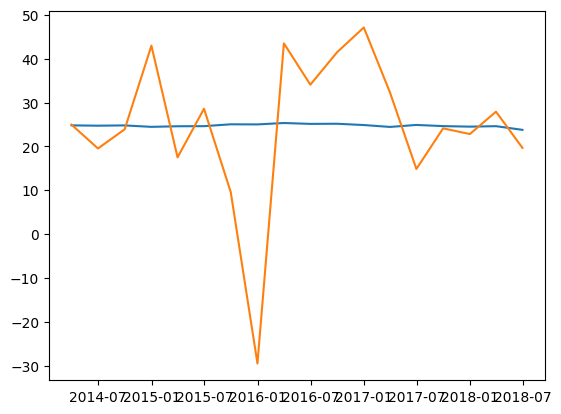

In [ ]:
plt.plot(y_train_pred)
plt.plot(y_train)
plt.show()

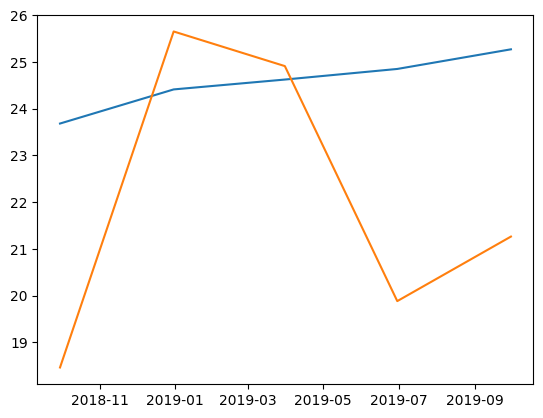

In [ ]:
plt.plot(y_test_pred)
plt.plot(y_test)
plt.show()

In [ ]:
y_test

Дата_оконч_периода
2018-09-30    18.460906
2018-12-31    25.651801
2019-03-31    24.910863
2019-06-30    19.881362
2019-09-30    21.262412
Name: PE, dtype: float64

# Классификация

Относительные изменения (квартал к кварталу), период до пандемии

В связи с тем, что в 2020 года была пандемия и цены акций упали, возможно по этой причине модели плохо предсказывают на тестовой выборке.

Выберем другое разделение данных на обучающую и тестовую выборки в рамках срока до 2020 года

In [ ]:
df_finale = pd.read_excel('/content/drive/MyDrive/Classroom/DS ИИ RN ПМ/Финальный проект/dataset_MOEX_finale.xlsx')
df_finale = df_finale.drop(columns=['Компания'])

In [ ]:
df_finale.columns = [c.replace(' ', '_') for c in df_finale.columns]
df_finale.columns = [c.replace('-', '_') for c in df_finale.columns]
df_finale.columns = [c.replace('(', '') for c in df_finale.columns]
df_finale.columns = [c.replace(')', '') for c in df_finale.columns]
df_finale.columns = [c.replace('/', '_') for c in df_finale.columns]
df_finale.columns = [c.replace(',', '_') for c in df_finale.columns]

In [ ]:
print('Числовые признаки:', len(df_finale.select_dtypes(include=["float", "int64"]).columns.tolist()))
print('Категориальные признаки:', len(df_finale.select_dtypes(include=["object", "datetime64[ns]"]).columns.tolist()))
# Сохраним числовые признаки
numerical_cols = df_finale.select_dtypes(include=["float", "int64"]).columns.tolist()
# добавим тикер в список численных признаков
rel_cols = ["Тикер"] + numerical_cols

Числовые признаки: 53
Категориальные признаки: 3


In [ ]:
# Сохраним категориальные признаки
cat_cols = df_finale.select_dtypes(include=["object", "datetime64[ns]"]).columns.tolist()

В акциях IRAO в начале 2015 года произошел сплит 100 к 1, поэтому умножим значения до конца 2014 года на 100

In [ ]:
df_finale.loc[(df_finale['Тикер']=='IRAO')&(df_finale['Дата_оконч_периода']<'2014-12-31'), 'close'] *=100

In [ ]:
df_finale

Тикер Дата_оконч_периода         Доход  Рост_выручки_год_к_году  \
0     LKOH         2013-12-31  1.179285e+12                -0.004000   
1     LKOH         2014-03-31  1.255015e+12                 0.057000   
2     LKOH         2014-06-30  1.297675e+12                 0.090000   
3     LKOH         2014-09-30  1.542087e+12                 0.062000   
4     LKOH         2014-12-31  1.424800e+12                 0.208189   
...    ...                ...           ...                      ...   
1113  GLTR         2020-09-30  1.647648e+10                -0.310000   
1114  GLTR         2020-12-31  1.647648e+10                -0.310000   
1115  GLTR         2021-03-31  1.603930e+10                -0.094000   
1116  GLTR         2021-06-30  1.603930e+10                -0.094000   
1117  GLTR         2021-09-30  2.053620e+10                 0.246000   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                     0.255                 0   
1                     0.255                 0   
2                     0.259                 0   
3                     0.267                 0   
4                     0.332       -1314000000   
...                     ...               ...   
1113                  0.283                 0   
1114                  0.283                 0   
1115                  0.255                 0   
1116                  0.255                 0   
1117                  0.405                 0   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                         -4.701765e+10       
1                                         -3.731877e+10       
2                                         -3.664942e+10       
3                                         -4.746280e+10       
4                                         -4.627554e+10       
...                                                 ...       
1113                                      -5.971450e+07       
1114                                      -5.971450e+07       
1115                                      -5.693500e+07       
1116                                      -5.693500e+07       
1117                                      -6.776000e+07       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                         0.000000e+00                        -2.792802e+09   
1                         0.000000e+00                        -2.919376e+09   
2                         0.000000e+00                        -3.124881e+09   
3                         0.000000e+00                        -3.833382e+09   
4                         0.000000e+00                        -1.629973e+09   
...                                ...                                  ...   
1113                     -9.889450e+08                        -5.550075e+08   
1114                     -9.889450e+08                        -5.550075e+08   
1115                     -8.602290e+08                        -5.298945e+08   
1116                     -8.602290e+08                        -5.298945e+08   
1117                     -1.162881e+09                        -5.354615e+08   

      Доходы_от_прекращенной_деятельности  ...  \
0                                     0.0  ...   
1                                     0.0  ...   
2                                     0.0  ...   
3                                     0.0  ...   
4                                     0.0  ...   
...                                   ...  ...   
1113                                  0.0  ...   
1114                                  0.0  ...   
1115                                  0.0  ...   
1116                                  0.0  ...   
1117                                  0.0  ...   

      Корректировки_курса_обмена_валют  Дополнения_сокращения  \
0                        -1.642825e+08          -5.282438e+10   
1                        -1.512448e+09           2.707498e+10   
2                         2.241763e+09          -

## Считаем относительные изменения признаков квартал к кварталу

In [ ]:
# чтобы корректно посчитать относительные изменения нужно заменить нулевые значения на Nan
# предполагается, что в данных нет Nan, иначе после этой операции, невозможно будет отличить пропуски от нулевых значений для дальнейшей повторной замены на 0
df_num = df_finale[rel_cols]
df_num.replace({'0':np.nan, 0:np.nan}, inplace=True)
df_num

<ipython-input-8-4a684348b845>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num.replace({'0':np.nan, 0:np.nan}, inplace=True)


Тикер         Доход  Рост_выручки_год_к_году  Маржа_валовой_прибыли  \
0     LKOH  1.179285e+12                -0.004000                  0.255   
1     LKOH  1.255015e+12                 0.057000                  0.255   
2     LKOH  1.297675e+12                 0.090000                  0.259   
3     LKOH  1.542087e+12                 0.062000                  0.267   
4     LKOH  1.424800e+12                 0.208189                  0.332   
...    ...           ...                      ...                    ...   
1113  GLTR  1.647648e+10                -0.310000                  0.283   
1114  GLTR  1.647648e+10                -0.310000                  0.283   
1115  GLTR  1.603930e+10                -0.094000                  0.255   
1116  GLTR  1.603930e+10                -0.094000                  0.255   
1117  GLTR  2.053620e+10                 0.246000                  0.405   

      Расходы_на_НИОКР  Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                  NaN                                      -4.701765e+10       
1                  NaN                                      -3.731877e+10       
2                  NaN                                      -3.664942e+10       
3                  NaN                                      -4.746280e+10       
4        -1.314000e+09                                      -4.627554e+10       
...                ...                                                ...       
1113               NaN                                      -5.971450e+07       
1114               NaN                                      -5.971450e+07       
1115               NaN                                      -5.693500e+07       
1116               NaN                                      -5.693500e+07       
1117               NaN                                      -6.776000e+07       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                        -2.792802e+09   
1                                  NaN                        -2.919376e+09   
2                                  NaN                        -3.124881e+09   
3                                  NaN                        -3.833382e+09   
4                                  NaN                        -1.629973e+09   
...                                ...                                  ...   
1113                     -9.889450e+08                        -5.550075e+08   
1114                     -9.889450e+08                        -5.550075e+08   
1115                     -8.602290e+08                        -5.298945e+08   
1116                     -8.602290e+08                        -5.298945e+08   
1117                     -1.162881e+09                        -5.354615e+08   

      Доходы_от_прекращенной_деятельности  Расходы_по_налогу_на_прибыль  ...  \
0                                     NaN                 -1.764394e+10  ...   
1                                     NaN                 -2.346052e+10  ...   
2                                     NaN                 -1.599803e+10  ...   
3                                     NaN                 -3.291966e+10  ...   
4                                     NaN                 -3.019093e+10  ...   
...                                   ...                           ...  ...   
1113                                  NaN                 -1.088385e+09  ...   
1114                                  NaN                 -1.088385e+09  ...   
1115                                  NaN                 -6.761000e+08  ...   
1116                                  NaN                 -6.761000e+08  ...   
1117                                  NaN                 -1.493138e+09  ...   

      Прочая_финансовая_деятельность  Корректировки_курса_обмена_валют  \
0                      -2.037103e+10                     -1.642825e+08   
1                       7.034640e+07                     -1.5

In [ ]:
df_change = df_num.groupby('Тикер').pct_change(periods=1)
df_change

Доход  Рост_выручки_год_к_году  Маржа_валовой_прибыли  \
0          NaN                      NaN                    NaN   
1     0.064216               -15.250000               0.000000   
2     0.033992                 0.578947               0.015686   
3     0.188346                -0.311111               0.030888   
4    -0.076057                 2.357888               0.243446   
...        ...                      ...                    ...   
1113       NaN                      NaN                    NaN   
1114  0.000000                 0.000000               0.000000   
1115 -0.026534                -0.696774              -0.098940   
1116  0.000000                 0.000000               0.000000   
1117  0.280367                -3.617021               0.588235   

      Расходы_на_НИОКР  Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                  NaN                                                NaN       
1                  NaN                                          -0.206282       
2                  NaN                                          -0.017936       
3                  NaN                                           0.295049       
4                  NaN                                          -0.025015       
...                ...                                                ...       
1113               NaN                                                NaN       
1114               NaN                                           0.000000       
1115               NaN                                          -0.046546       
1116               NaN                                           0.000000       
1117               NaN                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      Доходы_от_прекращенной_деятельности  Расходы_по_налогу_на_прибыль  \
0                                     NaN                           NaN   
1                                     NaN                      0.329665   
2                                     NaN                     -0.318087   
3                                     NaN                      1.057732   
4                                     NaN                     -0.082891   
...                                   ...                           ...   
1113                                  NaN                           NaN   
1114                                  NaN                      0.000000   
1115                                  NaN                     -0.378804   
1116                                  NaN                      0.000000   
1117                                  NaN                      1.208457   

      Миноритарная_доля_в_прибыли  ...  Прочая_финансовая_деятельность  \
0                             NaN  ...                             NaN   
1                       -1.022419  ...                       -1.003453   
2                        1.655623  ...                      -25.624872   
3                       -0.048049  ...                       -5.813677   
4                      

In [ ]:
# при подсчете относительного изменения могло произойти деление на ноль, поэтому меняем inf на Nan
df_change.replace([np.inf, -np.inf], np.nan, inplace=True)
df_change

Доход  Рост_выручки_год_к_году  Маржа_валовой_прибыли  \
0          NaN                      NaN                    NaN   
1     0.064216               -15.250000               0.000000   
2     0.033992                 0.578947               0.015686   
3     0.188346                -0.311111               0.030888   
4    -0.076057                 2.357888               0.243446   
...        ...                      ...                    ...   
1113       NaN                      NaN                    NaN   
1114  0.000000                 0.000000               0.000000   
1115 -0.026534                -0.696774              -0.098940   
1116  0.000000                 0.000000               0.000000   
1117  0.280367                -3.617021               0.588235   

      Расходы_на_НИОКР  Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                  NaN                                                NaN       
1                  NaN                                          -0.206282       
2                  NaN                                          -0.017936       
3                  NaN                                           0.295049       
4                  NaN                                          -0.025015       
...                ...                                                ...       
1113               NaN                                                NaN       
1114               NaN                                           0.000000       
1115               NaN                                          -0.046546       
1116               NaN                                           0.000000       
1117               NaN                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      Доходы_от_прекращенной_деятельности  Расходы_по_налогу_на_прибыль  \
0                                     NaN                           NaN   
1                                     NaN                      0.329665   
2                                     NaN                     -0.318087   
3                                     NaN                      1.057732   
4                                     NaN                     -0.082891   
...                                   ...                           ...   
1113                                  NaN                           NaN   
1114                                  NaN                      0.000000   
1115                                  NaN                     -0.378804   
1116                                  NaN                      0.000000   
1117                                  NaN                      1.208457   

      Миноритарная_доля_в_прибыли  ...  Прочая_финансовая_деятельность  \
0                             NaN  ...                             NaN   
1                       -1.022419  ...                       -1.003453   
2                        1.655623  ...                      -25.624872   
3                       -0.048049  ...                       -5.813677   
4                      

In [ ]:
df_rel = pd.concat([df_finale[cat_cols], df_change], axis=1)
df_rel

Тикер Дата_оконч_периода Дата_цены_акции     Доход  \
0     LKOH         2013-12-31      2014-02-19       NaN   
1     LKOH         2014-03-31      2014-05-29  0.064216   
2     LKOH         2014-06-30      2014-08-29  0.033992   
3     LKOH         2014-09-30      2014-10-21  0.188346   
4     LKOH         2014-12-31      2015-03-03 -0.076057   
...    ...                ...             ...       ...   
1113  GLTR         2020-09-30      2020-12-01       NaN   
1114  GLTR         2020-12-31      2021-04-02  0.000000   
1115  GLTR         2021-03-31      2021-06-01 -0.026534   
1116  GLTR         2021-06-30      2021-08-31  0.000000   
1117  GLTR         2021-09-30      2021-12-01  0.280367   

      Рост_выручки_год_к_году  Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                         NaN                    NaN               NaN   
1                  -15.250000               0.000000               NaN   
2                    0.578947               0.015686               NaN   
3                   -0.311111               0.030888               NaN   
4                    2.357888               0.243446               NaN   
...                       ...                    ...               ...   
1113                      NaN                    NaN               NaN   
1114                 0.000000               0.000000               NaN   
1115                -0.696774              -0.098940               NaN   
1116                 0.000000               0.000000               NaN   
1117                -3.617021               0.588235               NaN   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                                   NaN       
1                                             -0.206282       
2                                             -0.017936       
3                                              0.295049       
4                                             -0.025015       
...                                                 ...       
1113                                                NaN       
1114                                           0.000000       
1115                                          -0.046546       
1116                                           0.000000       
1117                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      ...  Прочая_финансовая_деятельность  Корректировки_курса_обмена_валют  \
0     ...                             NaN                               NaN   
1     ...                       -1.003453                          8.206383   
2     ...                      -25.624872                         -2.482208   
3     ...                       -5.813677                         -2.022466   
4     ...                       -6.216672                        -11.895618   
...   ...                             ...                               ...   
1113  ...                             NaN                               NaN   
1114  ...                        0.000000                          0.

## Кодируем категориальные признаки

In [ ]:
# Тикеры закодируем с помощью one-hot-encoding
df_rel = pd.get_dummies(df_rel,
                         columns = ['Тикер'])
df_rel

Дата_оконч_периода Дата_цены_акции     Доход  Рост_выручки_год_к_году  \
0            2013-12-31      2014-02-19       NaN                      NaN   
1            2014-03-31      2014-05-29  0.064216               -15.250000   
2            2014-06-30      2014-08-29  0.033992                 0.578947   
3            2014-09-30      2014-10-21  0.188346                -0.311111   
4            2014-12-31      2015-03-03 -0.076057                 2.357888   
...                 ...             ...       ...                      ...   
1113         2020-09-30      2020-12-01       NaN                      NaN   
1114         2020-12-31      2021-04-02  0.000000                 0.000000   
1115         2021-03-31      2021-06-01 -0.026534                -0.696774   
1116         2021-06-30      2021-08-31  0.000000                 0.000000   
1117         2021-09-30      2021-12-01  0.280367                -3.617021   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                       NaN               NaN   
1                  0.000000               NaN   
2                  0.015686               NaN   
3                  0.030888               NaN   
4                  0.243446               NaN   
...                     ...               ...   
1113                    NaN               NaN   
1114               0.000000               NaN   
1115              -0.098940               NaN   
1116               0.000000               NaN   
1117               0.588235               NaN   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                                   NaN       
1                                             -0.206282       
2                                             -0.017936       
3                                              0.295049       
4                                             -0.025015       
...                                                 ...       
1113                                                NaN       
1114                                           0.000000       
1115                                          -0.046546       
1116                                           0.000000       
1117                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      Доходы_от_прекращенной_деятельности  ...  Тикер_RUAL  Тикер_SBER  \
0                                     NaN  ...           0           0   
1                                     NaN  ...           0           0   
2                                     NaN  ...           0           0   
3                                     NaN  ...           0           0   
4                                     NaN  ...           0           0   
...                                   ...  ...         ...         ...   
1113                                  NaN  ...           0           0   
1114                                  NaN  ...           0           0   
1115                                  NaN  ...           0           0   
1116                             

In [ ]:
# Дату отчетного периода закодируем с помощью labelencoder, поскольку важен порядок
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(df_rel['Дата_оконч_периода'])
df_rel['label_периода'] = enc.transform(df_rel['Дата_оконч_периода'])
df_rel

Дата_оконч_периода Дата_цены_акции     Доход  Рост_выручки_год_к_году  \
0            2013-12-31      2014-02-19       NaN                      NaN   
1            2014-03-31      2014-05-29  0.064216               -15.250000   
2            2014-06-30      2014-08-29  0.033992                 0.578947   
3            2014-09-30      2014-10-21  0.188346                -0.311111   
4            2014-12-31      2015-03-03 -0.076057                 2.357888   
...                 ...             ...       ...                      ...   
1113         2020-09-30      2020-12-01       NaN                      NaN   
1114         2020-12-31      2021-04-02  0.000000                 0.000000   
1115         2021-03-31      2021-06-01 -0.026534                -0.696774   
1116         2021-06-30      2021-08-31  0.000000                 0.000000   
1117         2021-09-30      2021-12-01  0.280367                -3.617021   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
0                       NaN               NaN   
1                  0.000000               NaN   
2                  0.015686               NaN   
3                  0.030888               NaN   
4                  0.243446               NaN   
...                     ...               ...   
1113                    NaN               NaN   
1114               0.000000               NaN   
1115              -0.098940               NaN   
1116               0.000000               NaN   
1117               0.588235               NaN   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
0                                                   NaN       
1                                             -0.206282       
2                                             -0.017936       
3                                              0.295049       
4                                             -0.025015       
...                                                 ...       
1113                                                NaN       
1114                                           0.000000       
1115                                          -0.046546       
1116                                           0.000000       
1117                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
0                                  NaN                                  NaN   
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
...                                ...                                  ...   
1113                               NaN                                  NaN   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      Доходы_от_прекращенной_деятельности  ...  Тикер_SBER  Тикер_SELG  \
0                                     NaN  ...           0           0   
1                                     NaN  ...           0           0   
2                                     NaN  ...           0           0   
3                                     NaN  ...           0           0   
4                                     NaN  ...           0           0   
...                                   ...  ...         ...         ...   
1113                                  NaN  ...           0           0   
1114                                  NaN  ...           0           0   
1115                                  NaN  ...           0           0   
1116                             

## Чистим данные после вычисления относительных изменений

In [ ]:
# Удаляю строки которые при вычислении относительных изменений получились Nan
df_rel = df_rel.dropna(thresh=43)

In [ ]:
df_rel

Дата_оконч_периода Дата_цены_акции     Доход  Рост_выручки_год_к_году  \
1            2014-03-31      2014-05-29  0.064216               -15.250000   
2            2014-06-30      2014-08-29  0.033992                 0.578947   
3            2014-09-30      2014-10-21  0.188346                -0.311111   
4            2014-12-31      2015-03-03 -0.076057                 2.357888   
5            2015-03-31      2015-05-25  0.010882                -0.290838   
...                 ...             ...       ...                      ...   
1112         2021-09-30      2021-12-01  0.262890                -1.540984   
1114         2020-12-31      2021-04-02  0.000000                 0.000000   
1115         2021-03-31      2021-06-01 -0.026534                -0.696774   
1116         2021-06-30      2021-08-31  0.000000                 0.000000   
1117         2021-09-30      2021-12-01  0.280367                -3.617021   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
1                  0.000000               NaN   
2                  0.015686               NaN   
3                  0.030888               NaN   
4                  0.243446               NaN   
5                 -0.198795               0.0   
...                     ...               ...   
1112              -0.049521               NaN   
1114               0.000000               NaN   
1115              -0.098940               NaN   
1116               0.000000               NaN   
1117               0.588235               NaN   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
1                                             -0.206282       
2                                             -0.017936       
3                                              0.295049       
4                                             -0.025015       
5                                             -0.084138       
...                                                 ...       
1112                                           0.202119       
1114                                           0.000000       
1115                                          -0.046546       
1116                                           0.000000       
1117                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
1                                  NaN                             0.045321   
2                                  NaN                             0.070394   
3                                  NaN                             0.226729   
4                                  NaN                            -0.574795   
5                                  NaN                             3.306207   
...                                ...                                  ...   
1112                               NaN                            -0.195846   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      Доходы_от_прекращенной_деятельности  ...  Тикер_SBER  Тикер_SELG  \
1                                     NaN  ...           0           0   
2                                     NaN  ...           0           0   
3                                     NaN  ...           0           0   
4                                     NaN  ...           0           0   
5                                     NaN  ...           0           0   
...                                   ...  ...         ...         ...   
1112                                  0.0  ...           0           0   
1114                                  NaN  ...           0           0   
1115                                  NaN  ...           0           0   
1116                             

In [ ]:
df_rel.replace({np.nan: 0}, inplace=True)
df_rel

<ipython-input-16-1326221f8eef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rel.replace({np.nan: 0}, inplace=True)


Дата_оконч_периода Дата_цены_акции     Доход  Рост_выручки_год_к_году  \
1            2014-03-31      2014-05-29  0.064216               -15.250000   
2            2014-06-30      2014-08-29  0.033992                 0.578947   
3            2014-09-30      2014-10-21  0.188346                -0.311111   
4            2014-12-31      2015-03-03 -0.076057                 2.357888   
5            2015-03-31      2015-05-25  0.010882                -0.290838   
...                 ...             ...       ...                      ...   
1112         2021-09-30      2021-12-01  0.262890                -1.540984   
1114         2020-12-31      2021-04-02  0.000000                 0.000000   
1115         2021-03-31      2021-06-01 -0.026534                -0.696774   
1116         2021-06-30      2021-08-31  0.000000                 0.000000   
1117         2021-09-30      2021-12-01  0.280367                -3.617021   

      Маржа_валовой_прибыли  Расходы_на_НИОКР  \
1                  0.000000               0.0   
2                  0.015686               0.0   
3                  0.030888               0.0   
4                  0.243446               0.0   
5                 -0.198795               0.0   
...                     ...               ...   
1112              -0.049521               0.0   
1114               0.000000               0.0   
1115              -0.098940               0.0   
1116               0.000000               0.0   
1117               0.588235               0.0   

      Расходы_на_реализацию__общие_и_управленческие_расходы  \
1                                             -0.206282       
2                                             -0.017936       
3                                              0.295049       
4                                             -0.025015       
5                                             -0.084138       
...                                                 ...       
1112                                           0.202119       
1114                                           0.000000       
1115                                          -0.046546       
1116                                           0.000000       
1117                                           0.190129       

      Общие_и_административные_расходы  Чистые_расходы_на_выплату_процентов  \
1                             0.000000                             0.045321   
2                             0.000000                             0.070394   
3                             0.000000                             0.226729   
4                             0.000000                            -0.574795   
5                             0.000000                             3.306207   
...                                ...                                  ...   
1112                          0.000000                            -0.195846   
1114                          0.000000                             0.000000   
1115                         -0.130155                            -0.045248   
1116                          0.000000                             0.000000   
1117                          0.351827                             0.010506   

      Доходы_от_прекращенной_деятельности  ...  Тикер_SBER  Тикер_SELG  \
1                                     0.0  ...           0           0   
2                                     0.0  ...           0           0   
3                                     0.0  ...           0           0   
4                                     0.0  ...           0           0   
5                                     0.0  ...           0           0   
...                                   ...  ...         ...         ...   
1112                                  0.0  ...           0           0   
1114                                  0.0  ...           0           0   
1115                                  0.0  ...           0           0   
1116                             

In [ ]:
# сохраним полученный датасет для дальнейшей возможности загрузки,
# чтобы не проводить все операции выше при отключении от colab
df_rel.to_excel('dataset_MOEX_finale_pct_change(periods=1).xlsx')

In [ ]:
df_rel = pd.read_excel('/content/drive/MyDrive/Classroom/DS ИИ RN ПМ/Финальный проект/dataset_MOEX_finale_pct_change(periods=1).xlsx')

## Разбиение на обучающую и тестовую выборки

In [ ]:
train = df_rel[(df_rel['Дата_оконч_периода']<='2018-12-31')]
len(train)

672

In [ ]:
test = df_rel[(df_rel['Дата_оконч_периода']>'2018-12-31')&(df_rel['Дата_оконч_периода']<='2019-12-31')]
len(test)

141

In [ ]:
len(train)/len(df_rel)

0.6227988878591288

In [ ]:
X_train = train.drop(columns=['close', 'Дата_оконч_периода', 'Дата_цены_акции'])
y_train = 1*(train['close']>0)

In [ ]:
train['close']

1      -0.025331
2       0.039086
3      -0.031630
4       0.512312
5      -0.168566
          ...   
1097   -0.165721
1098   -0.033673
1099    0.008800
1100    0.157711
1101    0.103074
Name: close, Length: 672, dtype: float64

In [ ]:
y_train

1       0
2       1
3       0
4       1
5       0
       ..
1097    0
1098    0
1099    1
1100    1
1101    1
Name: close, Length: 672, dtype: int64

In [ ]:
X_test = test.drop(columns=['close', 'Дата_оконч_периода', 'Дата_цены_акции'])
y_test = 1*(test['close']>0)
y_test

21      0
22      0
23      1
24      0
53      1
       ..
1072    0
1102    0
1103    1
1104    1
1105    1
Name: close, Length: 141, dtype: int64

## CatBoostClassifier

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.8 MB/s eta 0:00:00


In [ ]:
import catboost as cb

In [ ]:
# Воспользуем функцией RandomizedSearchCV
# В качестве определения "лучшей" модели выберем f1_score
from sklearn.model_selection import RandomizedSearchCV
grid_CB = RandomizedSearchCV(
            cb.CatBoostClassifier(verbose=0),          # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(2, 7),
                'learning_rate': np.linspace(0.001, 0.3, 100),
            },
            scoring = 'f1',
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=10,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
grid_CB.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7b529e04c1c0>,
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.001     , 0.0040202 , 0.0070404 , 0.01006061, 0.01308081,
       0.01610101, 0.01912121, 0.02214141, 0.02516162, 0.02818182,
       0.03120202, 0.03422222, 0.03724242, 0.04026263, 0.04328283,
       0.04630303, 0.04932323, 0.05234343, 0.05536364, 0.0...
       0.21241414, 0.21543434, 0.21845455, 0.22147475, 0.22449495,
       0.22751515, 0.23053535, 0.23355556, 0.23657576, 0.23959596,
       0.24261616, 0.24563636, 0.24865657, 0.25167677, 0.25469697,
       0.25771717, 0.26073737, 0.26375758, 0.26677778, 0.26979798,
       0.27281818, 0.27583838, 0.27885859, 0.28187879, 0.28489899,
       0.28791919, 0.29093939, 0.2939596 , 0.2969798 , 0.3       ]),
                                        'max_depth': range(2, 7)},
                   return_train_score=True, scoring='f1', verbose=5)

In [ ]:
# Выведем набор лучших параметров и лучшую метрику

print(f"Лучшая метрика:   {grid_CB.best_score_}")
print(f"Лучшие параметры: {grid_CB.best_params_}")

Лучшая метрика:   0.6494656368396837
Лучшие параметры: {'max_depth': 5, 'learning_rate': 0.022141414141414142}


In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

TEST
              precision    recall  f1-score   support

           0       0.56      0.49      0.52        72
           1       0.53      0.61      0.57        69

    accuracy                           0.55       141
   macro avg       0.55      0.55      0.54       141
weighted avg       0.55      0.55      0.54       141

TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       288
           1       1.00      1.00      1.00       384

    accuracy                           1.00       672
   macro avg       1.00      1.00      1.00       672
weighted avg       1.00      1.00      1.00       672



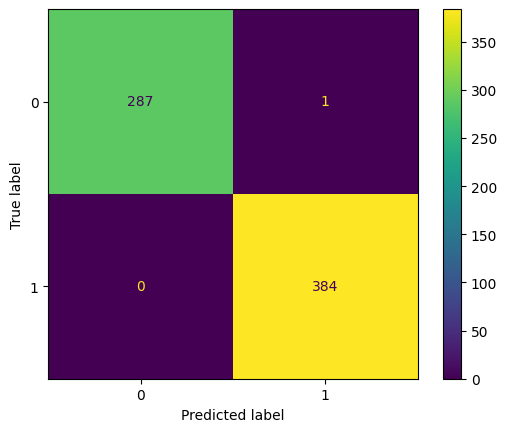

In [ ]:
# Посмотрим как с работой теперь справиться CB

# Получить отчет классификации передав в classification_report реальные метки и предсказанные
print("TEST")
print(classification_report(y_test, grid_CB.best_estimator_.predict(X_test)))
print("TRAIN")
print(classification_report(y_train, grid_CB.best_estimator_.predict(X_train)))

# Посмотреть на матрицу ошибок, передав в plot_confusion_matrix модель, тестовые данные и тестовые метки
confusion_matrix_class_all = confusion_matrix(y_train, grid_CB.best_estimator_.predict(X_train))
ConfusionMatrixDisplay(confusion_matrix_class_all, display_labels=[0, 1]).plot()

plt.show()

Модель явно переобучена

## LGBMClassifier

In [ ]:
# Импортируем LightGBM
import lightgbm as lgb

# Воспользуем функцией RandomizedSearchCV
# В качестве определения "лучшей" модели выберем f1_score

from sklearn.model_selection import RandomizedSearchCV
grid_LGBM = RandomizedSearchCV(
            lgb.LGBMClassifier(verbose=0),          # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(2, 7),
                'learning_rate': np.linspace(0.001, 0.3, 100),
            },
            scoring = 'f1',
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=10,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 0,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
grid_LGBM.fit(X_train, y_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(verbose=0), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.001     , 0.0040202 , 0.0070404 , 0.01006061, 0.01308081,
       0.01610101, 0.01912121, 0.02214141, 0.02516162, 0.02818182,
       0.03120202, 0.03422222, 0.03724242, 0.04026263, 0.04328283,
       0.04630303, 0.04932323, 0.05234343, 0.05536364, 0.05838384,
       0.06140404, 0.06442424, 0...
       0.21241414, 0.21543434, 0.21845455, 0.22147475, 0.22449495,
       0.22751515, 0.23053535, 0.23355556, 0.23657576, 0.23959596,
       0.24261616, 0.24563636, 0.24865657, 0.25167677, 0.25469697,
       0.25771717, 0.26073737, 0.26375758, 0.26677778, 0.26979798,
       0.27281818, 0.27583838, 0.27885859, 0.28187879, 0.28489899,
       0.28791919, 0.29093939, 0.2939596 , 0.2969798 , 0.3       ]),
                                        'max_depth': range(2, 7)},
                   return_train_score=True, scoring='f1')

In [ ]:
# Выведем набор лучших параметров и лучшую метрику
print(f"Лучшая метрика:   {grid_LGBM.best_score_}")
print(f"Лучшие параметры: {grid_LGBM.best_params_}")

Лучшая метрика:   0.6470361224926662
Лучшие параметры: {'max_depth': 3, 'learning_rate': 0.1338888888888889}


TEST
              precision    recall  f1-score   support

           0       0.58      0.43      0.50        72
           1       0.53      0.68      0.60        69

    accuracy                           0.55       141
   macro avg       0.56      0.56      0.55       141
weighted avg       0.56      0.55      0.55       141

TRAIN
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       288
           1       0.94      0.98      0.96       384

    accuracy                           0.96       672
   macro avg       0.96      0.95      0.95       672
weighted avg       0.96      0.96      0.96       672



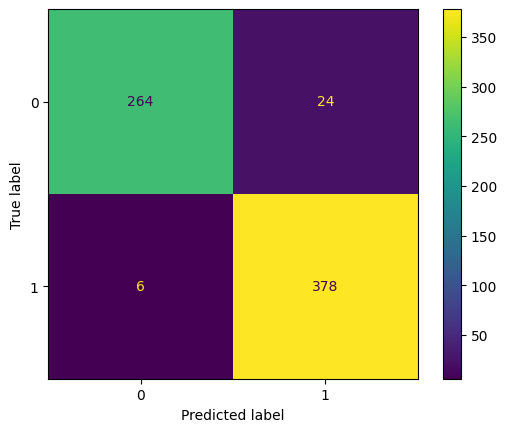

In [ ]:
# Посмотрим как с работой теперь справиться CB

# Получить отчет классификации передав в classification_report реальные метки и предсказанные
print("TEST")
print(classification_report(y_test, grid_LGBM.best_estimator_.predict(X_test)))
print("TRAIN")
print(classification_report(y_train, grid_LGBM.best_estimator_.predict(X_train)))

# Посмотреть на матрицу ошибок, передав в plot_confusion_matrix модель, тестовые данные и тестовые метки
confusion_matrix_class_all = confusion_matrix(y_train, grid_LGBM.best_estimator_.predict(X_train))
ConfusionMatrixDisplay(confusion_matrix_class_all, display_labels=[0, 1]).plot()

plt.show()